### E10S Experiment Aurora (all histograms)

This analysis compares all simple measures and histograms between the control and experiment branch.

In [1]:
import ujson as json
import matplotlib.pyplot as plt
import pandas as pd
import IPython

from pyspark.sql import SQLContext
from collections import defaultdict
from __future__ import division
from itertools import groupby
from operator import itemgetter

from moztelemetry.histogram import Histogram
from mozaggregator.aggregator import _aggregate_ping, _aggregate_aggregates, _trim_payload, simple_measures_labels, count_histogram_labels

%pylab inline
IPython.core.pylabtools.figsize(16, 7)

Unable to parse whitelist (/home/hadoop/anaconda/lib/python2.7/site-packages/moztelemetry/bucket-whitelist.json). Assuming all histograms are acceptable.
Populating the interactive namespace from numpy and matplotlib


In [2]:
sc.defaultParallelism

16

#### Get e10s and non-e10s partitions

In [4]:
dataset = sqlContext.load("s3://telemetry-parquet/e10s-experiment/generationDate=20151027", "parquet")

How many pings do we have in each branch?

In [5]:
dataset.filter(dataset["experimentBranch"] == "experiment").count()

28921L

In [6]:
dataset.filter(dataset["experimentBranch"] == "control").count()

28900L

## Histograms

In [7]:
def chi2_distance(histA, histB, eps = 1e-10, normalize = True):    
    if normalize:
        histA = histA/histA.sum()
        histB = histB/histB.sum()
    
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(histA, histB)])

    return d


def compare_histogram(histogram, e10s, none10s): 
    eTotal = e10s["histogram"]
    nTotal = none10s["histogram"]
    
    if e10s["count"] < 5000 or none10s["count"] < 5000:
        return
    
    chi2dist = chi2_distance(eTotal, nTotal)
    if chi2dist < 0.001:
        return
    
    eTotal = 100*eTotal/eTotal.sum()
    nTotal = 100*nTotal/nTotal.sum()
        
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.3)
        
    ax = fig.add_subplot(1, 1, 1)
    ax2 = ax.twinx()
    width = 0.4
    ylim = max(eTotal.max(), nTotal.max())
        
    eTotal.plot(kind="bar", alpha=0.5, color="green", label="e10s", ax=ax, width=width, position=0, ylim=(0, ylim + 1))
    nTotal.plot(kind="bar", alpha=0.5, color="blue", label="non e10s", ax=ax2, width=width, position=1, grid=False, ylim=ax.get_ylim())
        
    ax.legend(ax.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0],
              ["e10s ({} samples".format(e10s["count"]), "non e10s ({} samples)".format(none10s["count"])])

    print "The chi2 distance for {} is {}".format(histogram, chi2dist)
    plt.title(histogram)
    plt.xlabel(histogram)
    plt.ylabel("Frequency %")
    plt.show()
    
    
def map_ping_to_dimensions(ping):
    subset = {}    
    subset["payload"] = {"histograms": json.loads(ping.histograms),
                         "keyedHistograms": json.loads(ping.keyedHistograms),
                         "simpleMeasurements": json.loads(ping.simpleMeasurements)}
    
    subset["payload"]["childPayloads"] = [_trim_payload(c) for c in json.loads(ping.childPayloads)]
    return (False if ping.experimentBranch == "control" else True, subset)


def reduce_histograms(h1, h2):
    res = {}
    
    res["count"] = h1["count"] + h2["count"]
    res["sum"] = h1["sum"] + h2["sum"]
    res["histogram"] = {}

    for k in h1["histogram"].keys() + h2["histogram"].keys():
        res["histogram"][k] = h1["histogram"].get(k, 0L) + h2["histogram"].get(k, 0L)
        
    return res


def keymod_aggregates(branch_aggregates):
    keymod_branch_aggregates = [(k[0], v) for k, v in branch_aggregates[1].iteritems()]
    grouped = groupby(sorted(keymod_branch_aggregates), key=itemgetter(0))
    return dict([(k, reduce(reduce_histograms, map(itemgetter(1), group))) for k, group in grouped])


def get_complete_histogram(metric, values):
    if metric.startswith("SIMPLE_MEASURES"):
        histogram = pd.Series({int(k): v for k, v in values.iteritems()}, index=simple_measures_labels).fillna(0)
    elif metric.startswith("[[COUNT]]_"):  # Count histogram
        histogram = pd.Series({int(k): v for k, v in values.iteritems()}, index=count_histogram_labels).fillna(0)
    else:
        histogram = Histogram(metric, {"values": values}, "https://hg.mozilla.org/releases/mozilla-aurora/rev/9d3bc275a924/").buckets
        
    return histogram


def complete_histograms(histograms):
    for k, v in histograms.iteritems():
        try:
            v["histogram"] = get_complete_histogram(k, v["histogram"])
            yield (k, v)
        except:
            pass

In [8]:
trimmed = dataset.rdd.map(map_ping_to_dimensions)
partial_aggregates = trimmed.aggregateByKey(defaultdict(dict), _aggregate_ping, _aggregate_aggregates).collect()
aggregates = map(keymod_aggregates, partial_aggregates)
aggregates = map(lambda x: dict(complete_histograms(x)), aggregates)

ne10s_keys = set(aggregates[0].keys())
we10s_keys = set(aggregates[1].keys())
keys = list(ne10s_keys.intersection(we10s_keys))

In [9]:
print "Histogram that appear in non-e10s pings only:"
for x in sorted(ne10s_keys.difference(we10s_keys)):
    print x

print "\nHistogram that appear in e10s pings only:"
for x in sorted(we10s_keys.difference(ne10s_keys)):
    print x

Histogram that appear in non-e10s pings only:
CACHE_SERVICE_LOCK_WAIT_MAINTHREAD_NSCACHEENTRYDESCRIPTOR_GETDATASIZE
CACHE_SERVICE_LOCK_WAIT_MAINTHREAD_NSCACHESERVICE_DISKDEVICEHEAPSIZE
DEVTOOLS_DEBUGGER_RDP_LOCAL_PROTOTYPE_MS
DEVTOOLS_DEBUGGER_RDP_LOCAL_WORKERDETACH_MS
DEVTOOLS_DEBUGGER_RDP_REMOTE_BINDINGS_MS
DEVTOOLS_DEBUGGER_RDP_REMOTE_BLACKBOX_MS
DEVTOOLS_DEBUGGER_RDP_REMOTE_CLIENTEVALUATE_MS
DEVTOOLS_DEBUGGER_RDP_REMOTE_DELETE_MS
DEVTOOLS_DEBUGGER_RDP_REMOTE_EVENTLISTENERS_MS
DEVTOOLS_DEBUGGER_RDP_REMOTE_FRAMES_MS
DEVTOOLS_DEBUGGER_RDP_REMOTE_PROTOTYPEANDPROPERTIES_MS
DEVTOOLS_DEBUGGER_RDP_REMOTE_RELOAD_MS
DEVTOOLS_DEBUGGER_RDP_REMOTE_SCOPE_MS
DEVTOOLS_PAINTFLASHING_OPENED_BOOLEAN
DEVTOOLS_PAINTFLASHING_TIME_ACTIVE_SECONDS
DEVTOOLS_TILT_OPENED_BOOLEAN
DEVTOOLS_TILT_TIME_ACTIVE_SECONDS
DEVTOOLS_WEBIDE_WIFI_CONNECTION_RESULT
FX_MIGRATION_ENTRY_POINT
FX_TAB_SWITCH_TOTAL_MS
HTTP_PAGE_COMPLETE_LOAD_NET
HTTP_SUB_COMPLETE_LOAD_NET
PLACES_AUTOCOMPLETE_URLINLINE_DOMAIN_QUERY_TIME_MS
PUSH_AP

The chi2 distance for BLOCKED_ON_PLUGIN_MODULE_INIT_MS is 0.999694981712


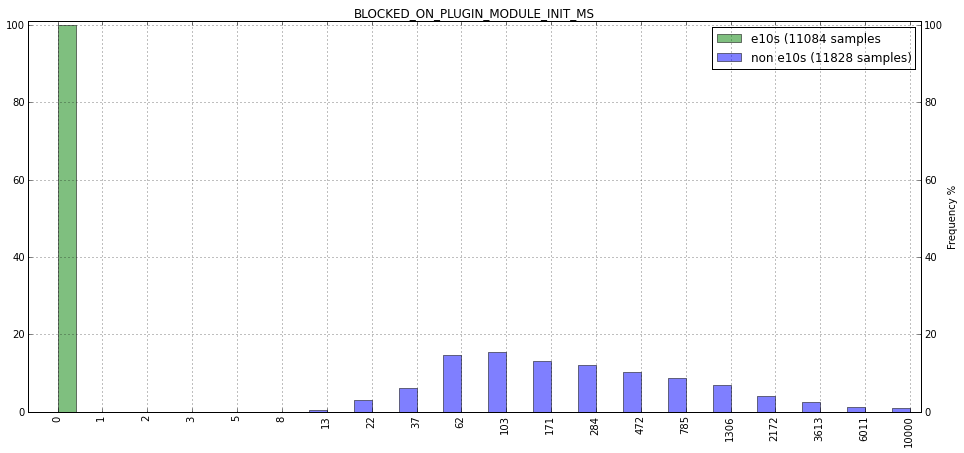

The chi2 distance for E10S_AUTOSTART_STATUS is 0.999100874768


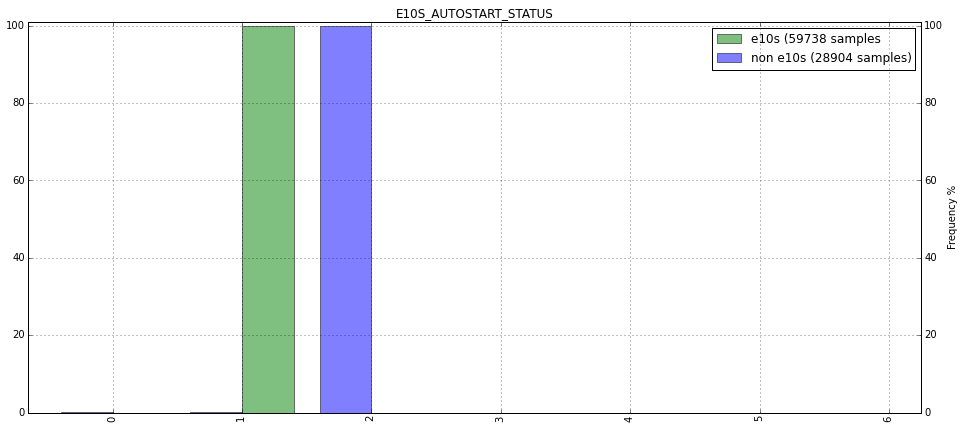

The chi2 distance for E10S_AUTOSTART is 0.998962619631


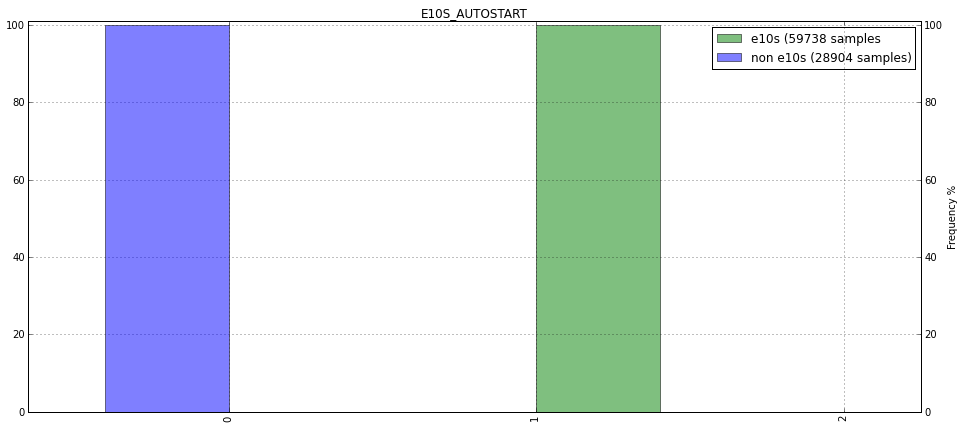

The chi2 distance for E10S_WINDOW is 0.997036830161


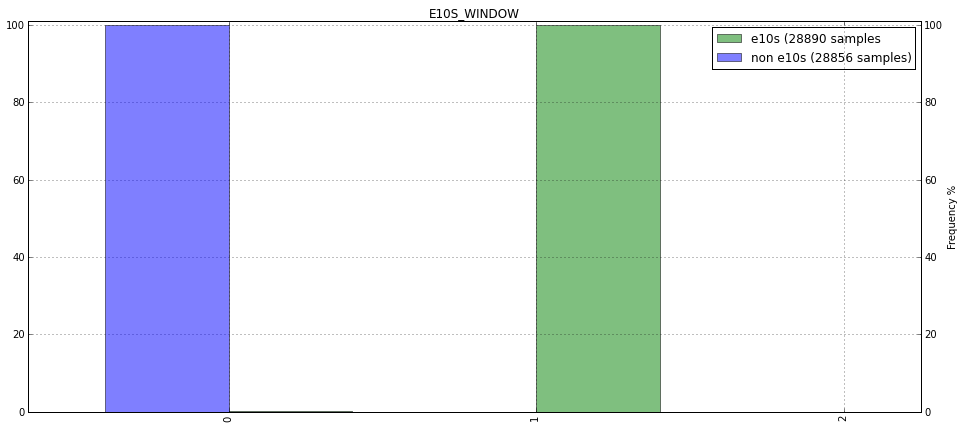

The chi2 distance for FIND_PLUGINS is 0.623726013512


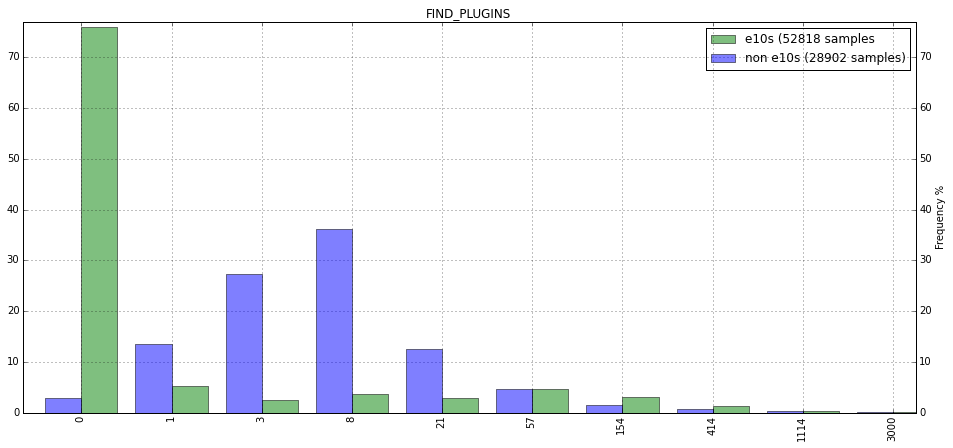

The chi2 distance for FX_THUMBNAILS_CAPTURE_TIME_MS is 0.606017345098


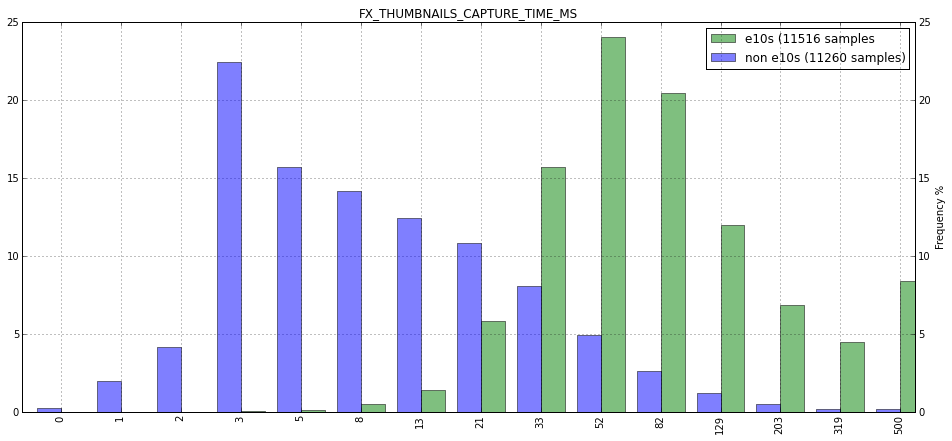

The chi2 distance for HTTP_REQUEST_PER_PAGE_FROM_CACHE is 0.462644064942


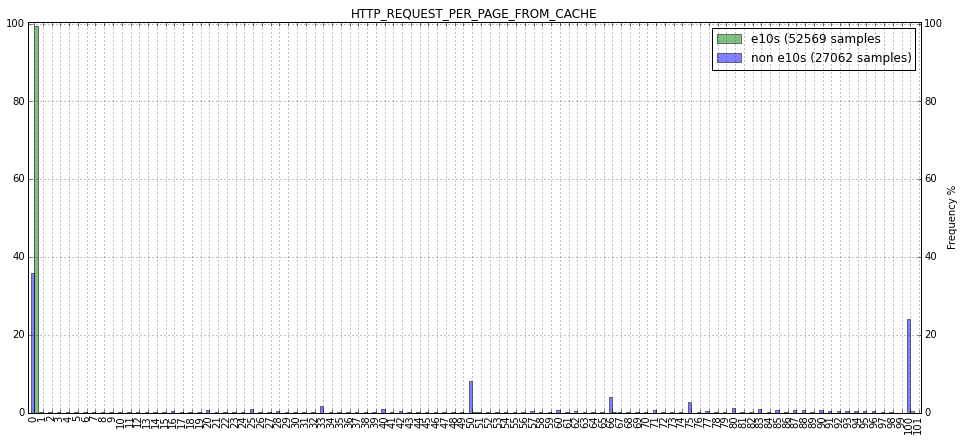

The chi2 distance for MEMORY_JS_COMPARTMENTS_SYSTEM is 0.450267288544


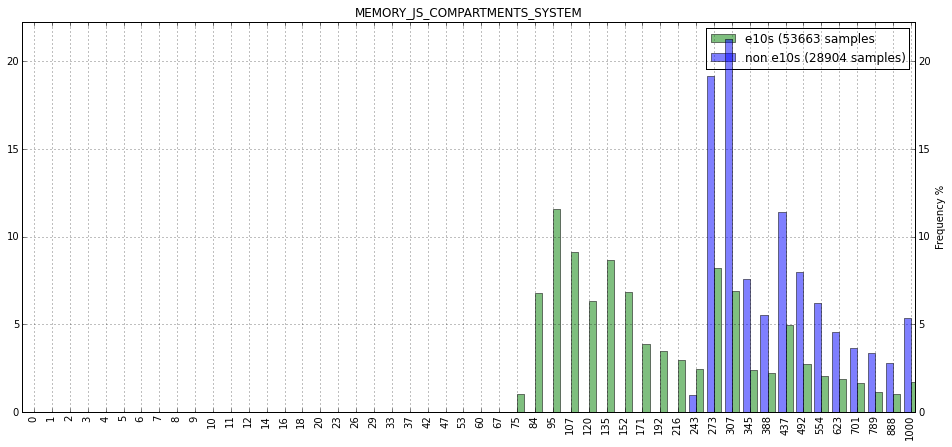

The chi2 distance for HTTP_SUB_DNS_ISSUE_TIME is 0.354896642555


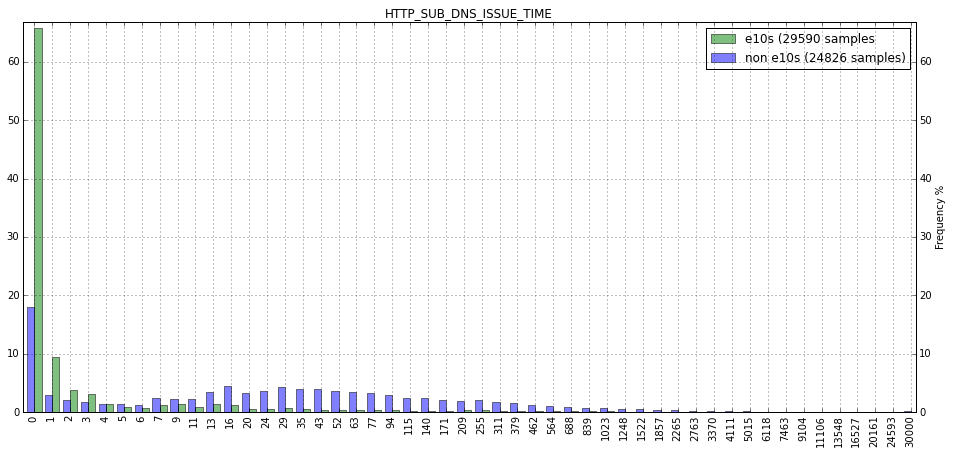

The chi2 distance for HTTP_SUB_DNS_LOOKUP_TIME is 0.299298849132


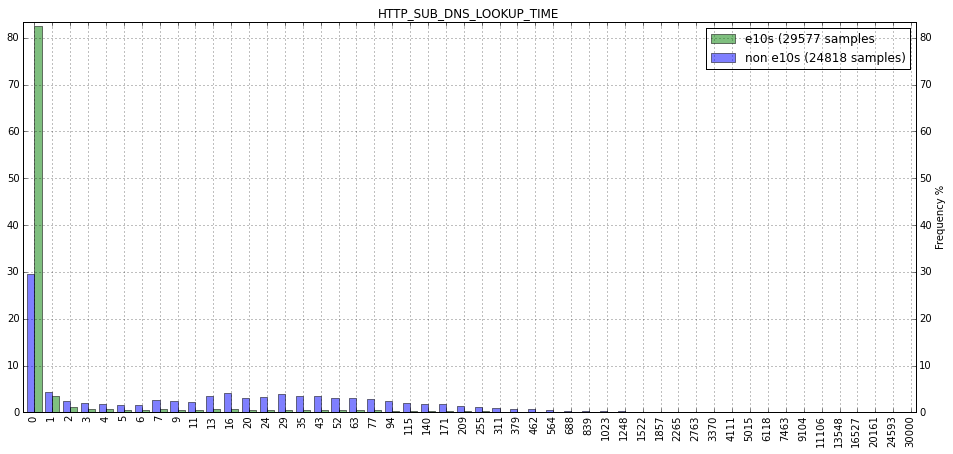

The chi2 distance for HTTP_PAGE_DNS_ISSUE_TIME is 0.234920601913


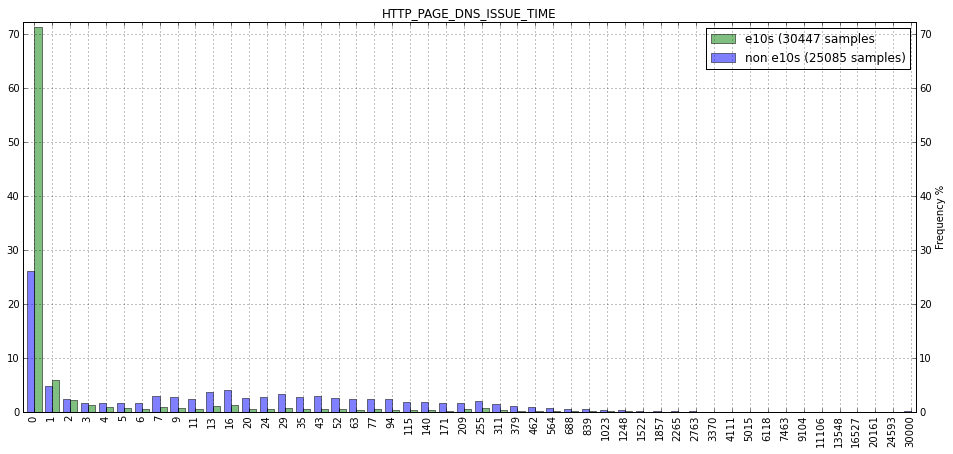

The chi2 distance for GC_MINOR_REASON_LONG is 0.217723363762


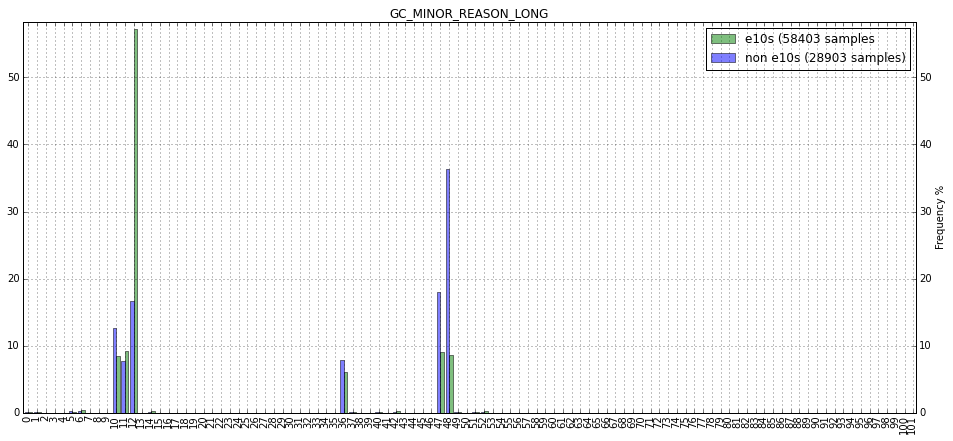

The chi2 distance for SIMPLE_MEASURES_FIRSTLOADURI is 0.207806311926


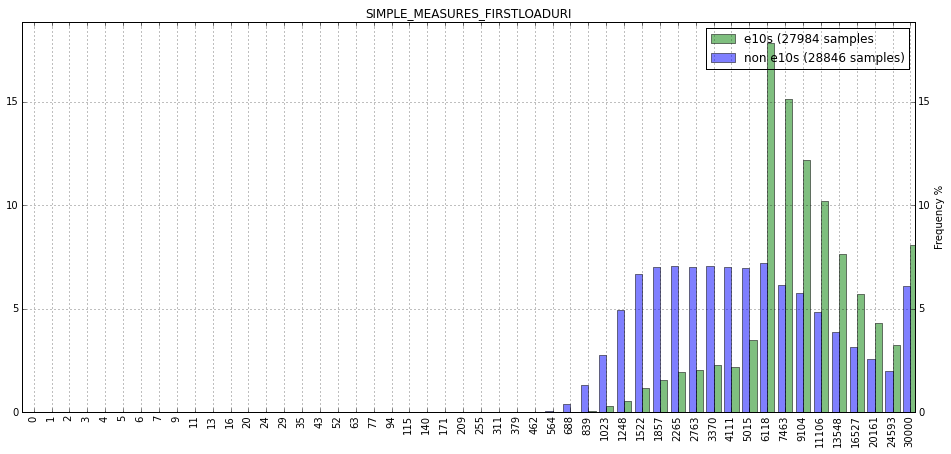

The chi2 distance for CYCLE_COLLECTOR_VISITED_GCED is 0.165398066387


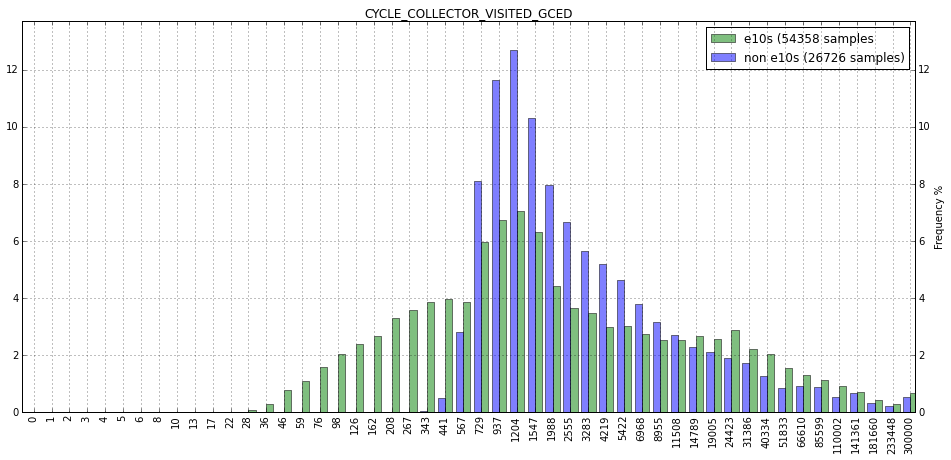

The chi2 distance for FX_TAB_SWITCH_UPDATE_MS is 0.164589319324


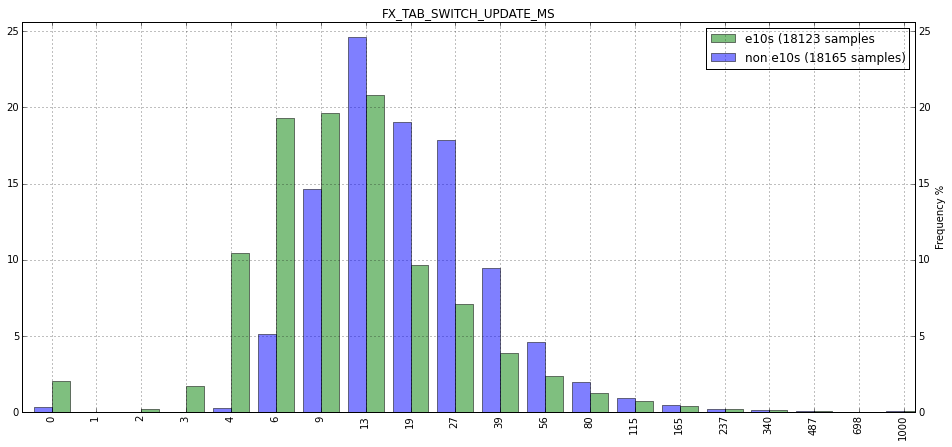

The chi2 distance for HTTP_PAGE_OPEN_TO_FIRST_FROM_CACHE_V2 is 0.155465617687


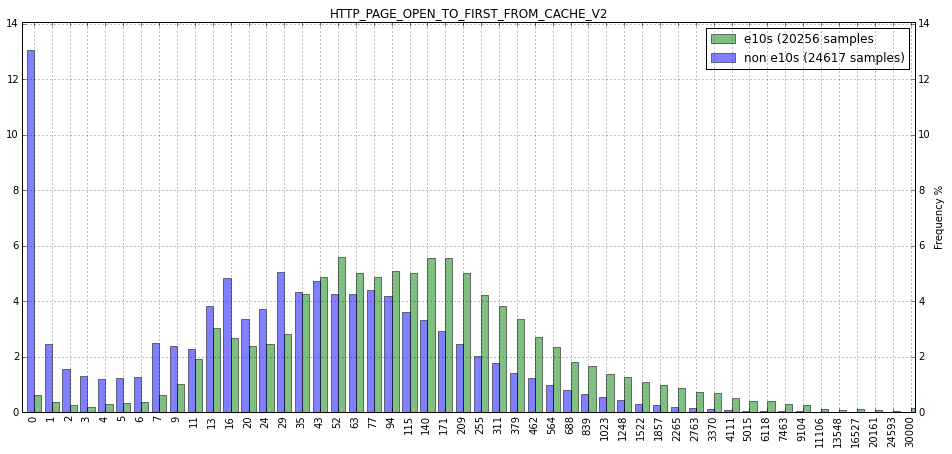

The chi2 distance for SYSTEM_FONT_FALLBACK is 0.154309303597


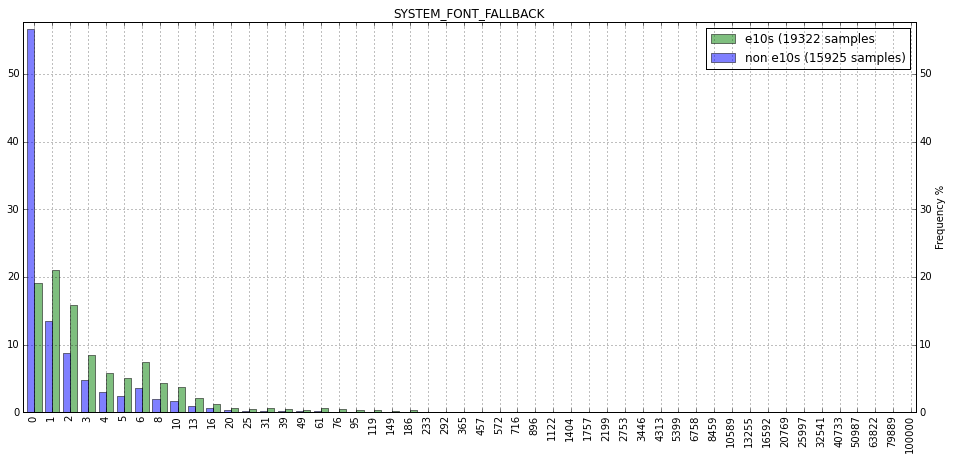

The chi2 distance for SIMPLE_MEASURES_MAXIMALNUMBEROFCONCURRENTTHREADS is 0.14887763397


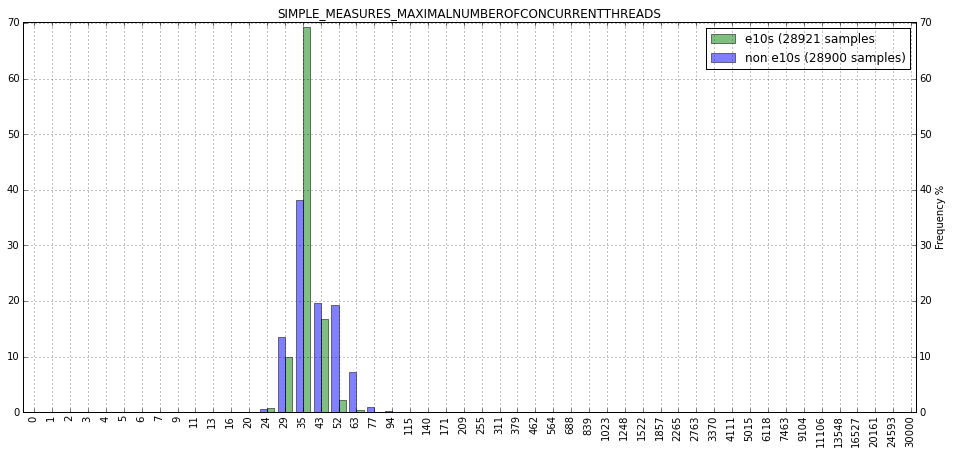

The chi2 distance for FX_TAB_CLICK_MS is 0.148539949043


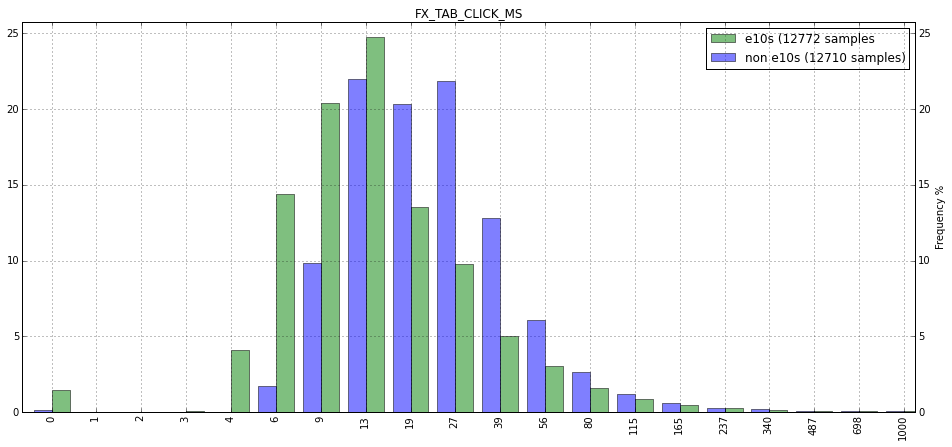

The chi2 distance for MEMORY_JS_COMPARTMENTS_USER is 0.147071597961


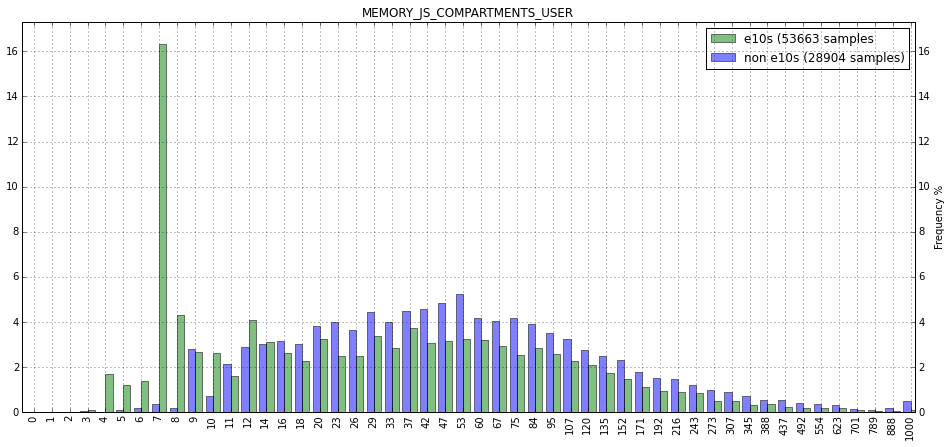

The chi2 distance for GC_MARK_ROOTS_MS is 0.139852795995


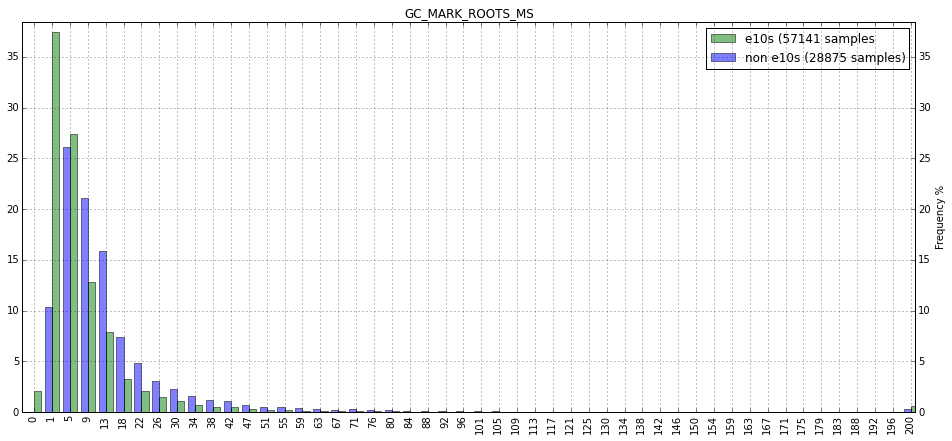

The chi2 distance for PLUGIN_LOAD_METADATA is 0.132998493816


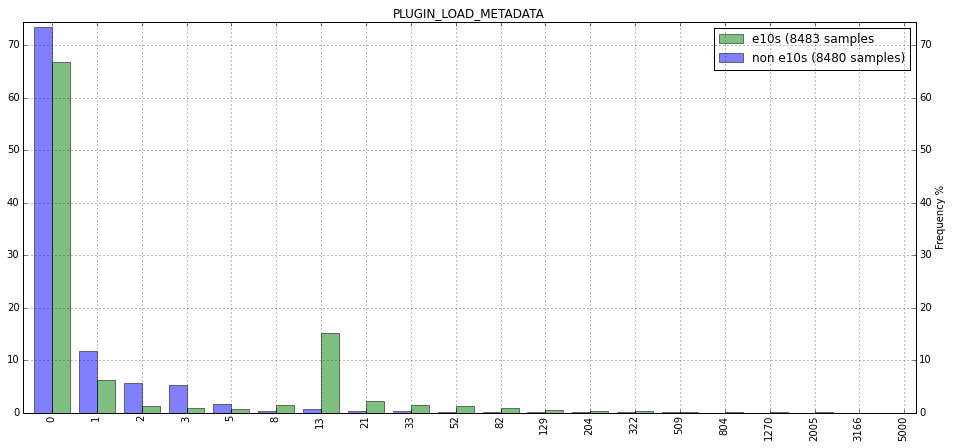

The chi2 distance for GC_MARK_MS is 0.129092950784


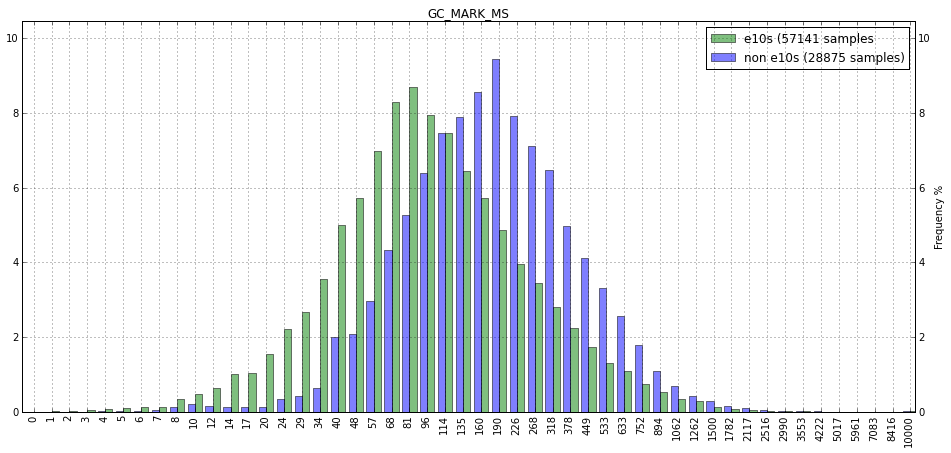

The chi2 distance for HTTP_PAGE_OPEN_TO_FIRST_SENT is 0.126464519389


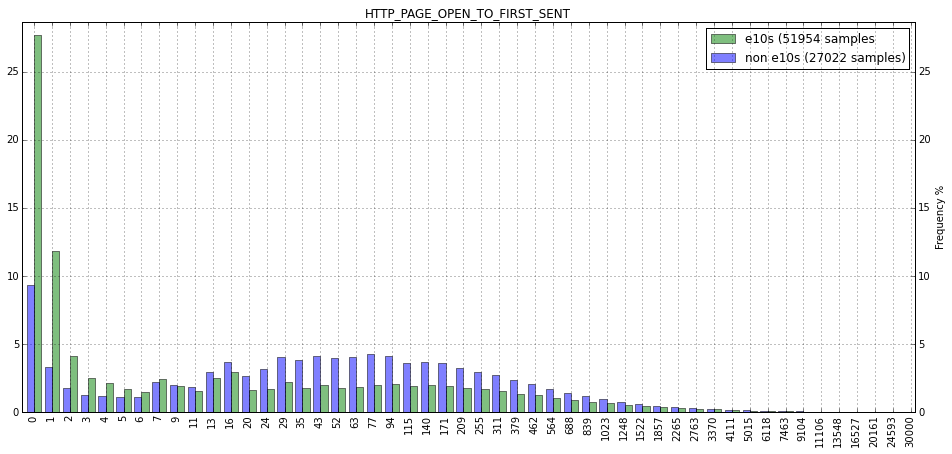

The chi2 distance for MEMORY_VSIZE is 0.123413283559


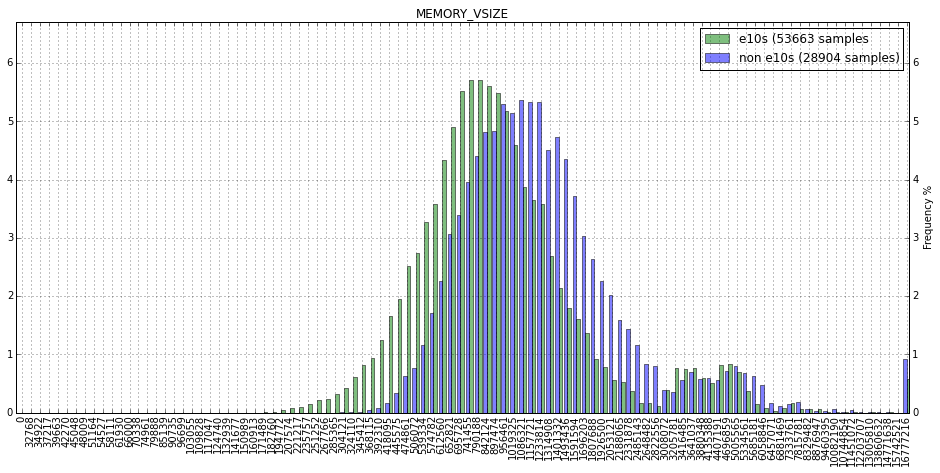

The chi2 distance for GC_MINOR_REASON is 0.122866748521


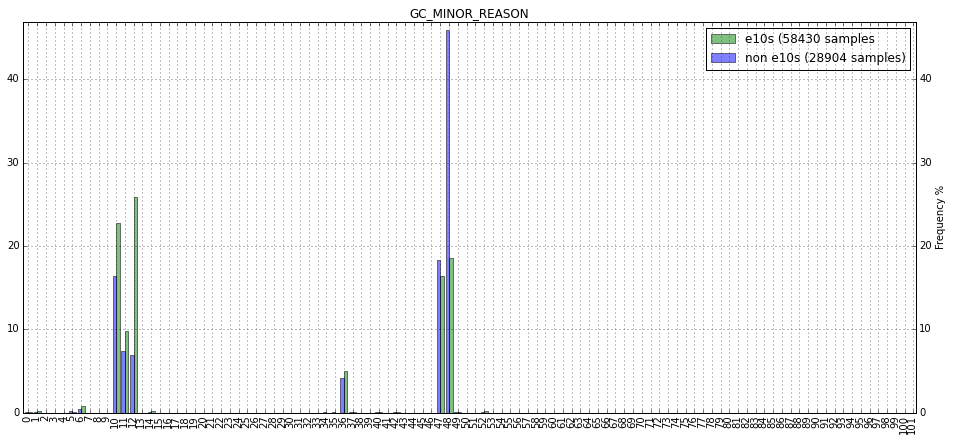

The chi2 distance for SIMPLE_MEASURES_JS_SETPROTO is 0.120942123708


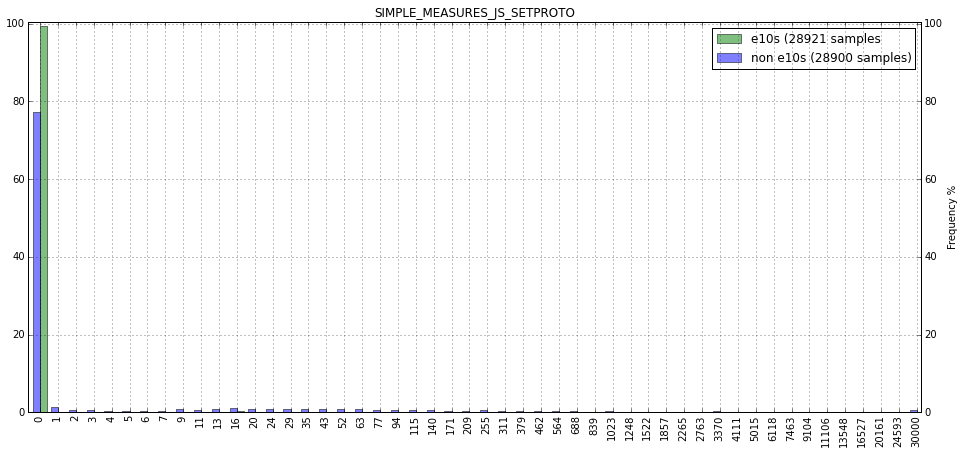

The chi2 distance for MEMORY_RESIDENT is 0.119404753389


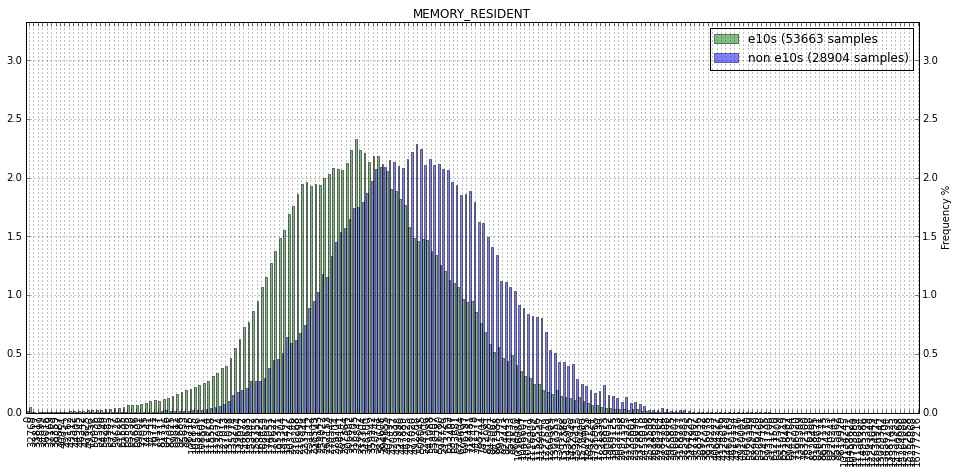

The chi2 distance for GC_MS is 0.118215906329


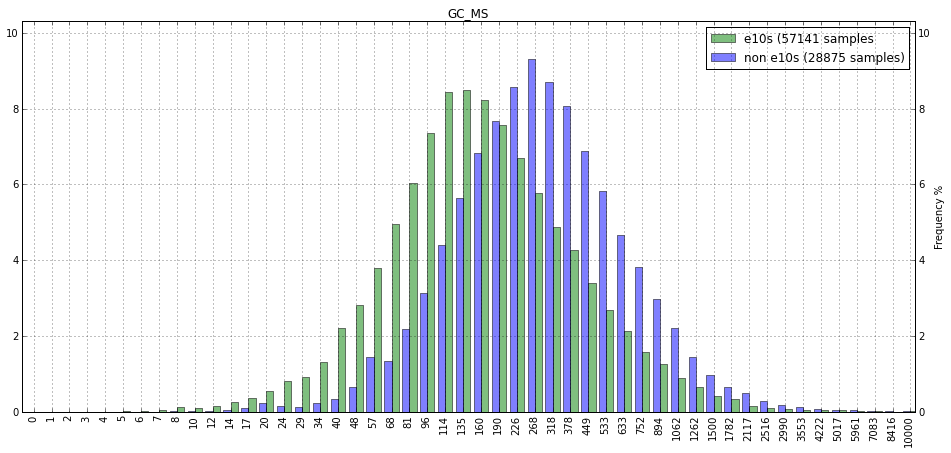

The chi2 distance for HTTP_SUB_REVALIDATION is 0.111443715344


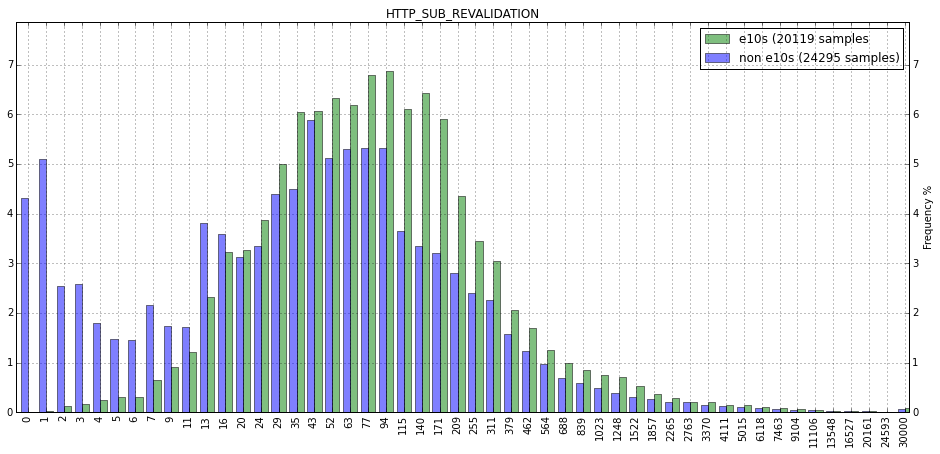

The chi2 distance for MEMORY_HEAP_ALLOCATED is 0.108656394288


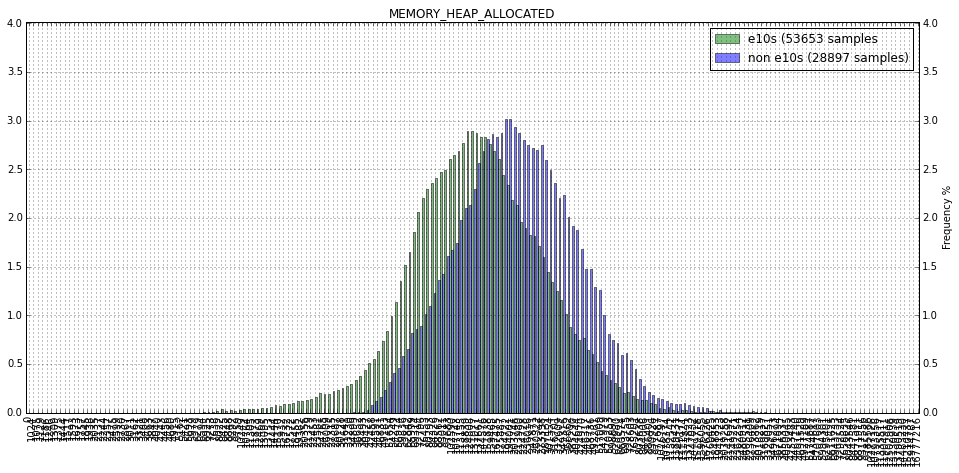

The chi2 distance for MEMORY_JS_GC_HEAP is 0.105824897949


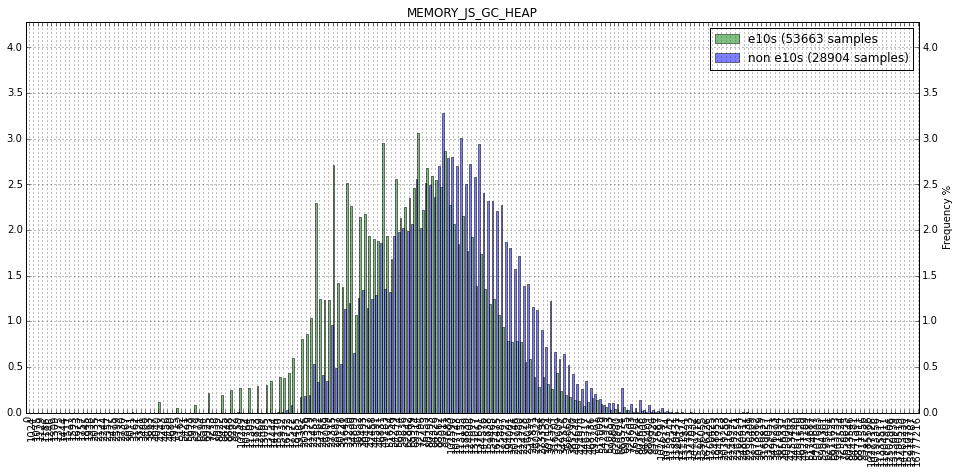

The chi2 distance for HTTP_PAGE_DNS_LOOKUP_TIME is 0.105280507159


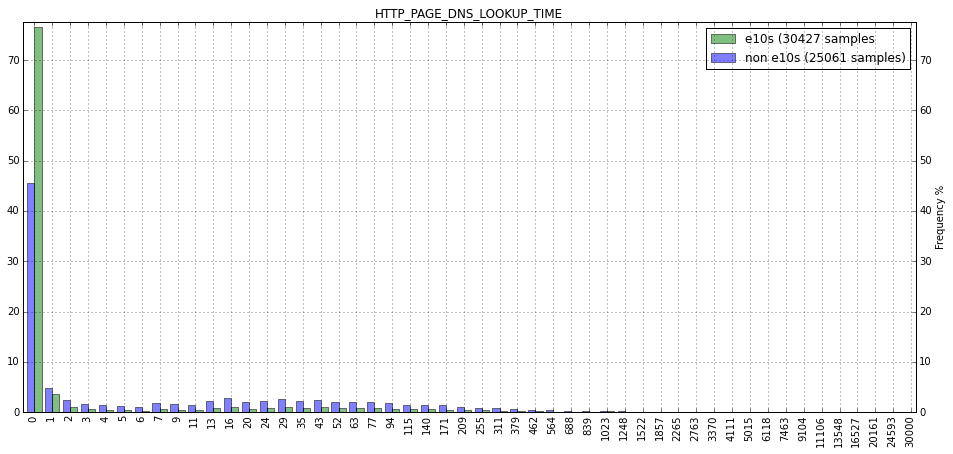

The chi2 distance for CYCLE_COLLECTOR_VISITED_REF_COUNTED is 0.105047223932


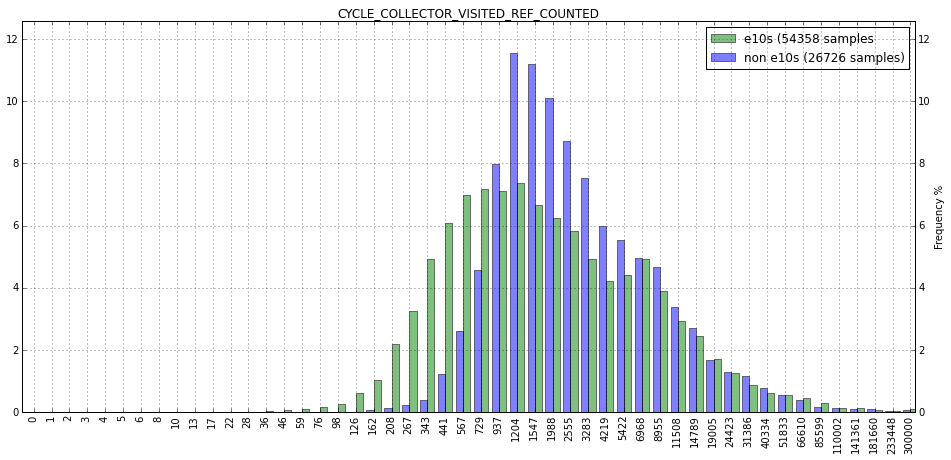

The chi2 distance for CERT_VALIDATION_HTTP_REQUEST_CANCELED_TIME is 0.1027344886


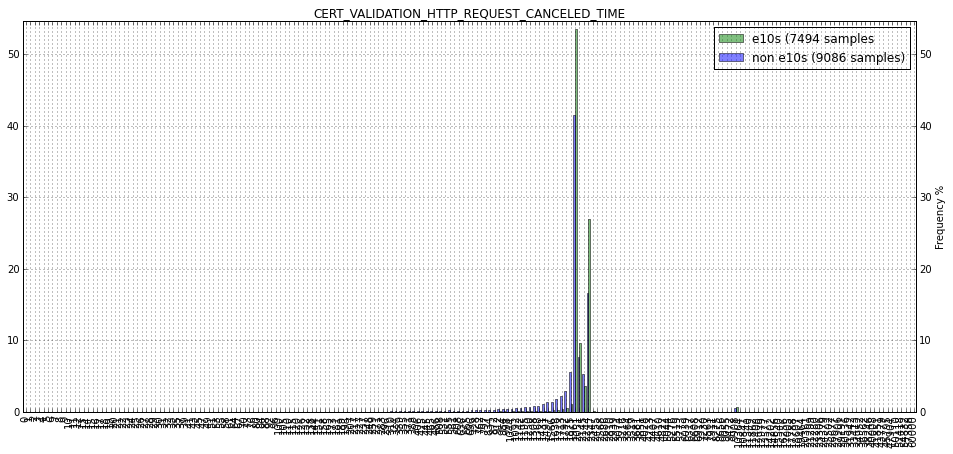

The chi2 distance for SYSTEM_FONT_FALLBACK_SCRIPT is 0.0976264483313


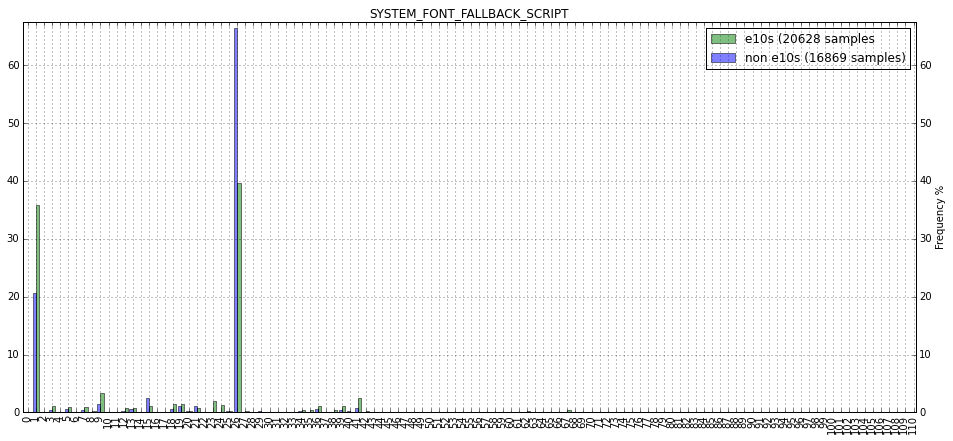

The chi2 distance for HTTP_SUB_OPEN_TO_FIRST_SENT is 0.0970803069447


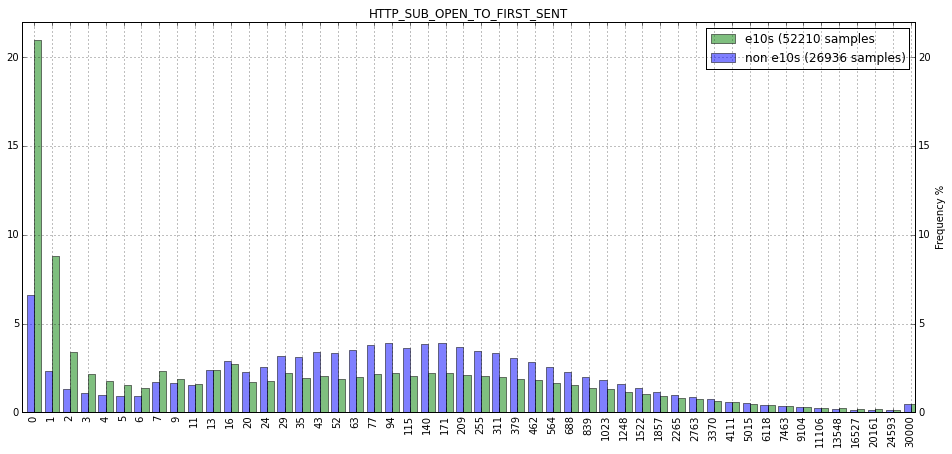

The chi2 distance for GC_SWEEP_MS is 0.0944007952184


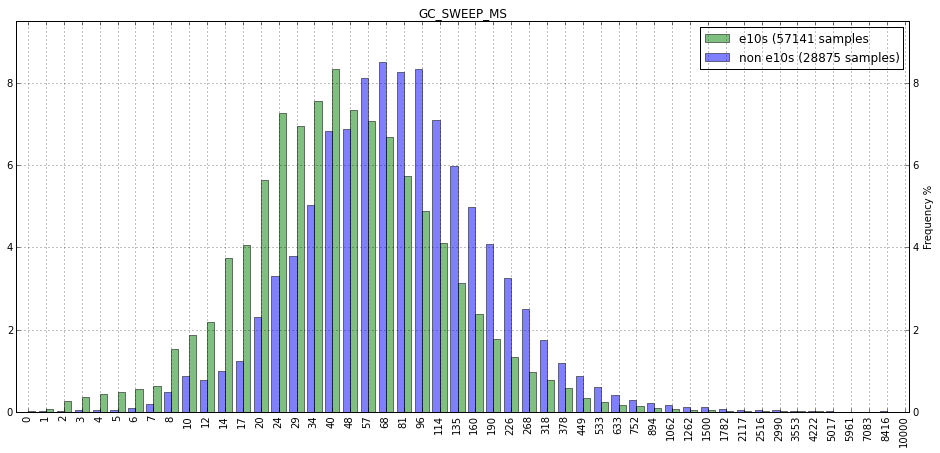

The chi2 distance for HTTP_SUBITEM_OPEN_LATENCY_TIME is 0.0908513376676


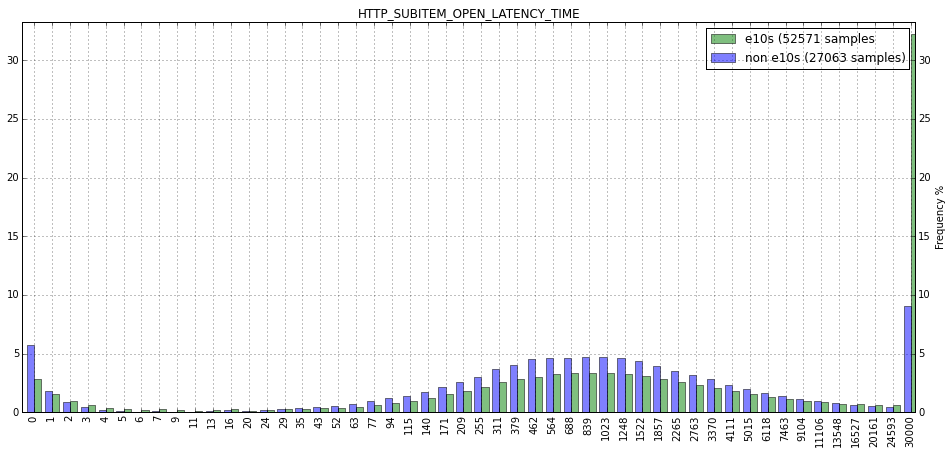

The chi2 distance for HTTP_PAGE_CACHE_READ_TIME_V2 is 0.081922029387


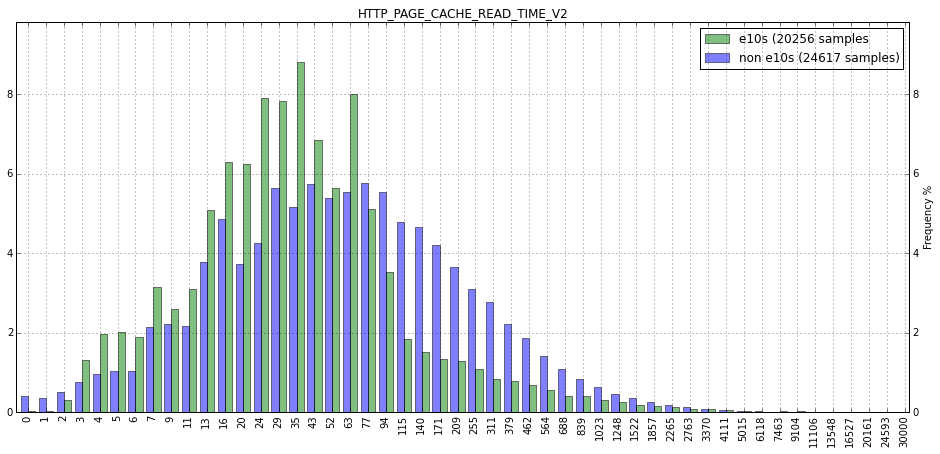

The chi2 distance for HTTP_PAGE_COMPLETE_LOAD_CACHED_V2 is 0.0672446740694


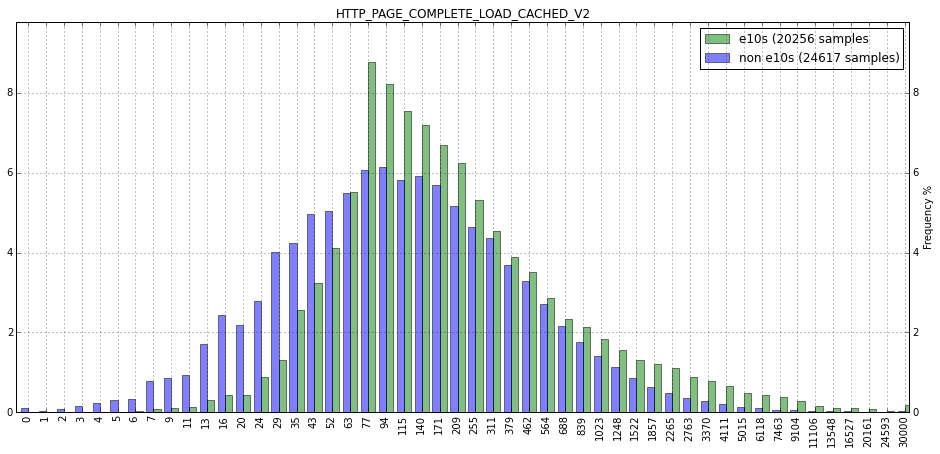

The chi2 distance for HTTP_PAGE_COMPLETE_LOAD is 0.0672052400127


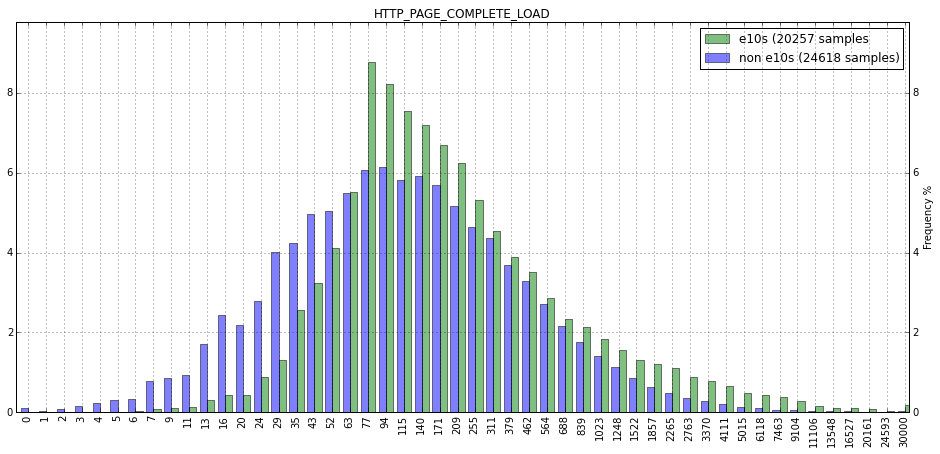

The chi2 distance for CYCLE_COLLECTOR is 0.0666822156554


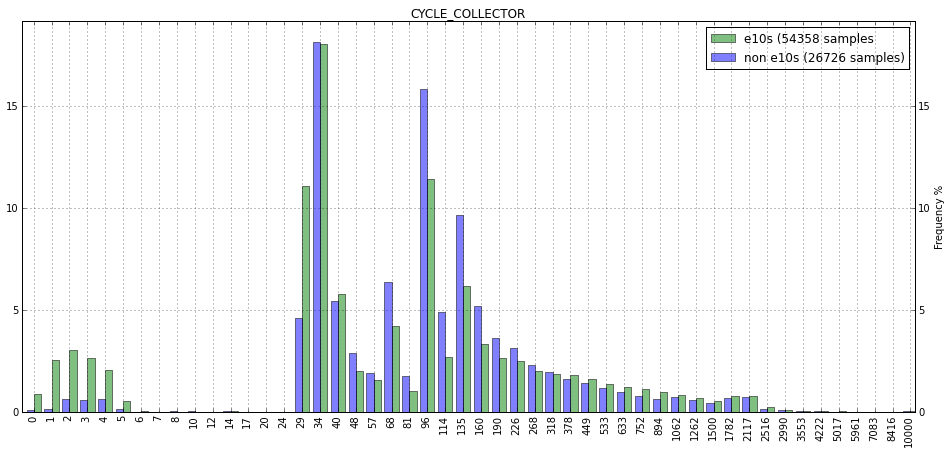

The chi2 distance for CYCLE_COLLECTOR_FULL is 0.0666212484806


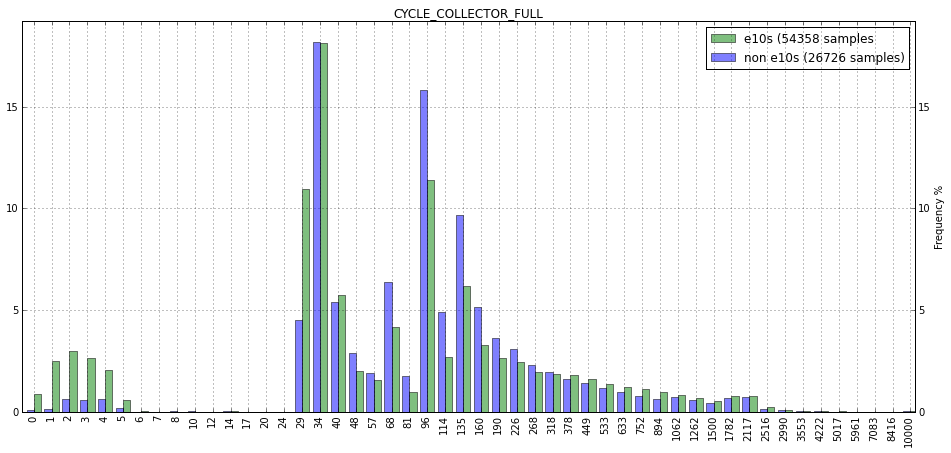

The chi2 distance for PAINT_BUILD_DISPLAYLIST_TIME is 0.064360418449


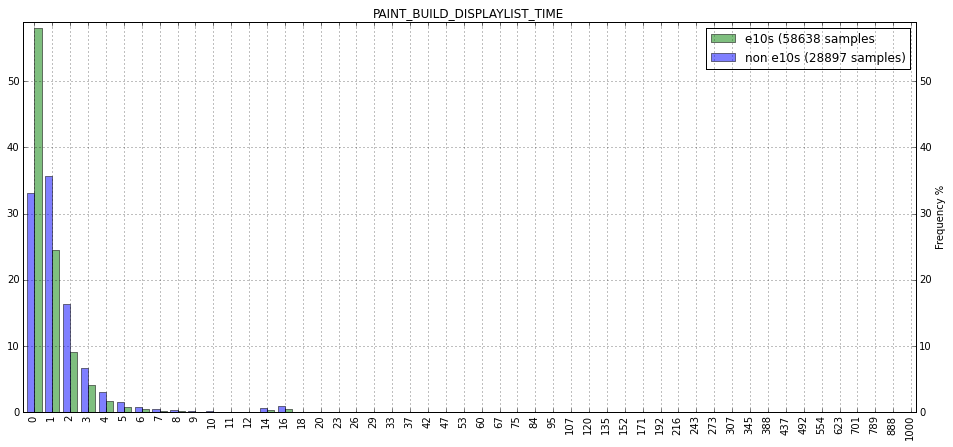

The chi2 distance for DNS_FAILED_LOOKUP_TIME is 0.0626772590544


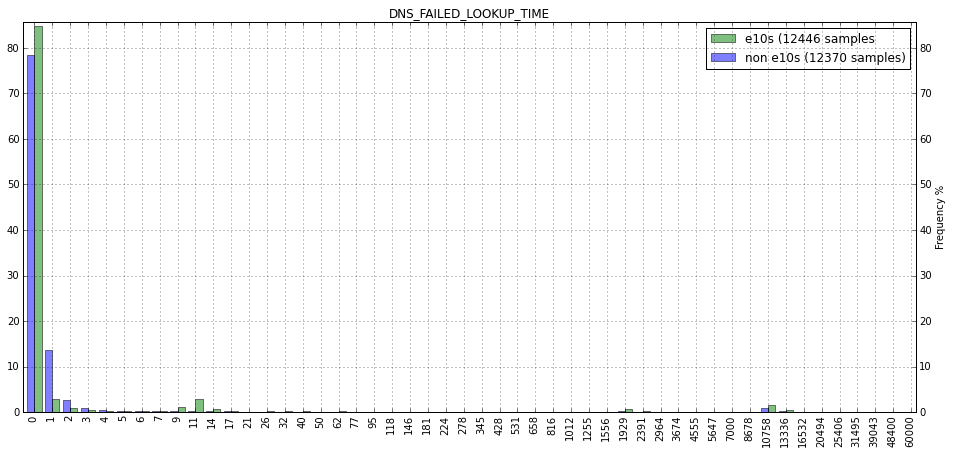

The chi2 distance for GC_MMU_50 is 0.062204447424


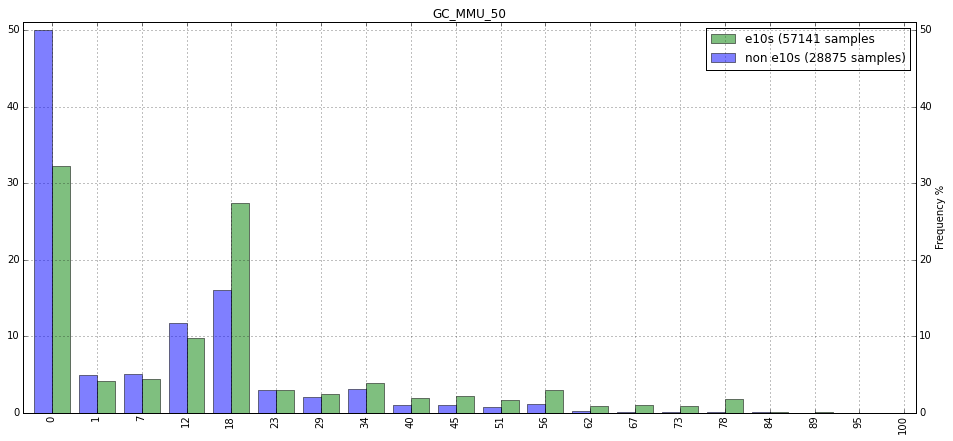

The chi2 distance for GC_MINOR_US is 0.0616971899635


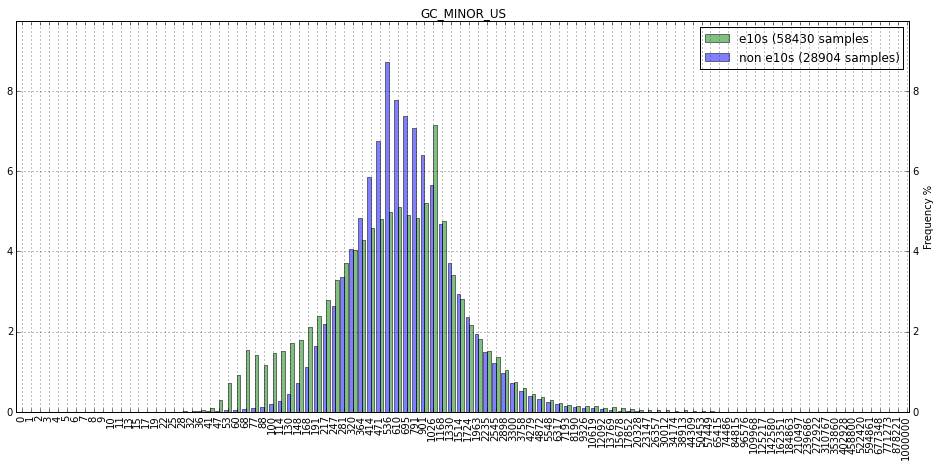

The chi2 distance for LOCALDOMSTORAGE_GETVALUE_BLOCKING_MS is 0.0603253420791


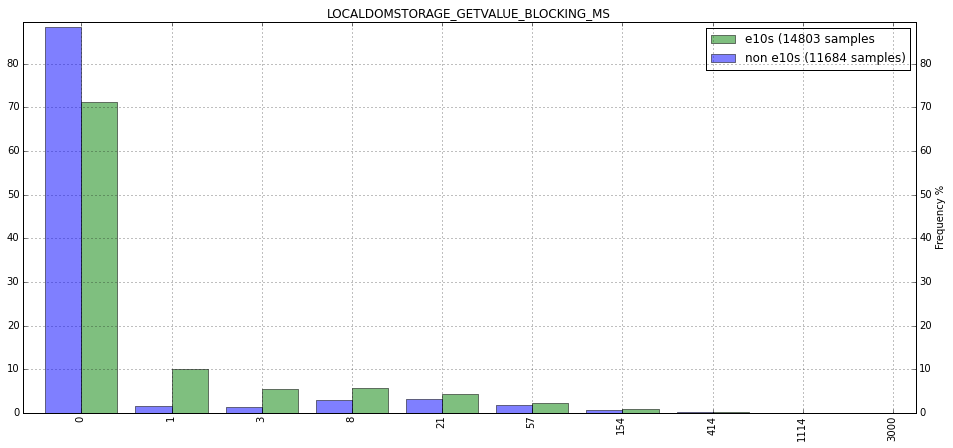

The chi2 distance for ADDON_SHIM_USAGE is 0.0582032269061


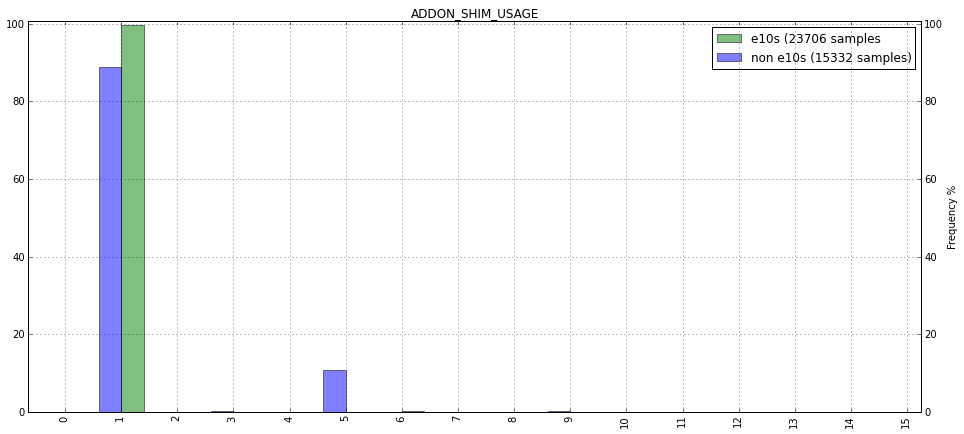

The chi2 distance for GC_MARK_GRAY_MS is 0.0566977453417


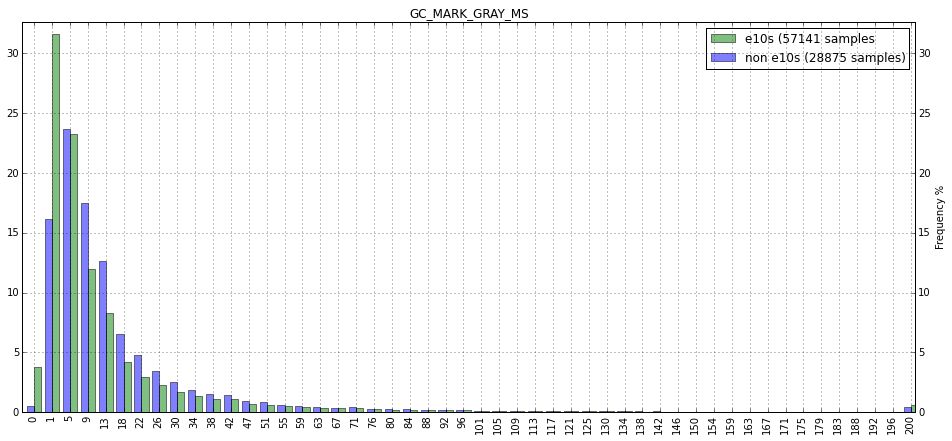

The chi2 distance for FX_SESSION_RESTORE_RESTORE_WINDOW_MS is 0.0547204293314


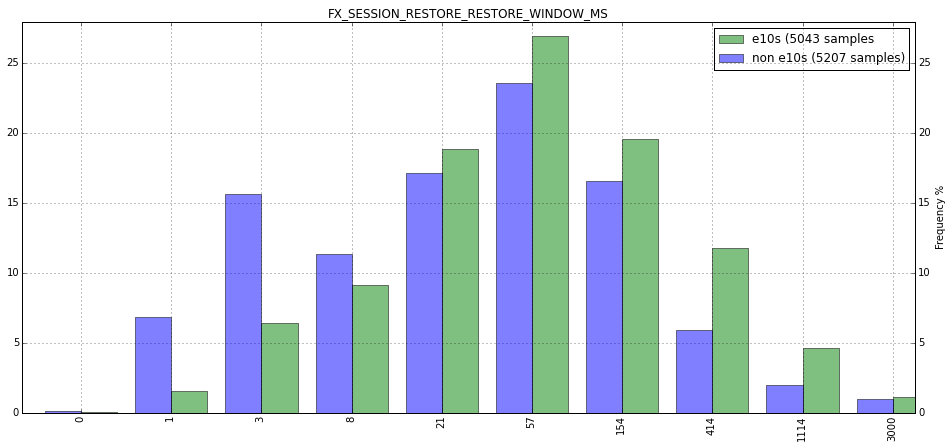

The chi2 distance for MEMORY_JS_MAIN_RUNTIME_TEMPORARY_PEAK is 0.0508120237782


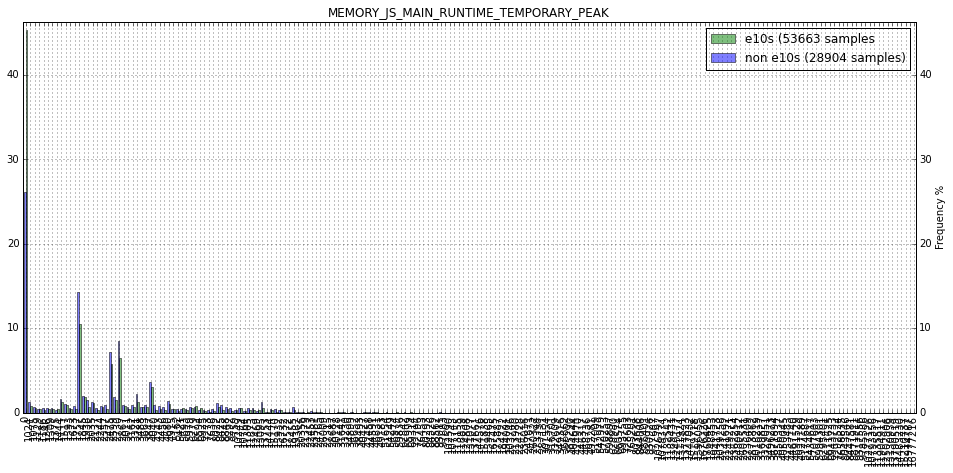

The chi2 distance for IMAGE_MAX_DECODE_COUNT is 0.0485489632035


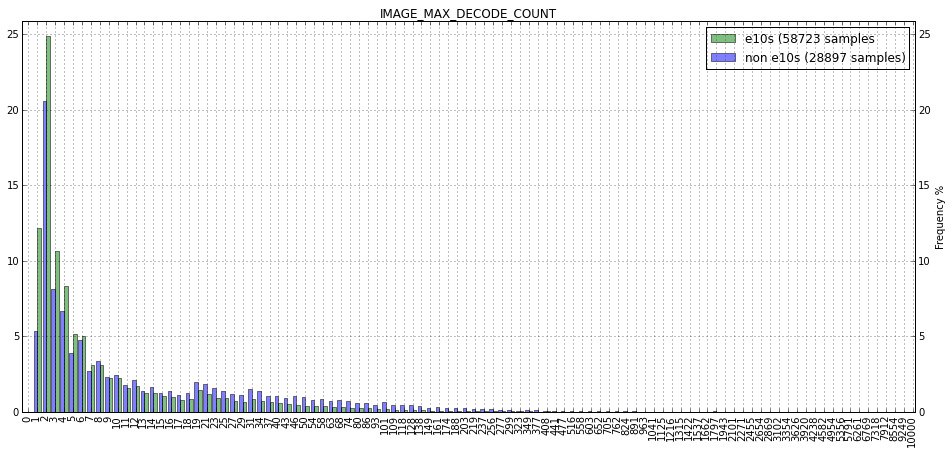

The chi2 distance for MEMORY_HEAP_COMMITTED_UNUSED_RATIO is 0.0466552187057


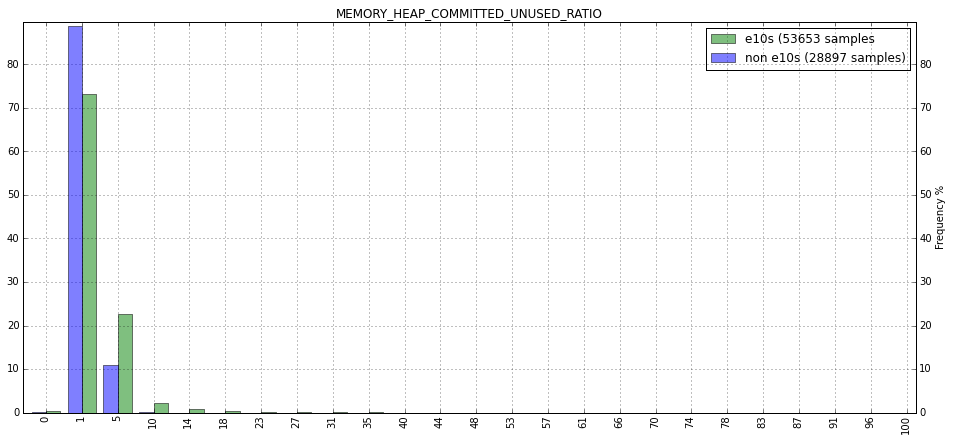

The chi2 distance for HEALTHREPORT_COLLECT_CONSTANT_DATA_MS is 0.0452185183455


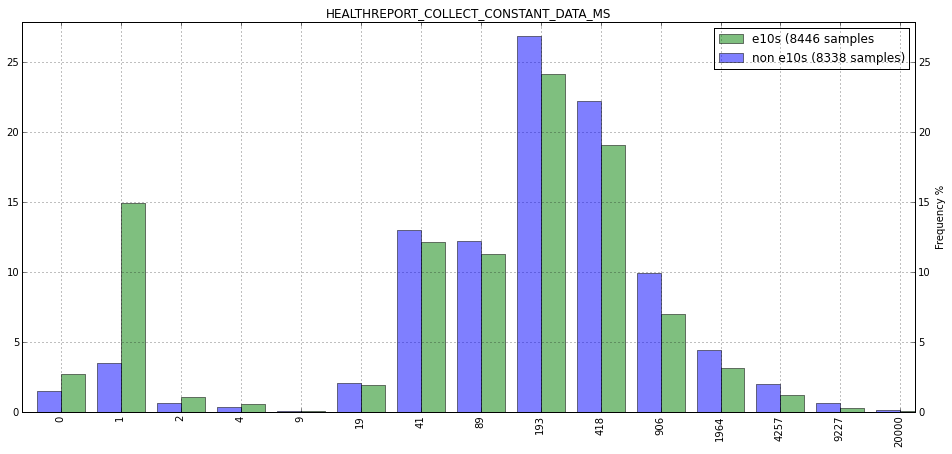

The chi2 distance for GC_REASON_2 is 0.045137798257


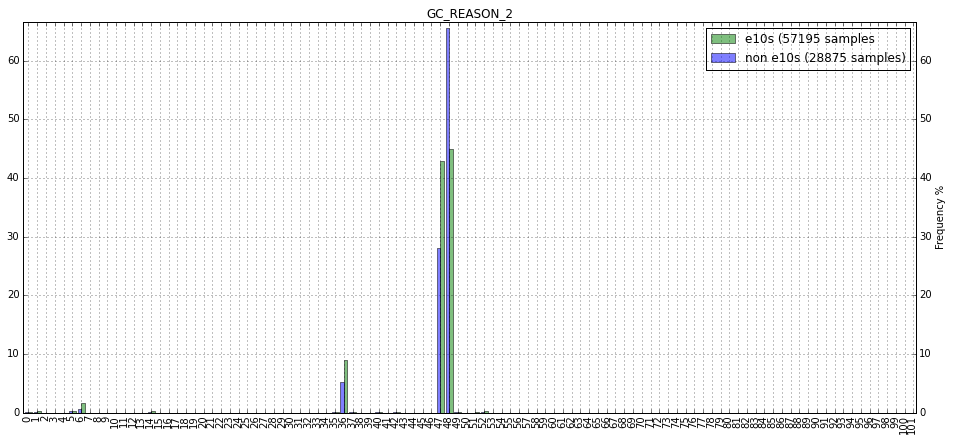

The chi2 distance for IMAGE_DECODE_ON_DRAW_LATENCY is 0.0399773133393


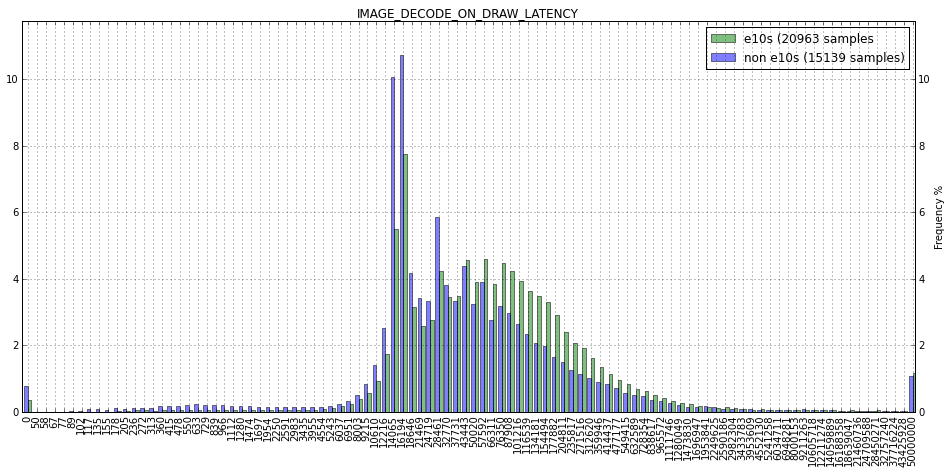

The chi2 distance for TELEMETRY_MEMORY_REPORTER_MS is 0.0389926177658


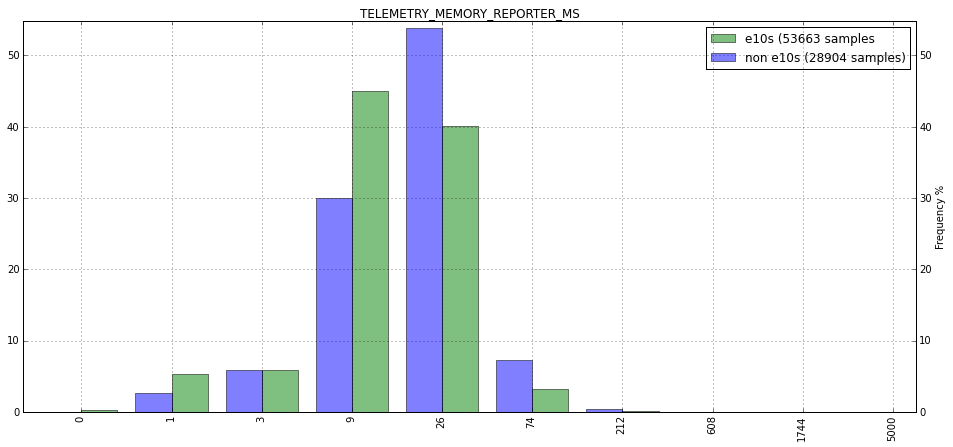

The chi2 distance for GC_MAX_PAUSE_MS is 0.0389424880905


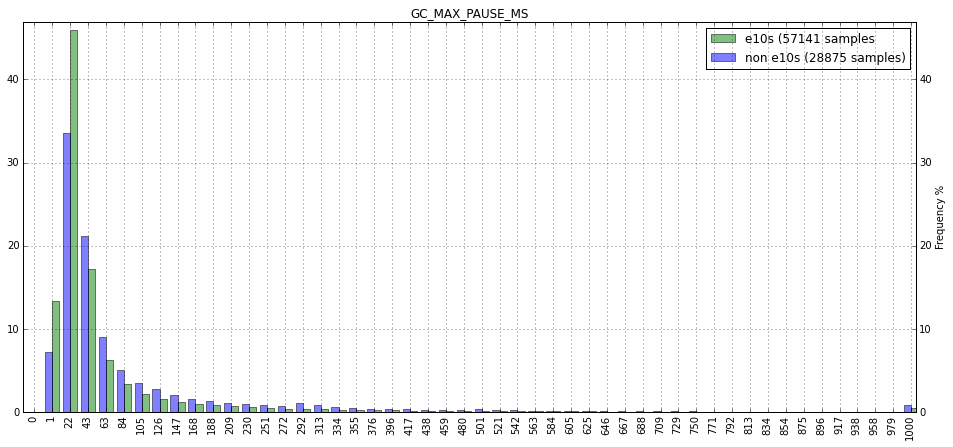

The chi2 distance for GC_SCC_SWEEP_TOTAL_MS is 0.038192463596


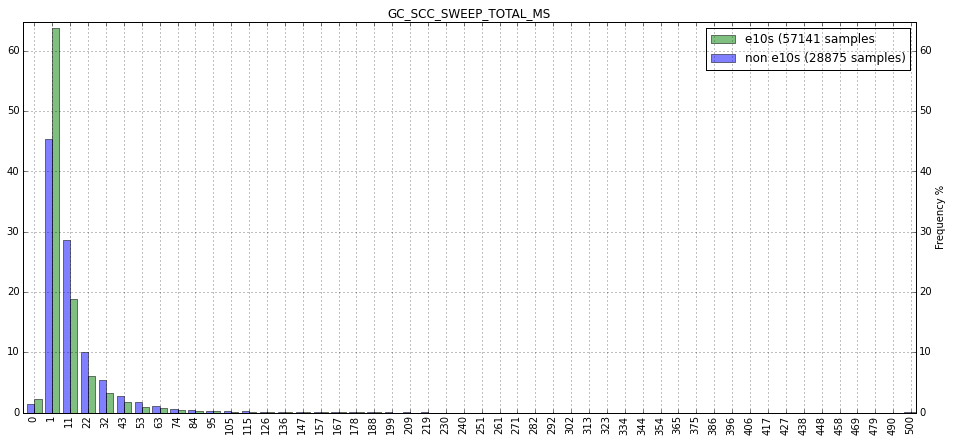

The chi2 distance for FX_TAB_ANIM_ANY_FRAME_INTERVAL_MS is 0.037091921708


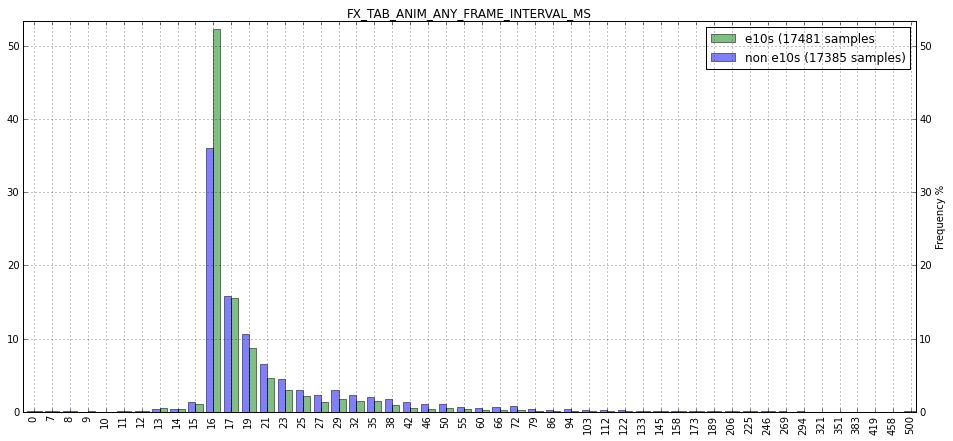

The chi2 distance for AUDIOSTREAM_LATER_OPEN_MS is 0.0351297562448


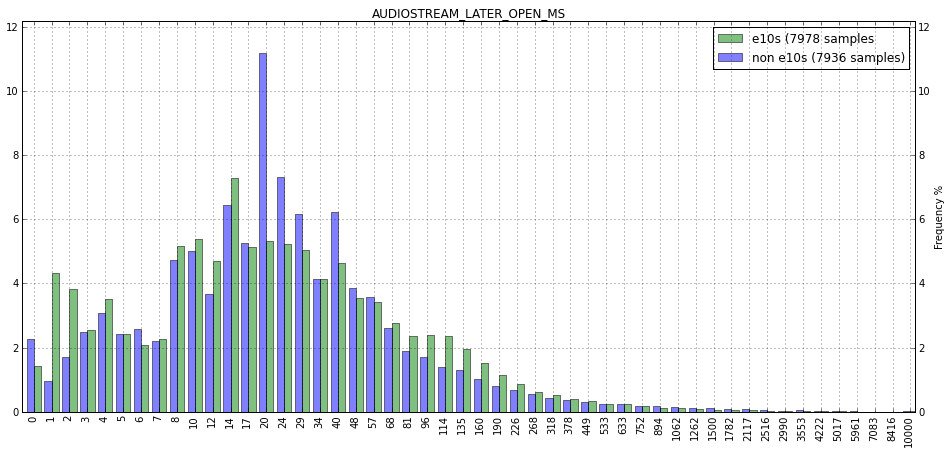

The chi2 distance for WEBSOCKETS_HANDSHAKE_TYPE is 0.0339460301448


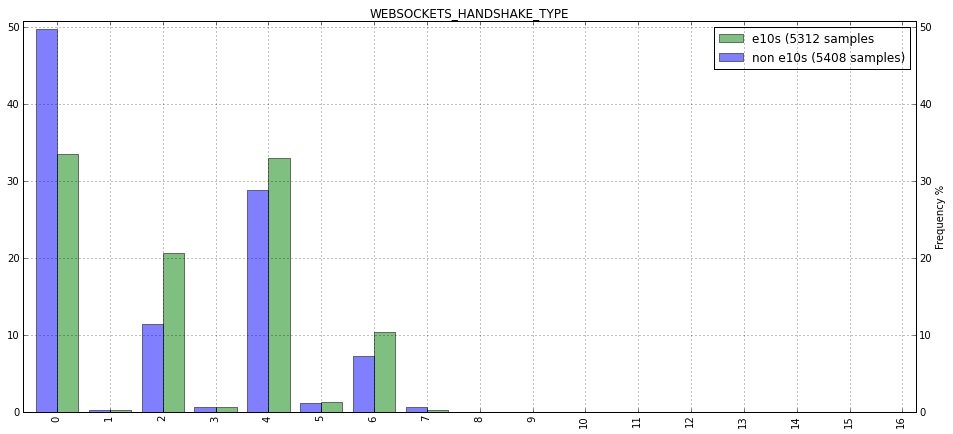

The chi2 distance for HTTP_SUB_CACHE_READ_TIME_V2 is 0.033892094195


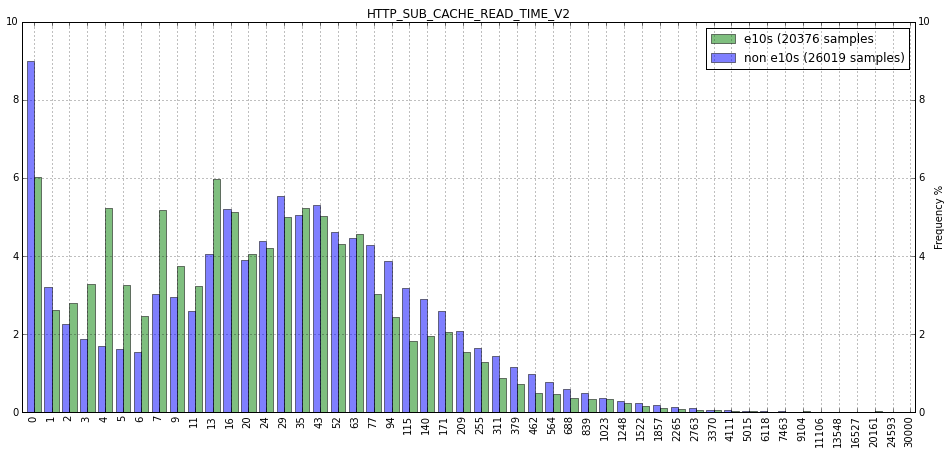

The chi2 distance for NETWORK_CACHE_HIT_RATE_PER_CACHE_SIZE is 0.0334146630835


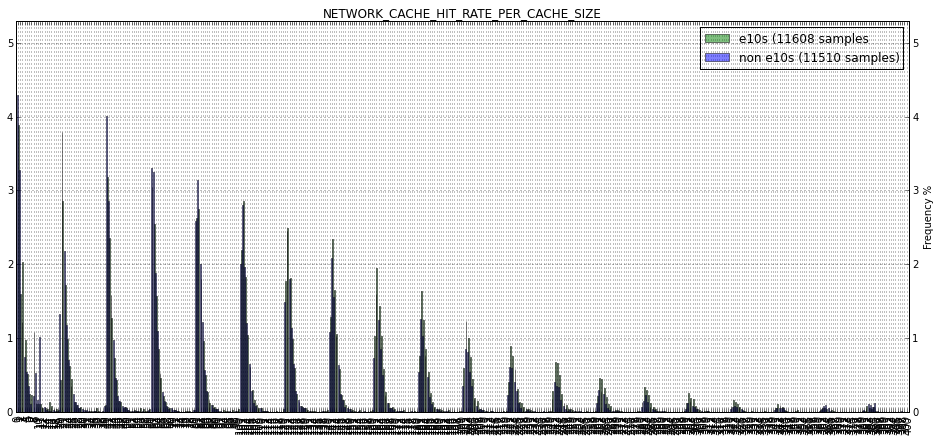

The chi2 distance for PWMGR_LOGIN_LAST_USED_DAYS is 0.0286245769577


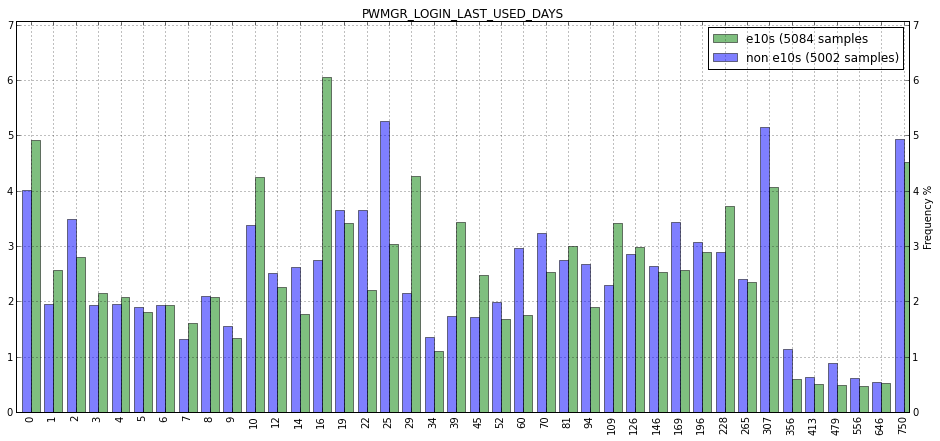

The chi2 distance for PAINT_RASTERIZE_TIME is 0.028031171663


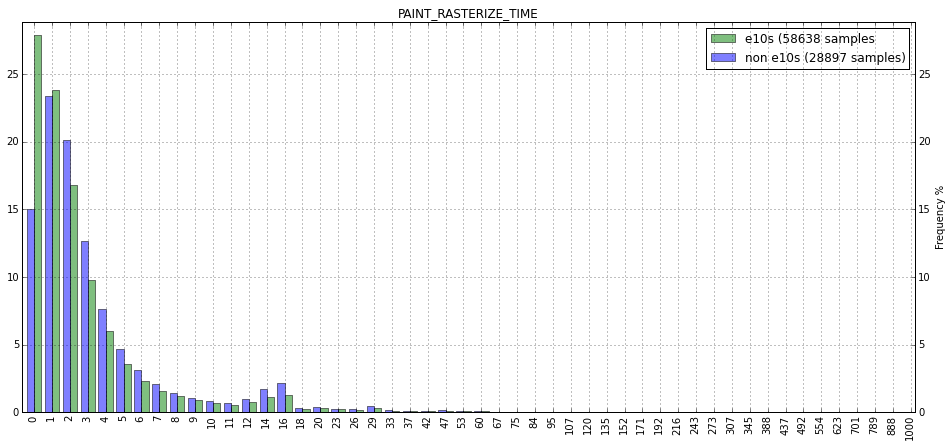

The chi2 distance for MEMORY_VSIZE_MAX_CONTIGUOUS is 0.0278619213453


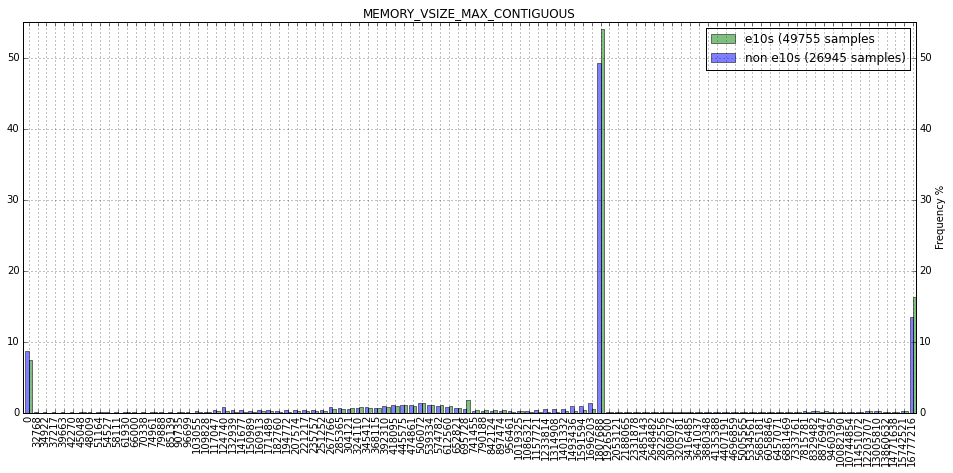

The chi2 distance for STS_NUMBER_OF_ONSOCKETREADY_CALLS is 0.0278286484296


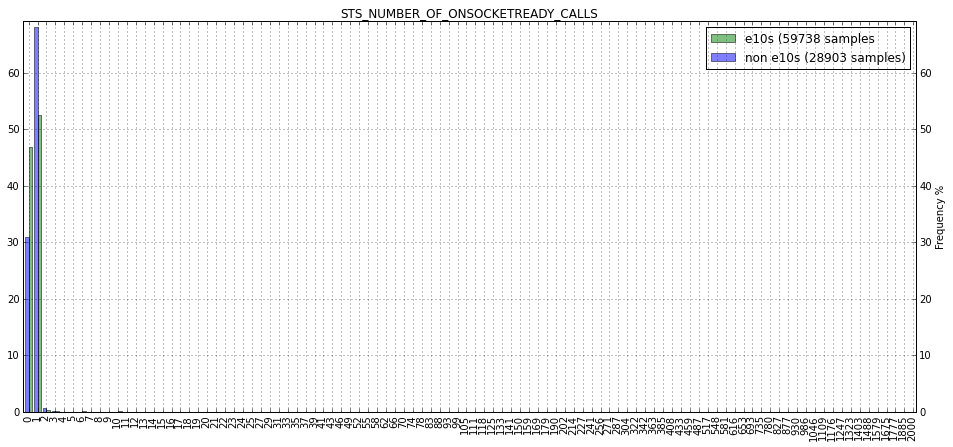

The chi2 distance for PLACES_FAVICON_PNG_SIZES is 0.0275073053952


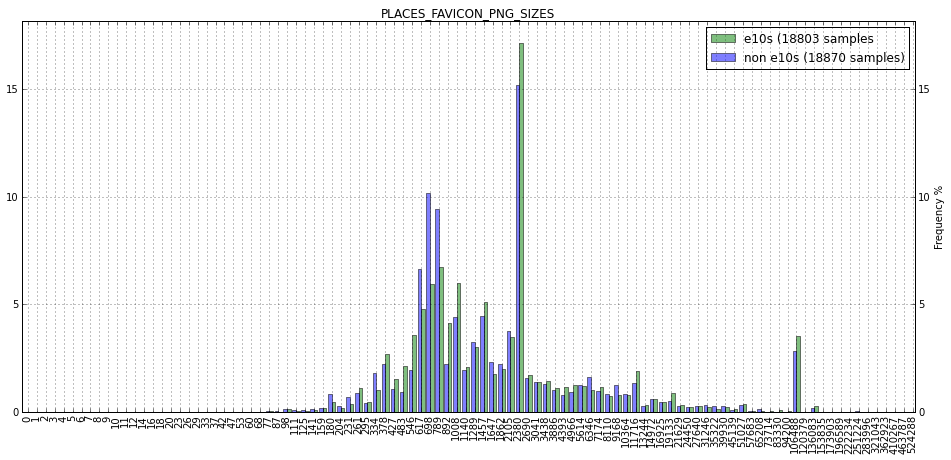

The chi2 distance for AUDIOSTREAM_FIRST_OPEN_MS is 0.0271580964085


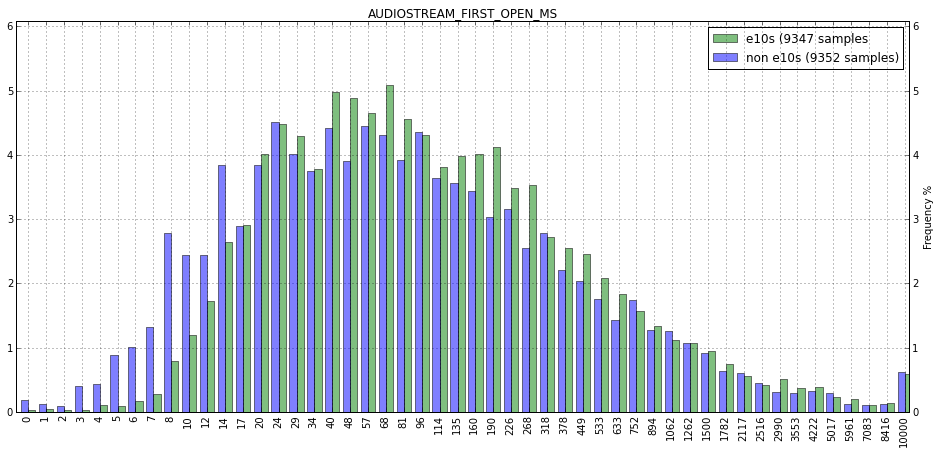

The chi2 distance for HTTP_SUB_COMPLETE_LOAD is 0.0270977089805


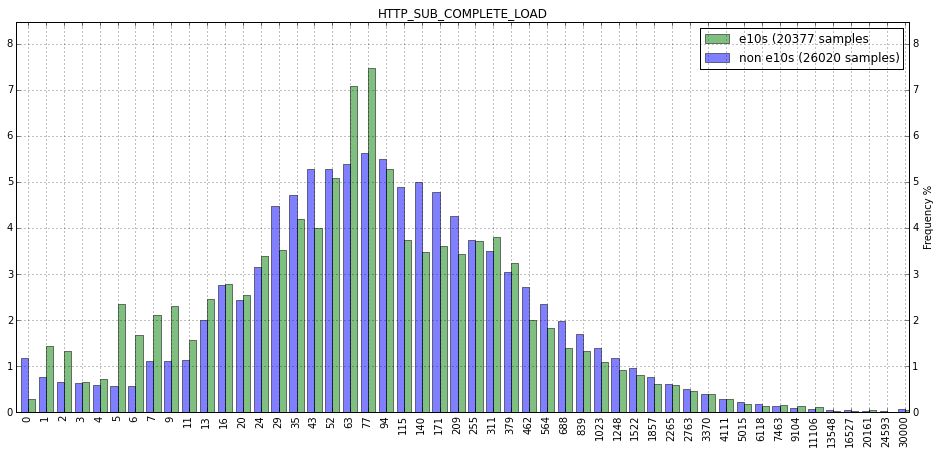

The chi2 distance for HTTP_SUB_COMPLETE_LOAD_CACHED_V2 is 0.0270905014695


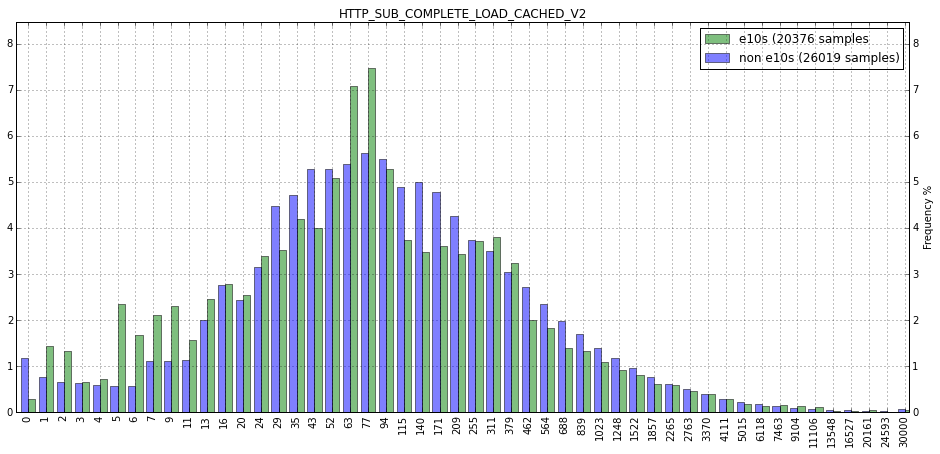

The chi2 distance for HTTP_SUB_OPEN_TO_FIRST_FROM_CACHE_V2 is 0.0264167214017


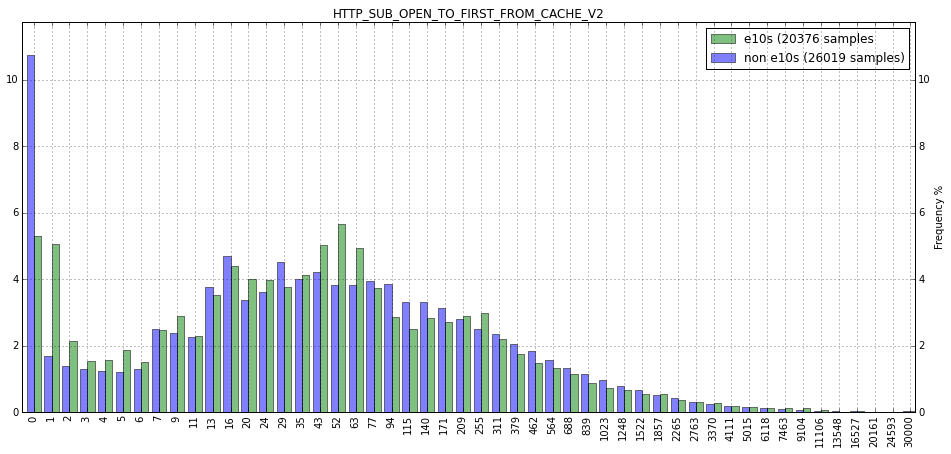

The chi2 distance for FX_PAGE_LOAD_MS is 0.026139498398


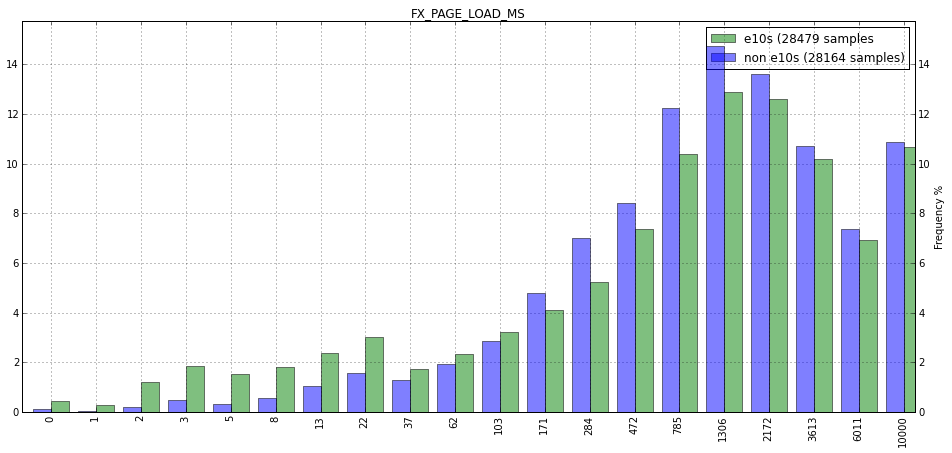

The chi2 distance for GC_SLICE_MS is 0.0259248083298


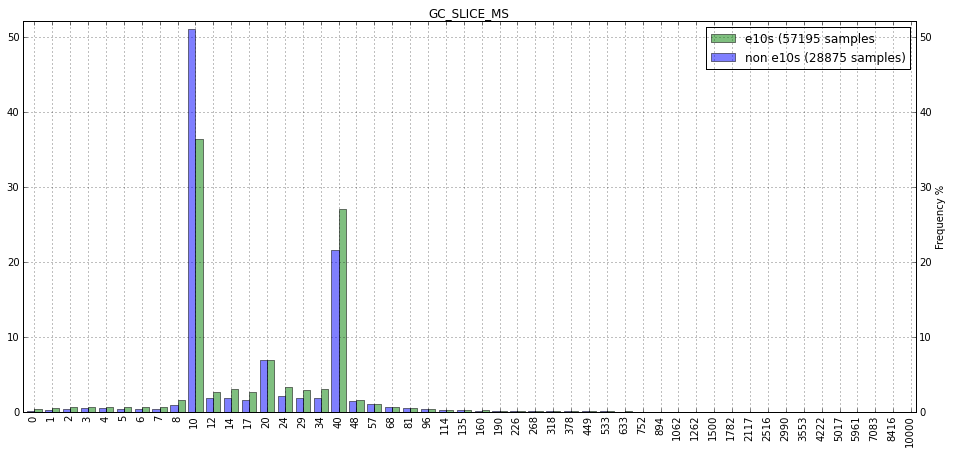

The chi2 distance for HTTP_PAGE_REVALIDATION is 0.0252711894905


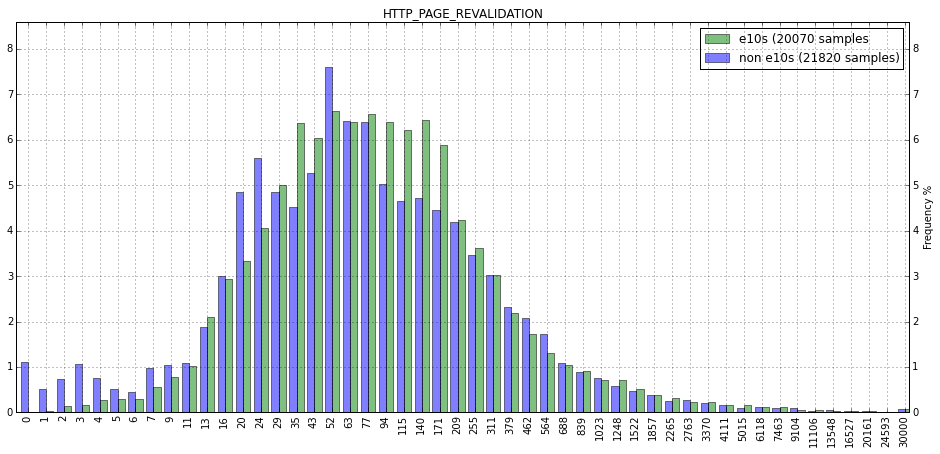

The chi2 distance for GC_BUDGET_MS is 0.0242973826547


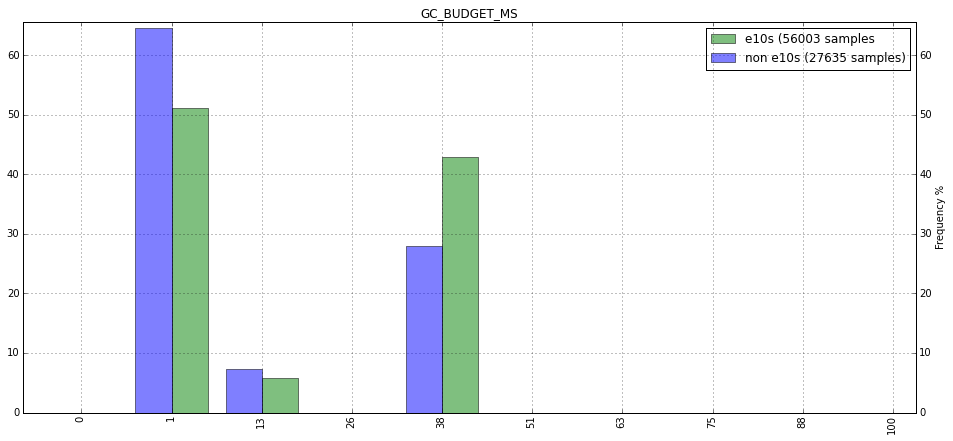

The chi2 distance for GC_SCC_SWEEP_MAX_PAUSE_MS is 0.0230659574234


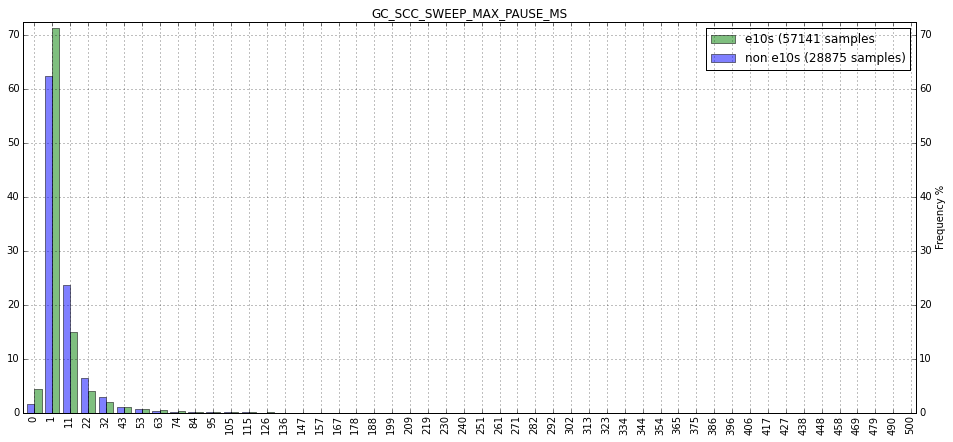

The chi2 distance for NETWORK_CACHE_V2_INPUT_STREAM_STATUS is 0.0227081598259


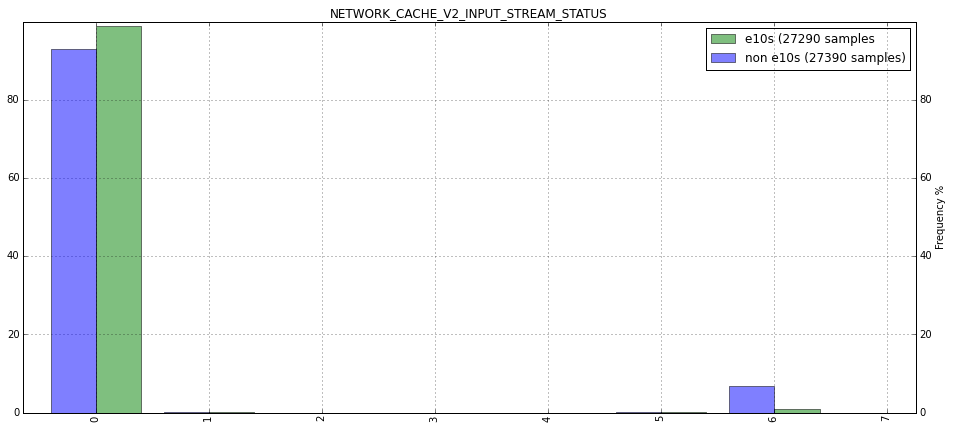

The chi2 distance for PREDICTOR_TOTAL_PRECONNECTS is 0.0210062495103


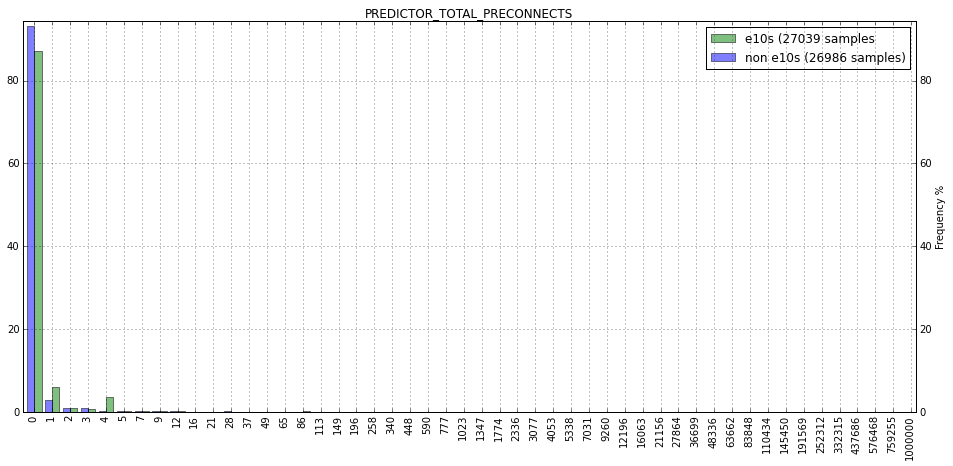

The chi2 distance for HTTP_SUB_OPEN_TO_FIRST_RECEIVED is 0.0208421043509


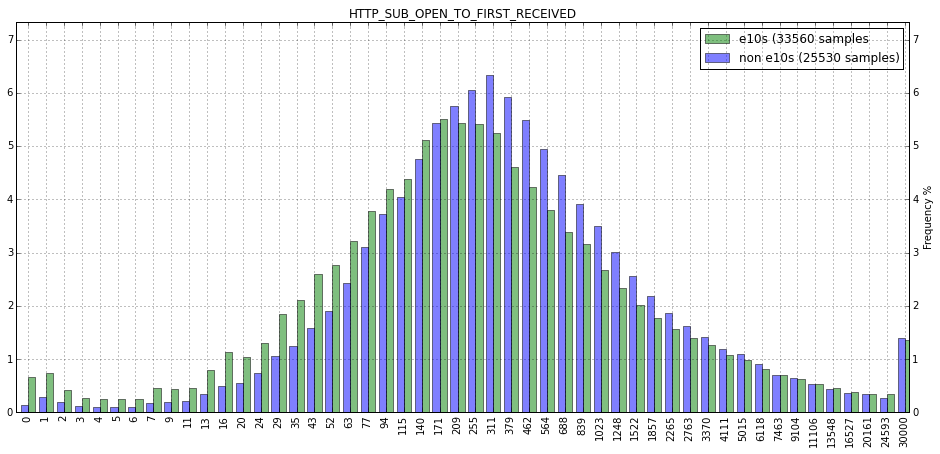

The chi2 distance for LINK_ICON_SIZES_ATTR_DIMENSION is 0.019683807855


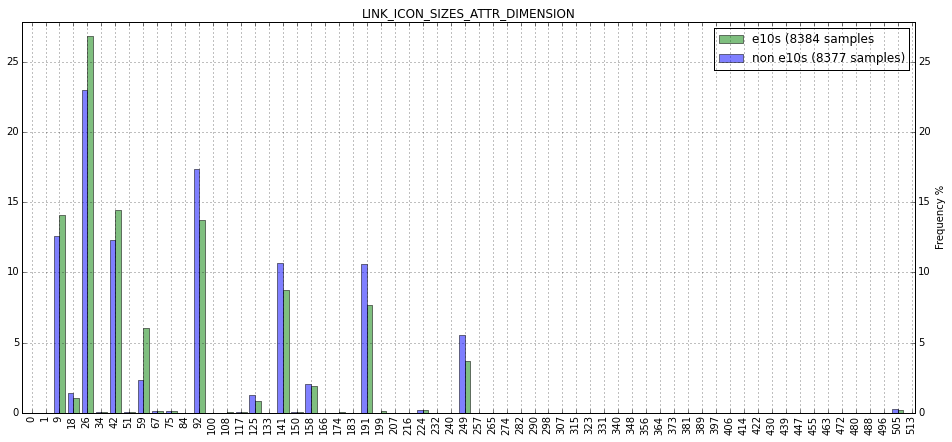

The chi2 distance for FORGET_SKIPPABLE_MAX is 0.0193113925414


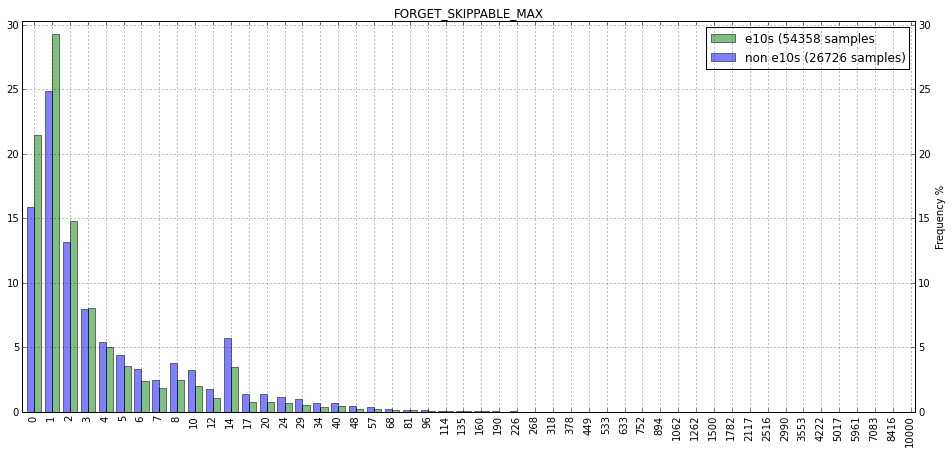

The chi2 distance for HTTP_SUB_COMPLETE_LOAD_V2 is 0.0189851966572


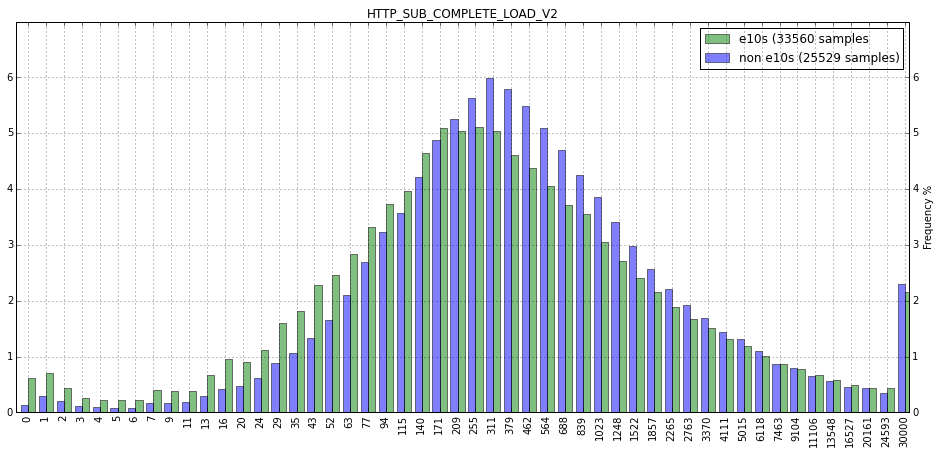

The chi2 distance for HTTP_SUB_COMPLETE_LOAD_NET_V2 is 0.0189851966572


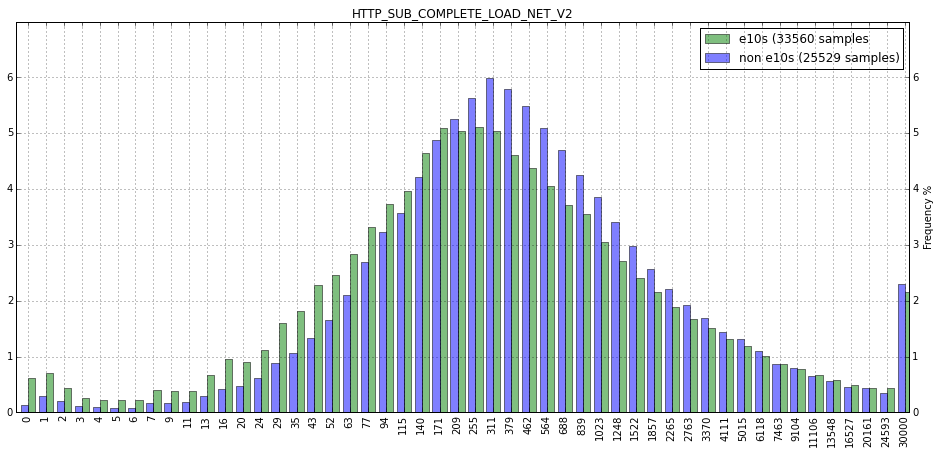

The chi2 distance for COOKIE_SCHEME_SECURITY is 0.018656909829


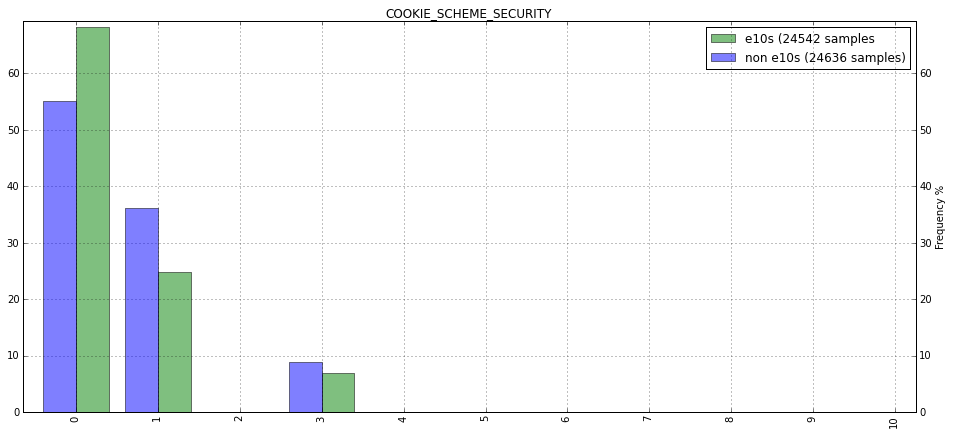

The chi2 distance for PREDICTOR_PREDICT_TIME_TO_ACTION is 0.018015209198


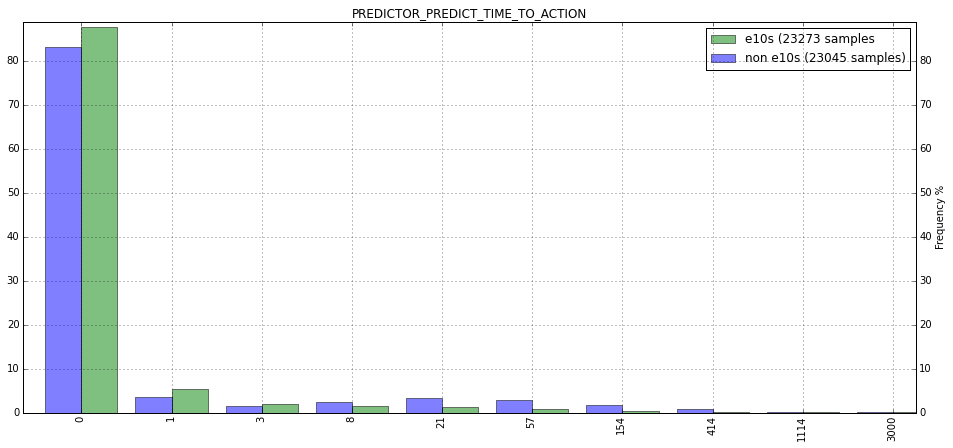

The chi2 distance for CYCLE_COLLECTOR_COLLECTED is 0.0175524803669


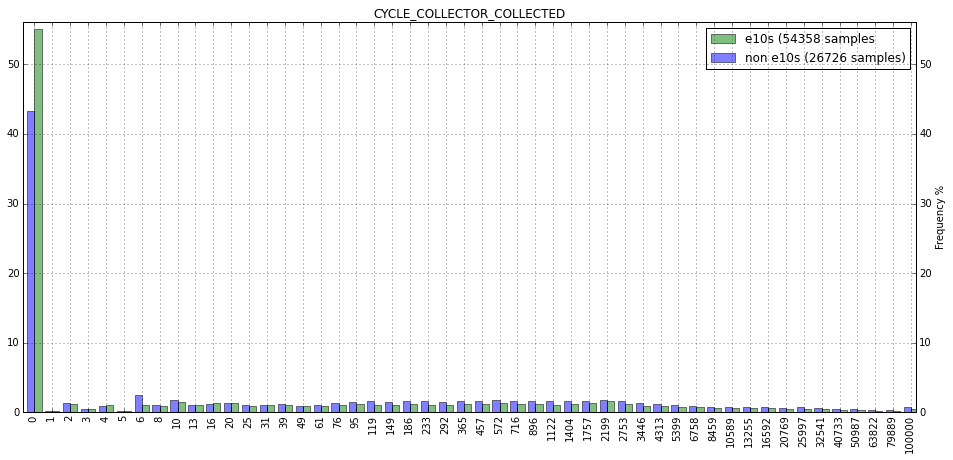

The chi2 distance for MEMORY_IMAGES_CONTENT_USED_UNCOMPRESSED is 0.016881508449


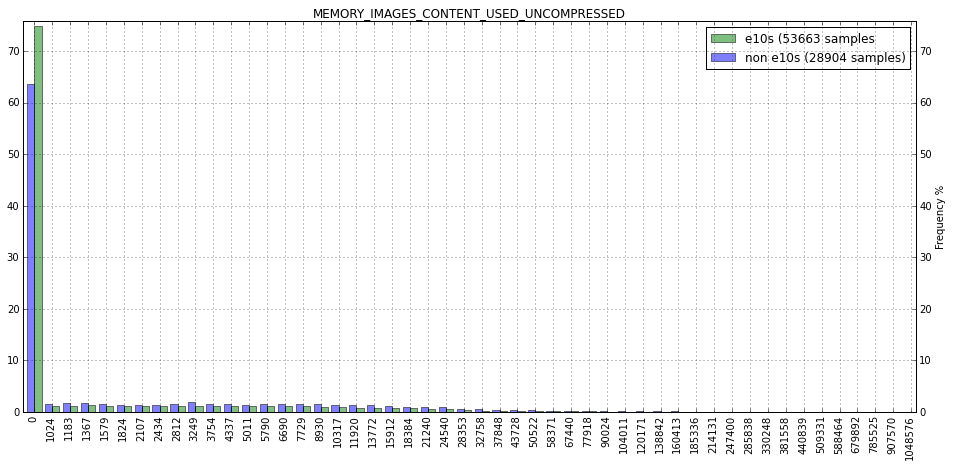

The chi2 distance for FX_THUMBNAILS_STORE_TIME_MS is 0.0163206962469


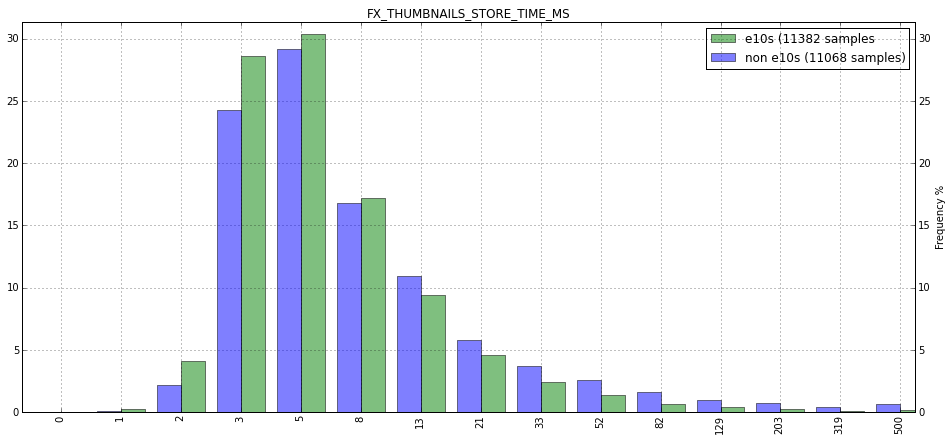

The chi2 distance for PREDICTOR_PREDICT_TIME_TO_INACTION is 0.0156527985527


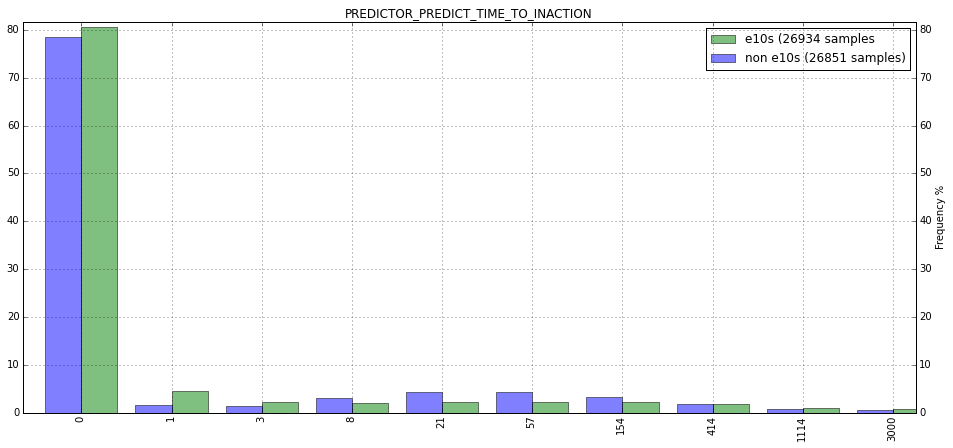

The chi2 distance for PREDICTOR_PREDICT_WORK_TIME is 0.0149149156326


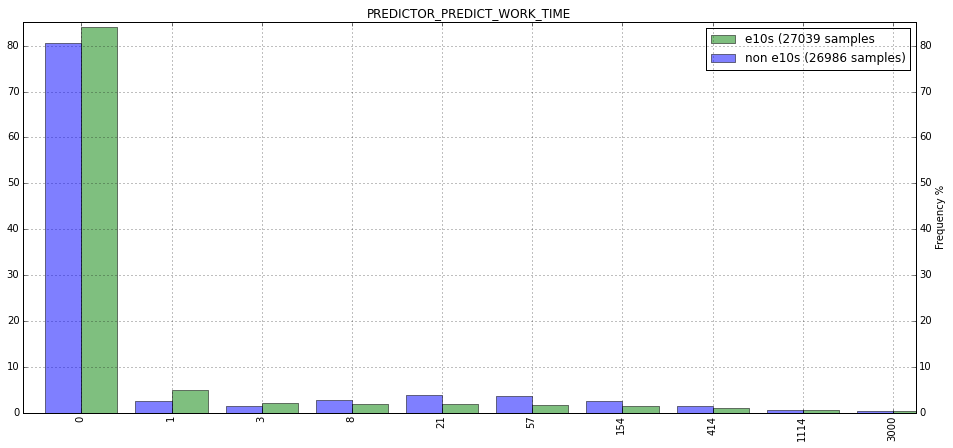

The chi2 distance for HTTP_PAGE_OPEN_TO_FIRST_RECEIVED is 0.0146813534453


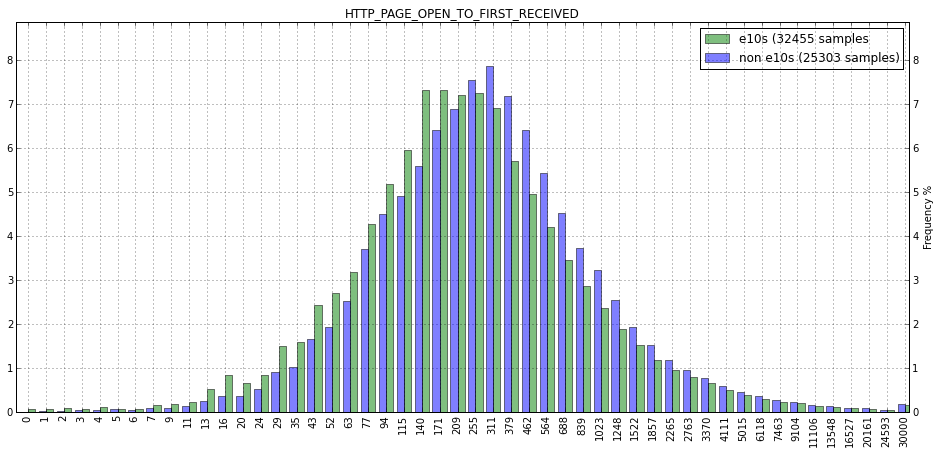

The chi2 distance for [[COUNT]]_CONTENT_DOCUMENTS_DESTROYED is 0.0146205997895


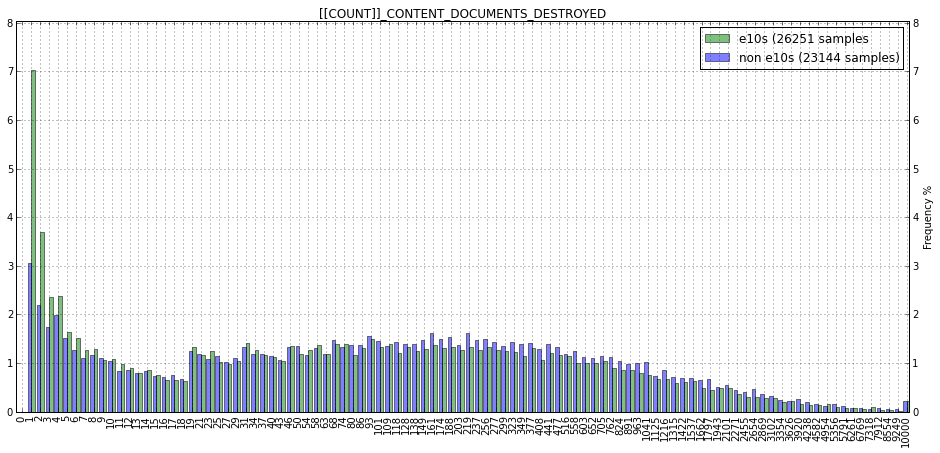

The chi2 distance for PLACES_FAVICON_ICO_SIZES is 0.0146100735093


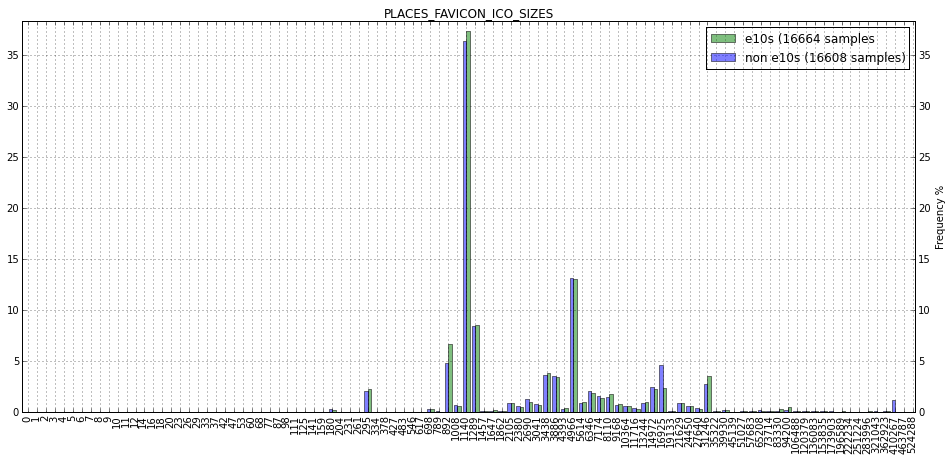

The chi2 distance for CYCLE_COLLECTOR_MAX_PAUSE is 0.0135705953428


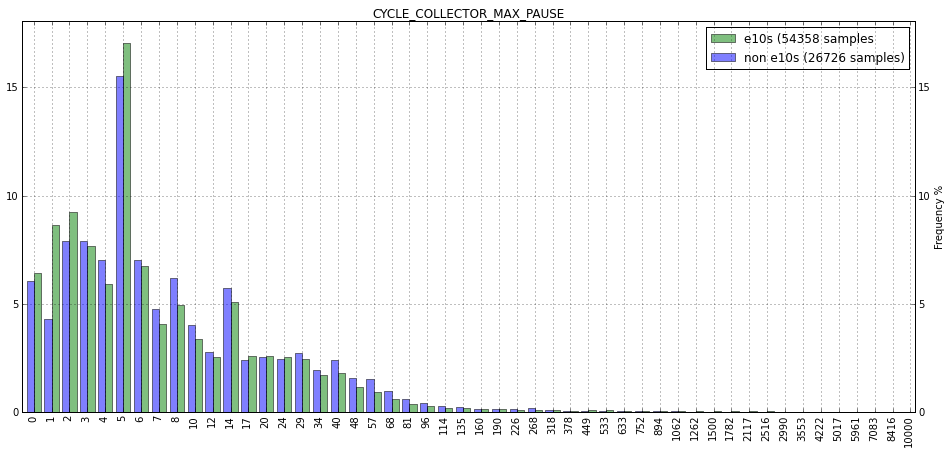

The chi2 distance for NEWTAB_PAGE_LIFE_SPAN is 0.0135643766713


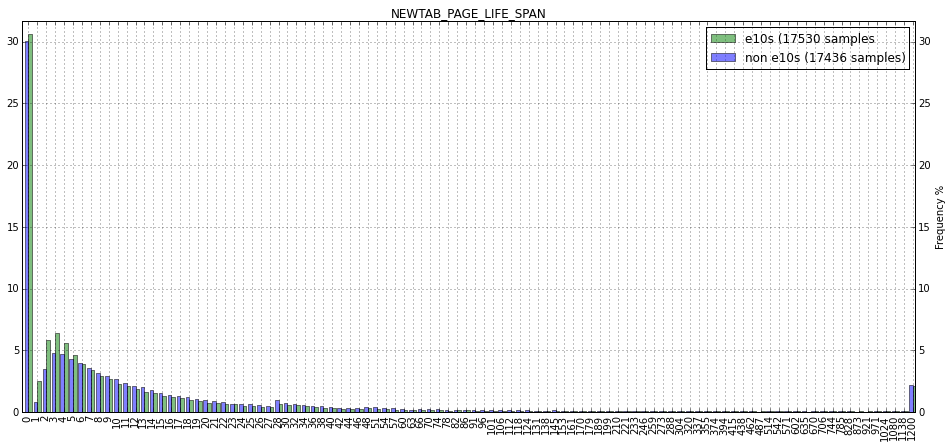

The chi2 distance for FXA_CONFIGURED is 0.0133315718421


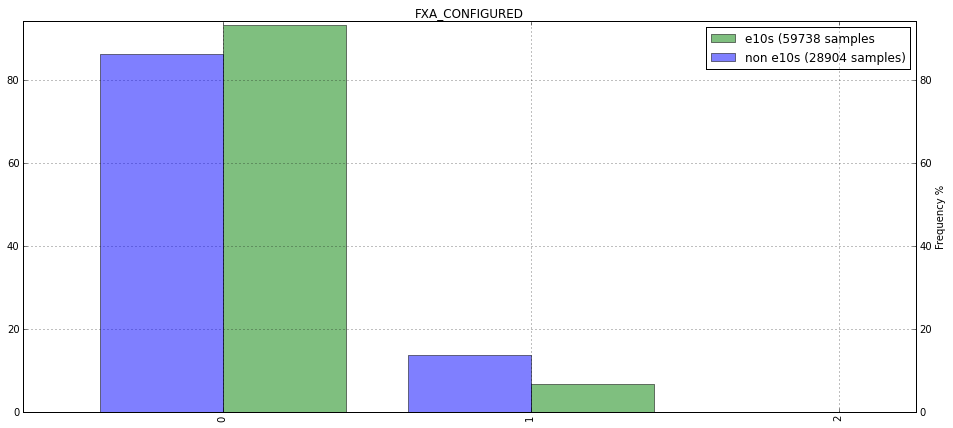

The chi2 distance for GC_SLOW_PHASE is 0.0130234973528


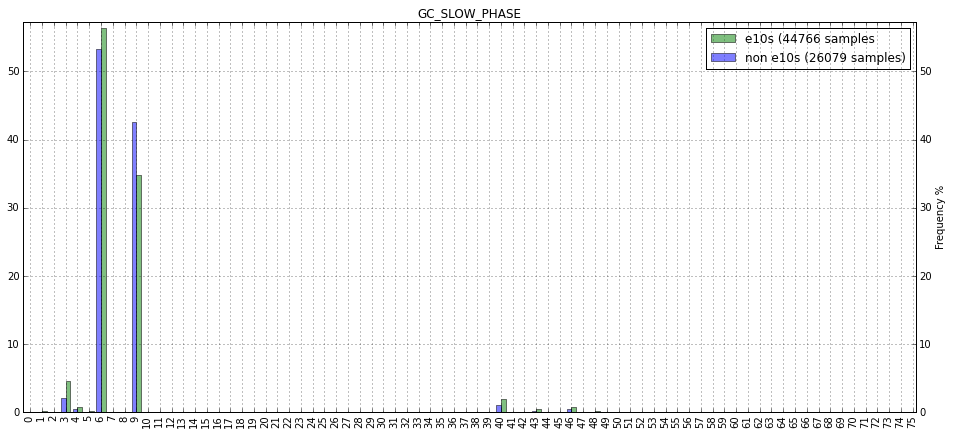

The chi2 distance for HEALTHREPORT_INIT_MS is 0.0128739038075


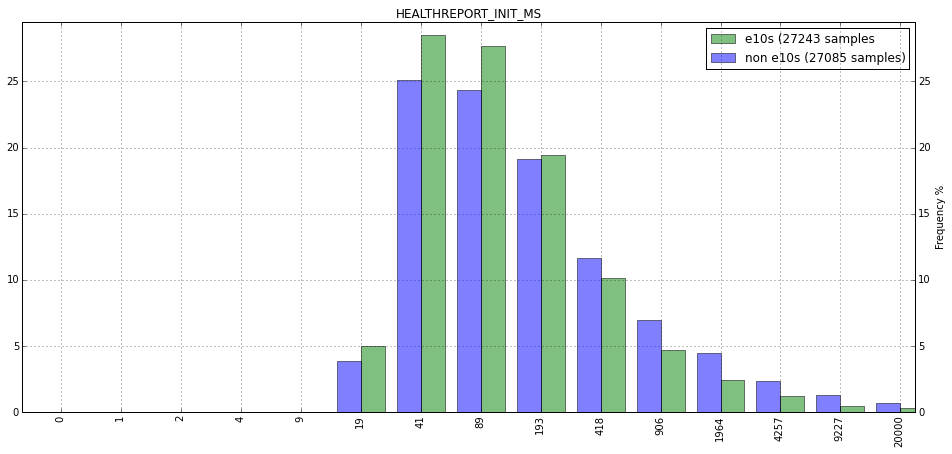

The chi2 distance for FX_SESSION_RESTORE_COLLECT_COOKIES_MS is 0.0127979369311


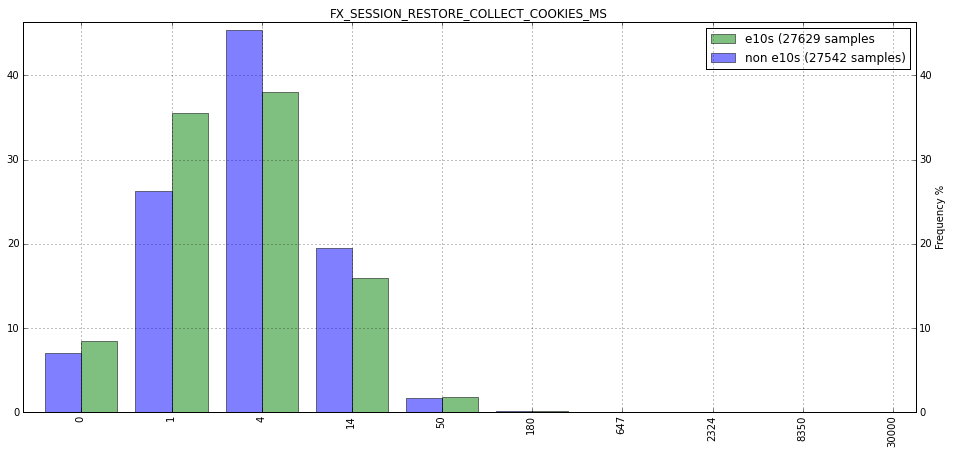

The chi2 distance for GC_ANIMATION_MS is 0.0126047008464


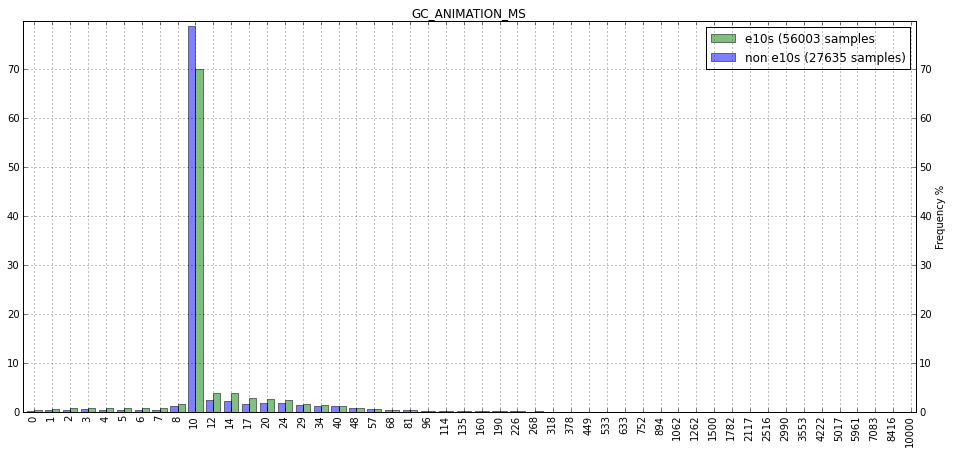

The chi2 distance for HTTP_PAGE_COMPLETE_LOAD_NET_V2 is 0.0122924231327


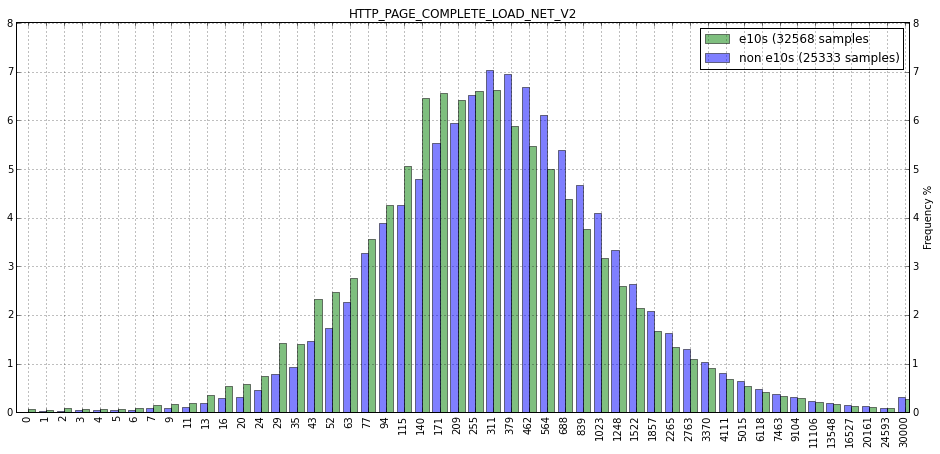

The chi2 distance for HTTP_PAGE_COMPLETE_LOAD_V2 is 0.0122924231327


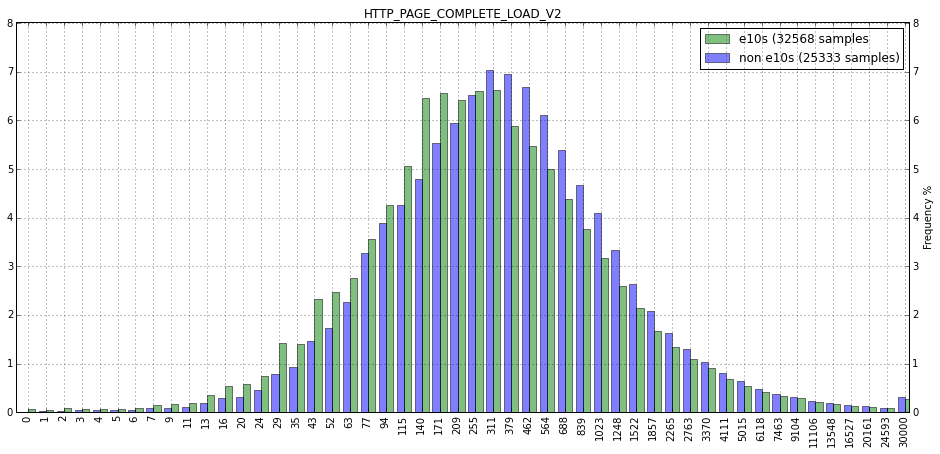

The chi2 distance for WORD_CACHE_HITS_CONTENT is 0.0119662567348


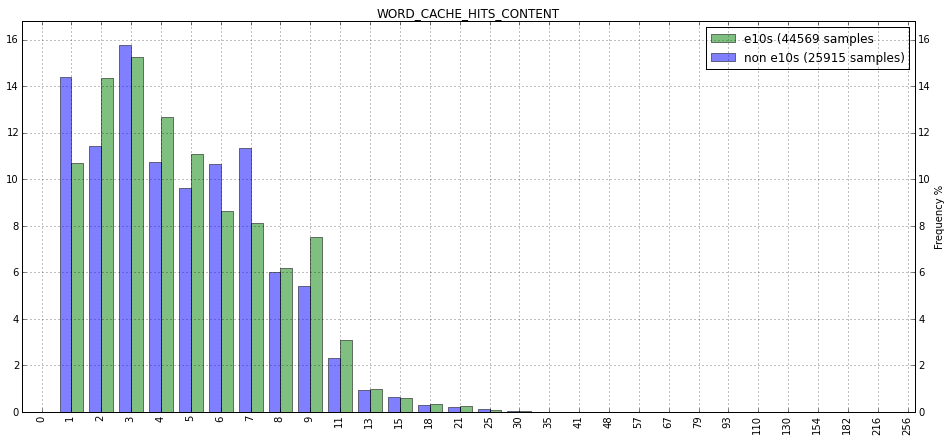

The chi2 distance for FLASH_PLUGIN_AREA is 0.0113964570488


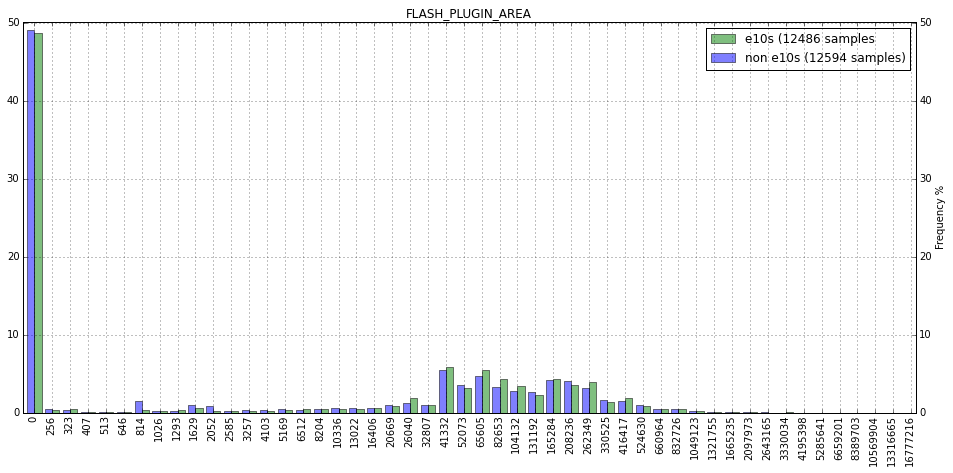

The chi2 distance for TOTAL_CONTENT_PAGE_LOAD_TIME is 0.0111227465151


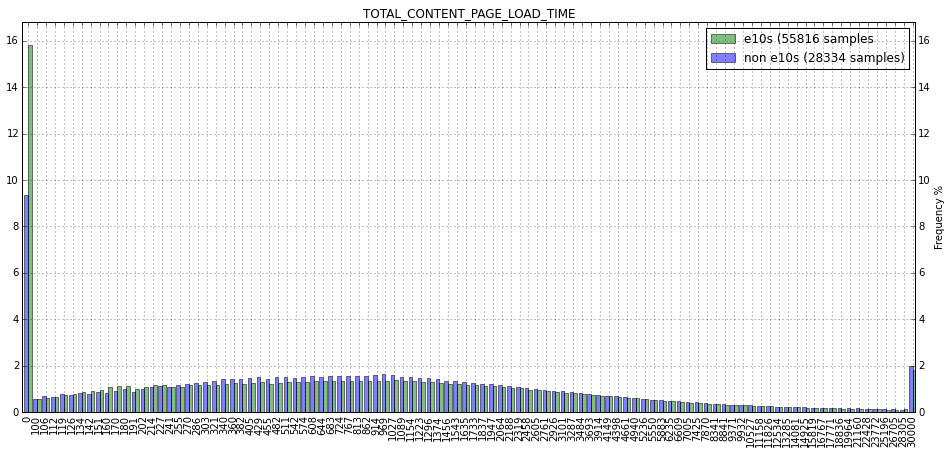

The chi2 distance for [[COUNT]]_JS_TELEMETRY_ADDON_EXCEPTIONS is 0.0110370373465


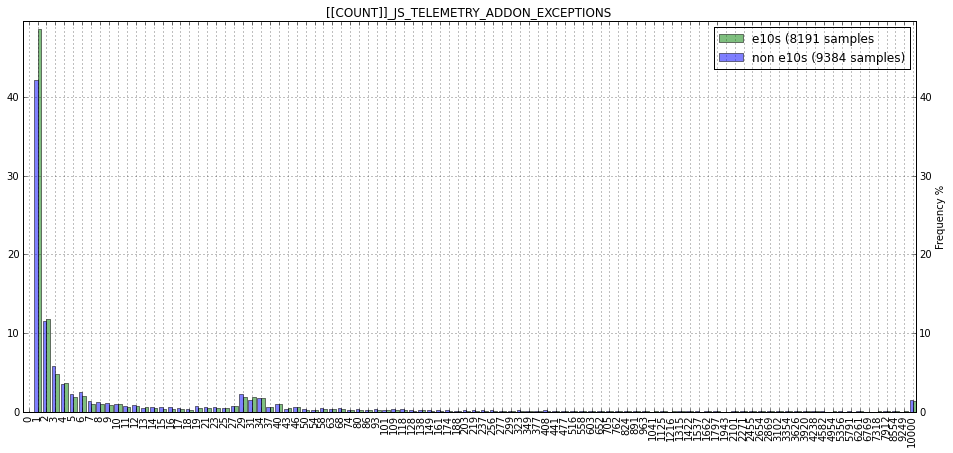

The chi2 distance for CYCLE_COLLECTOR_TIME_BETWEEN is 0.0109387614625


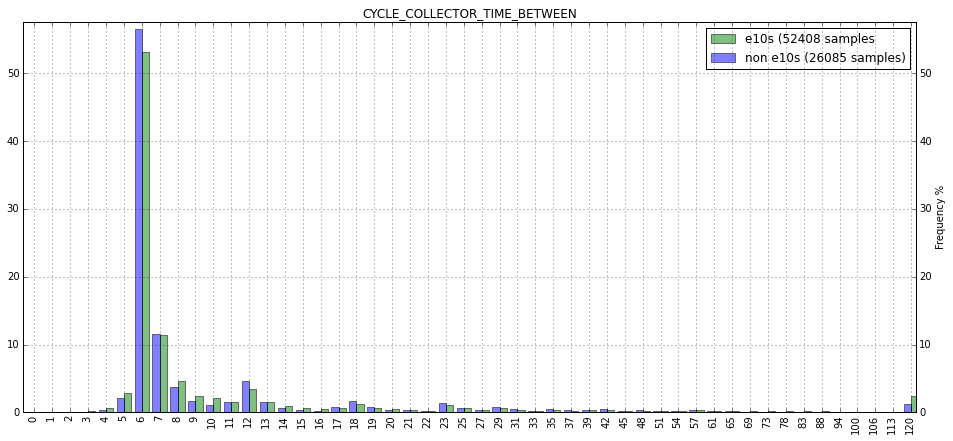

The chi2 distance for URL_PATH_CONTAINS_EXCLAMATION_SLASH is 0.0105145739716


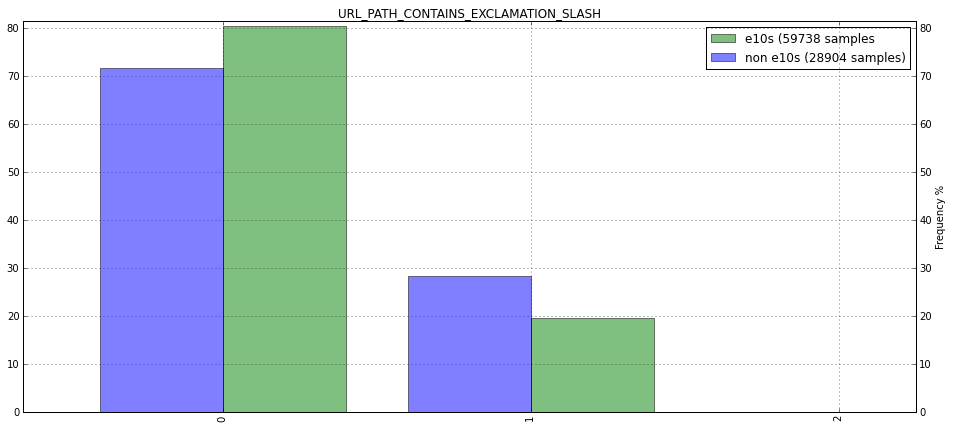

The chi2 distance for PRCONNECT_BLOCKING_TIME_LINK_CHANGE is 0.0103879903169


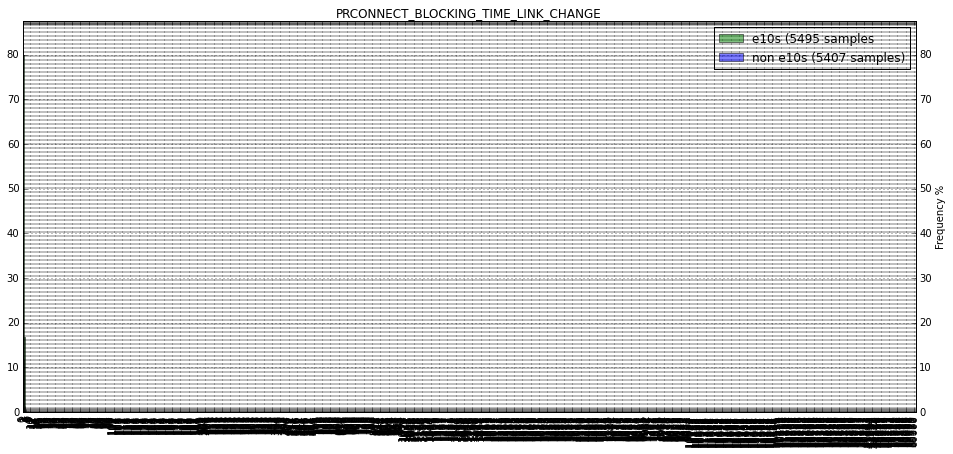

The chi2 distance for HEALTHREPORT_POST_COLLECT_CHECKPOINT_MS is 0.0100738333522


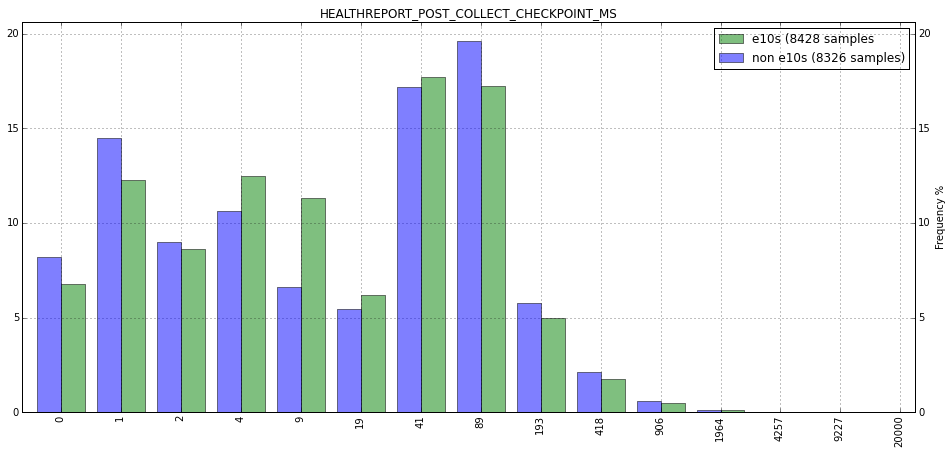

The chi2 distance for CRASH_STORE_COMPRESSED_BYTES is 0.0100529635998


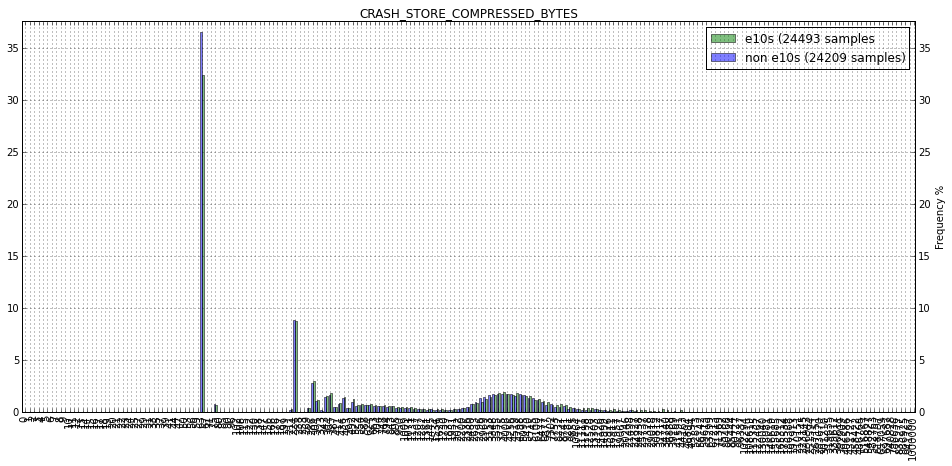

The chi2 distance for NETWORK_CACHE_HIT_MISS_STAT_PER_CACHE_SIZE is 0.0099237152654


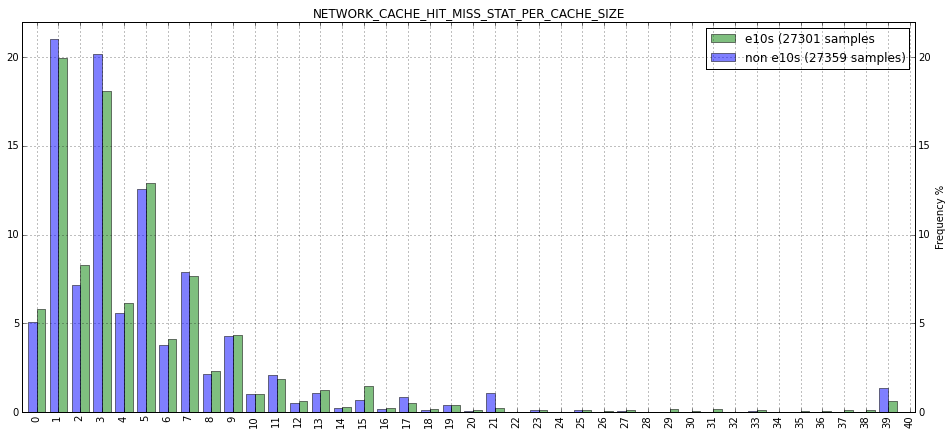

The chi2 distance for HEALTHREPORT_SHUTDOWN_MS is 0.0098161717252


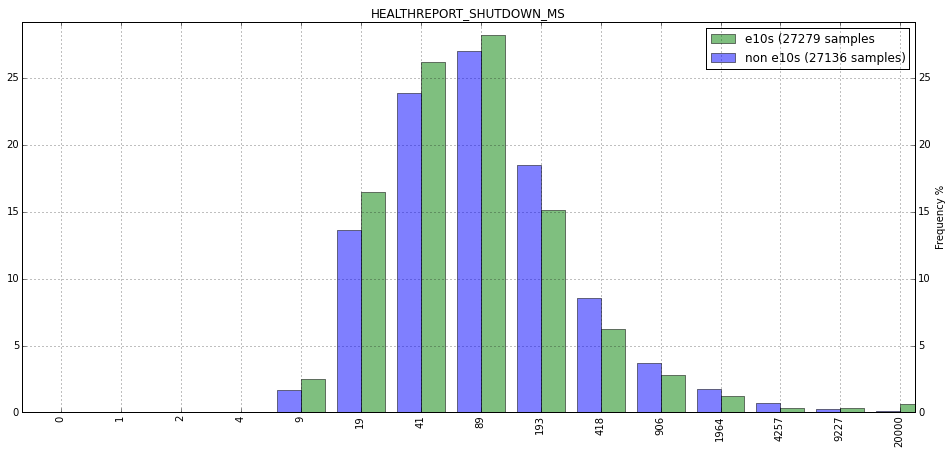

The chi2 distance for PWMGR_FORM_AUTOFILL_RESULT is 0.00965251490111


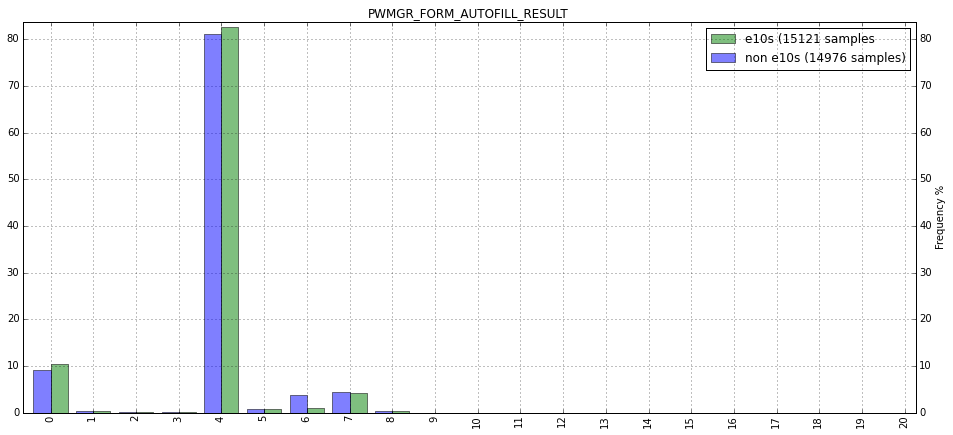

The chi2 distance for NETWORK_CACHE_METADATA_FIRST_READ_TIME_MS is 0.00925494336785


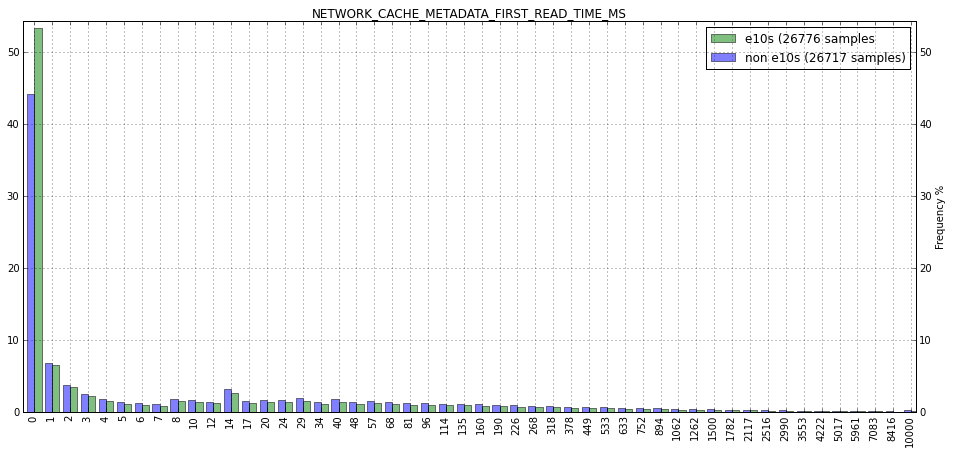

The chi2 distance for WEAVE_CAN_FETCH_KEYS is 0.0091746264774


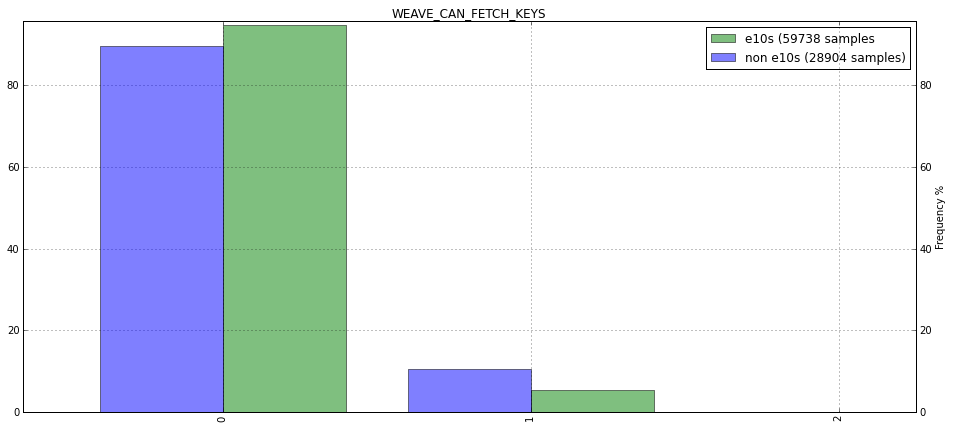

The chi2 distance for GDI_INITFONTLIST_TOTAL is 0.00906618011213


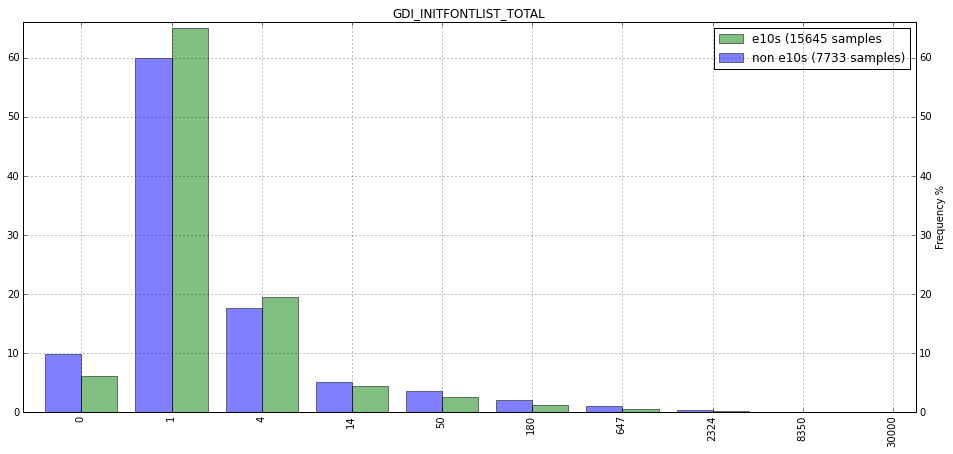

The chi2 distance for MEMORY_STORAGE_SQLITE is 0.00898291262615


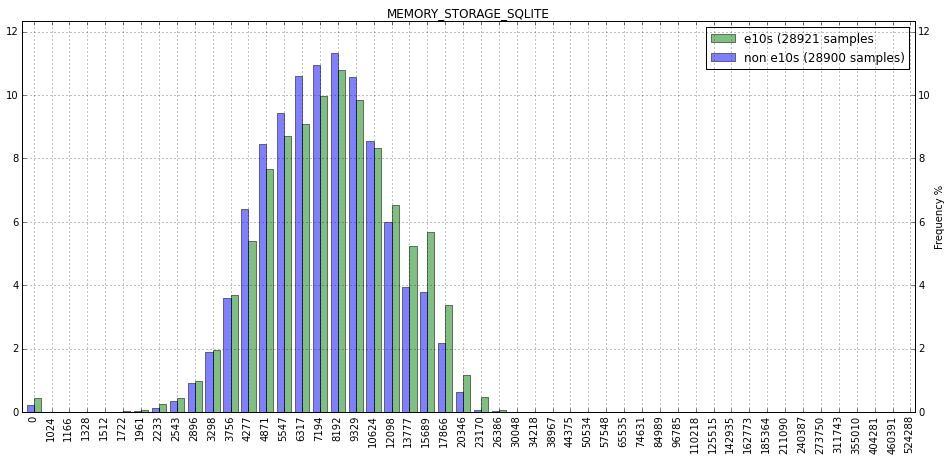

The chi2 distance for STARTUP_TRANSACTION_WAIT_TIME_HTTP is 0.00857253449993


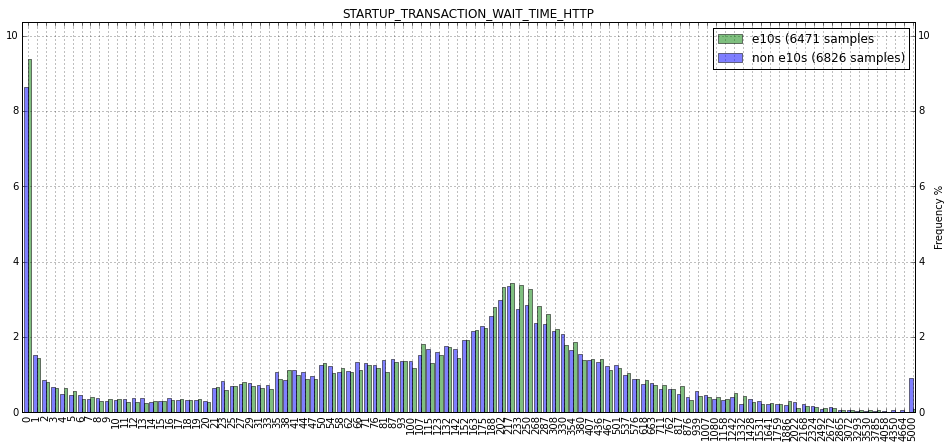

The chi2 distance for HTTP_REQUEST_PER_PAGE is 0.00845010541468


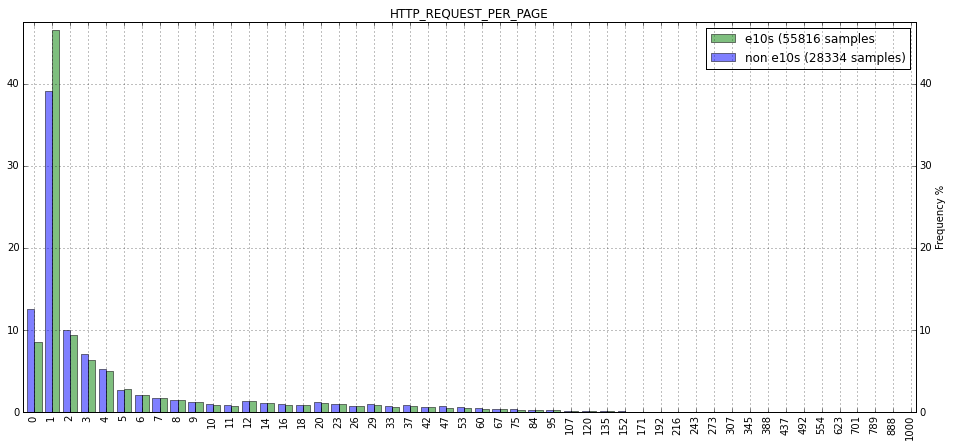

The chi2 distance for URLCLASSIFIER_LOOKUP_TIME is 0.00833068945294


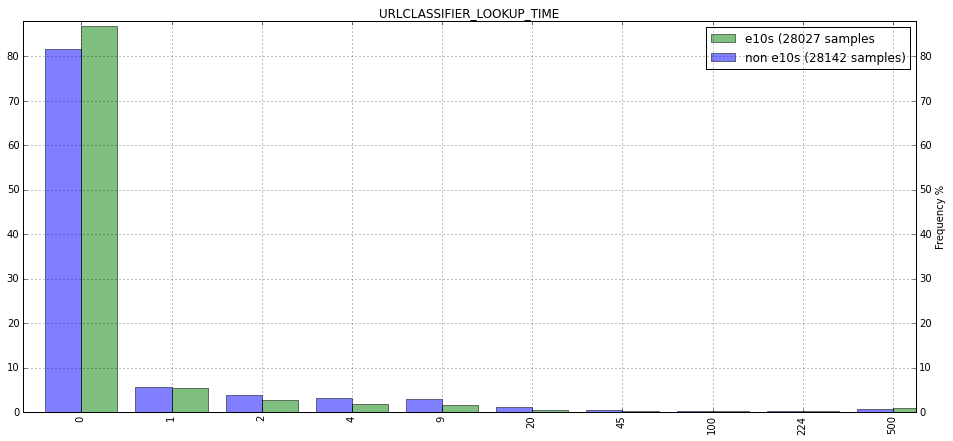

The chi2 distance for HEALTHREPORT_DB_OPEN_MS is 0.0082759157938


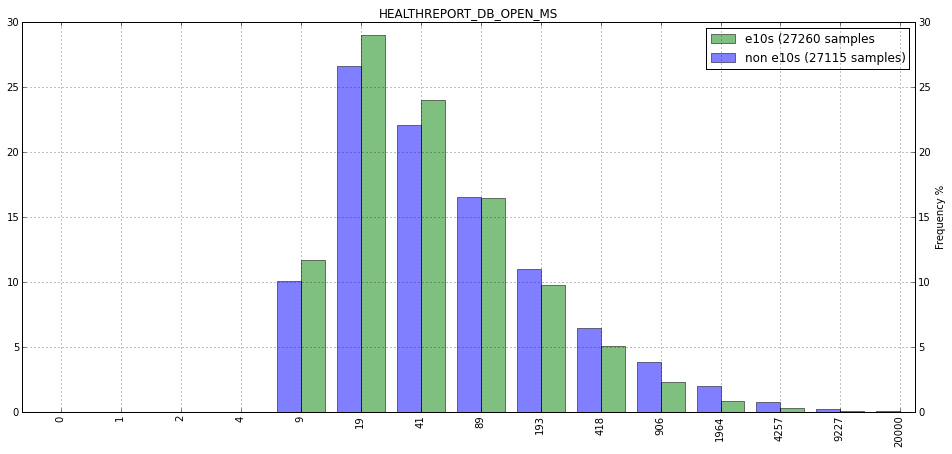

The chi2 distance for NETWORK_CACHE_V2_HIT_TIME_MS is 0.00802530125293


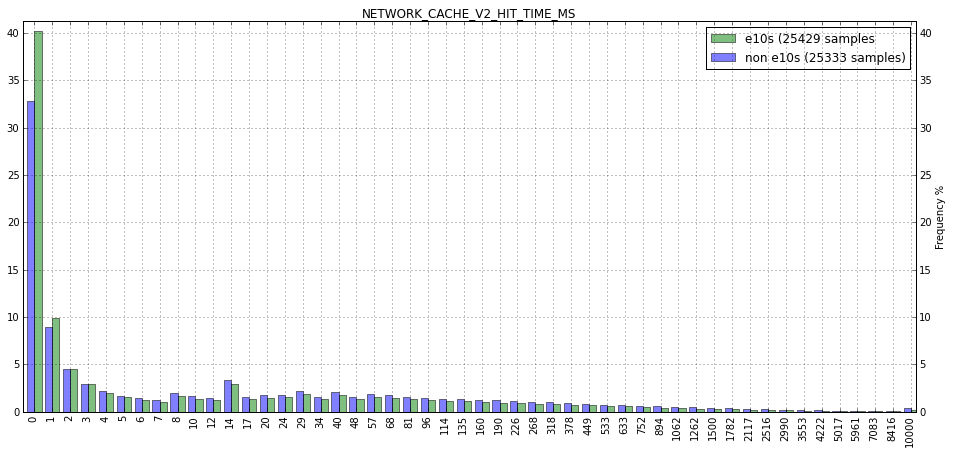

The chi2 distance for STARTUP_HTTP_SCHEME_UPGRADE is 0.00774468289033


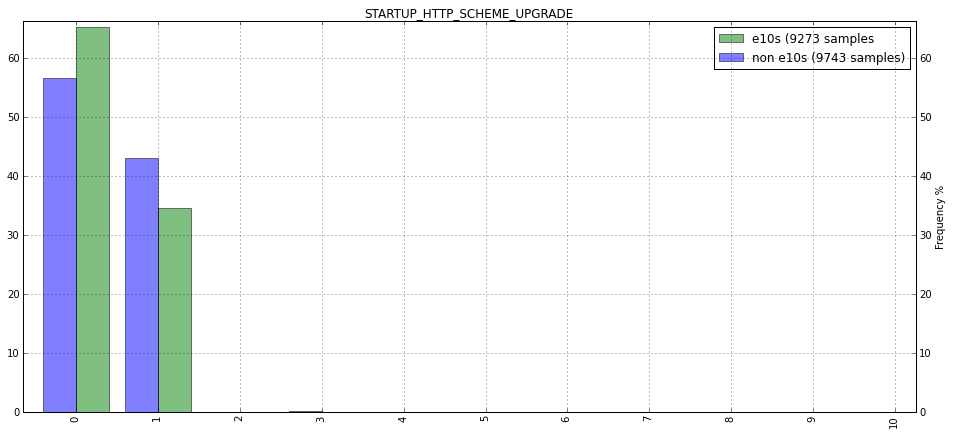

The chi2 distance for DEFERRED_FINALIZE_ASYNC is 0.00731662029138


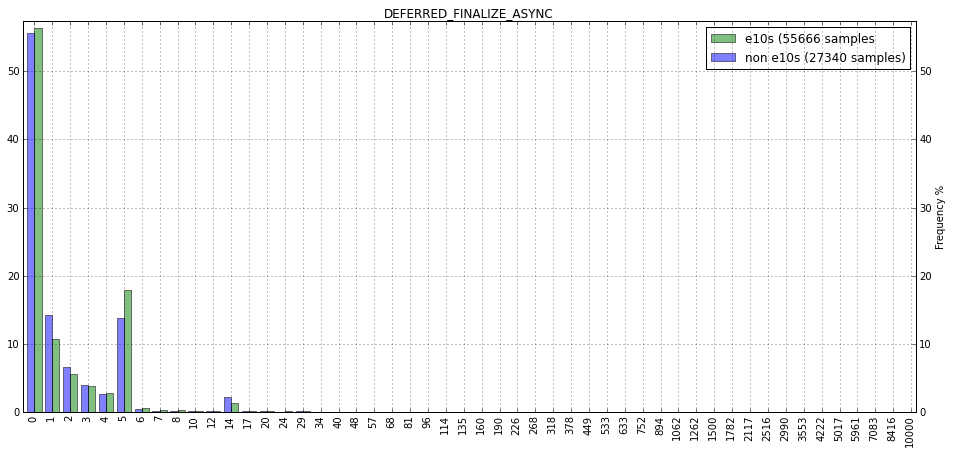

The chi2 distance for TELEMETRY_STRINGIFY is 0.00720461639384


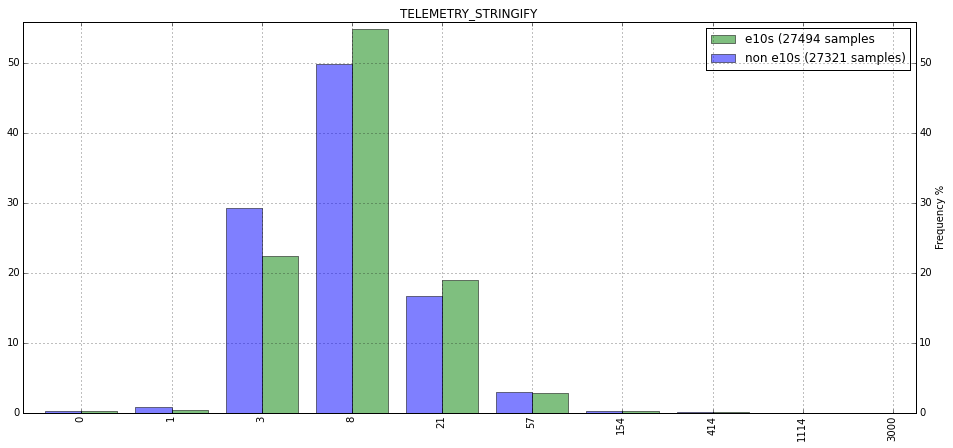

The chi2 distance for CERT_VALIDATION_HTTP_REQUEST_SUCCEEDED_TIME is 0.00712828330622


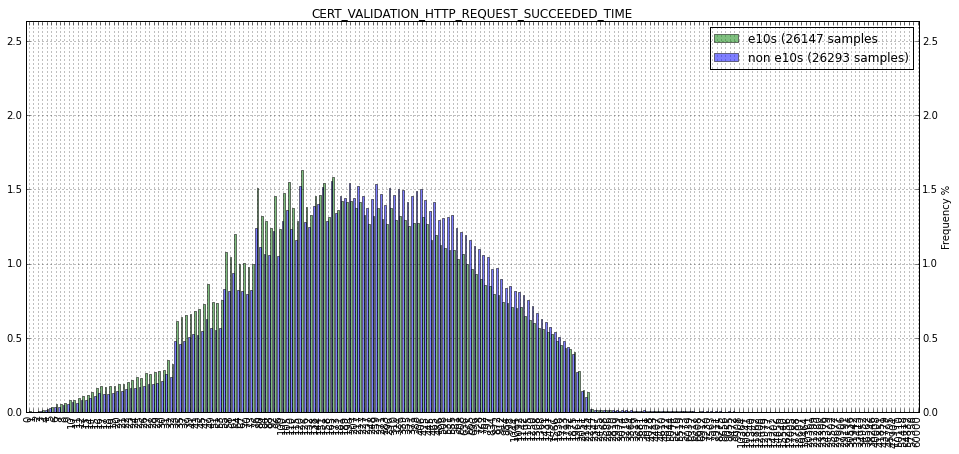

The chi2 distance for HEALTHREPORT_GENERATE_JSON_PAYLOAD_MS is 0.00691012200135


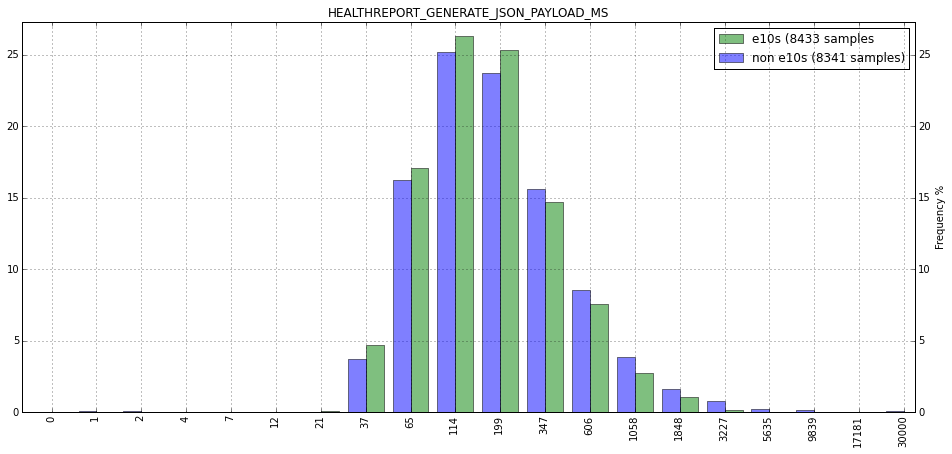

The chi2 distance for DWRITEFONT_DELAYEDINITFONTLIST_TOTAL is 0.00689681870726


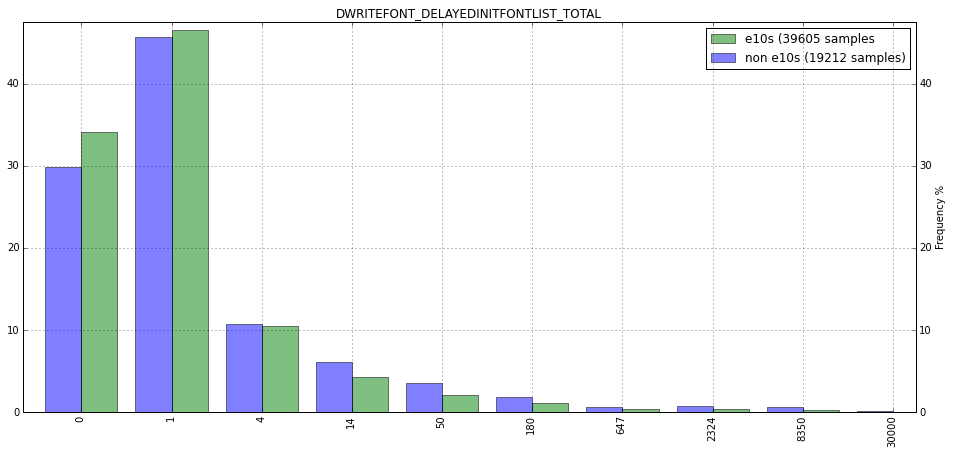

The chi2 distance for FX_SESSION_RESTORE_COLLECT_DATA_MS is 0.00687800222202


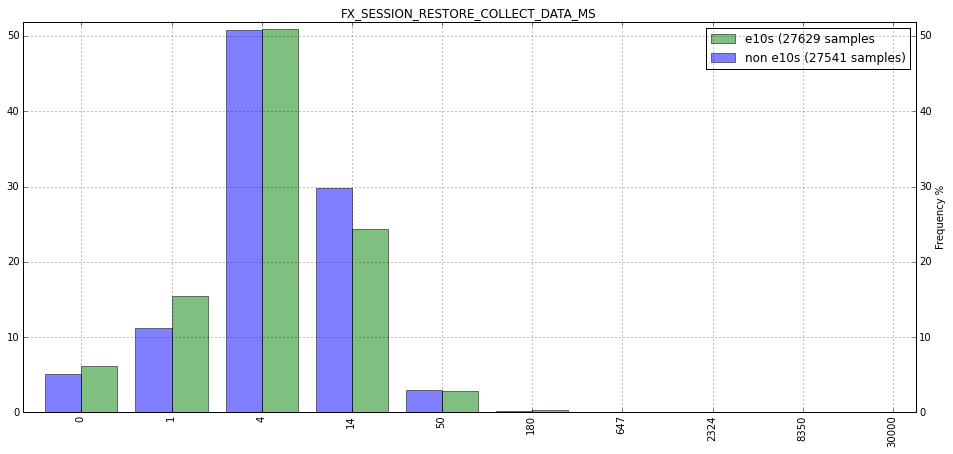

The chi2 distance for FX_SESSION_RESTORE_COLLECT_DATA_LONGEST_OP_MS is 0.00685763601466


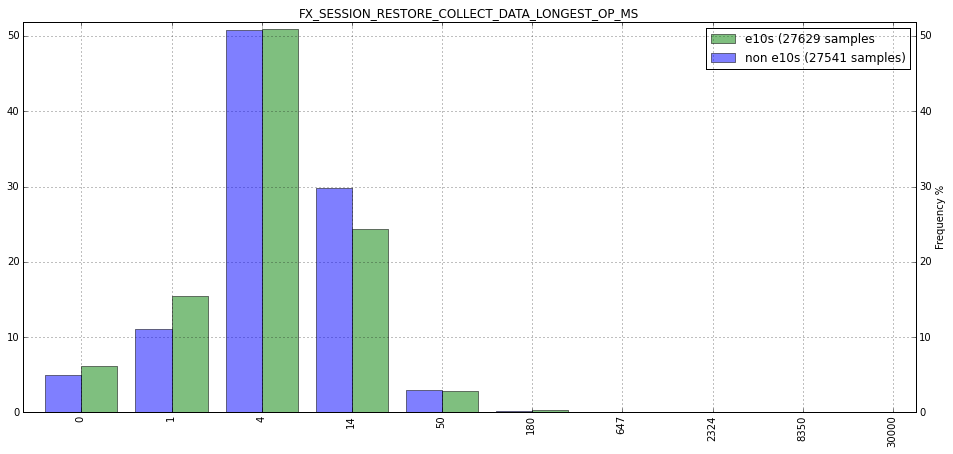

The chi2 distance for PREDICTOR_TOTAL_PREDICTIONS is 0.0067286114837


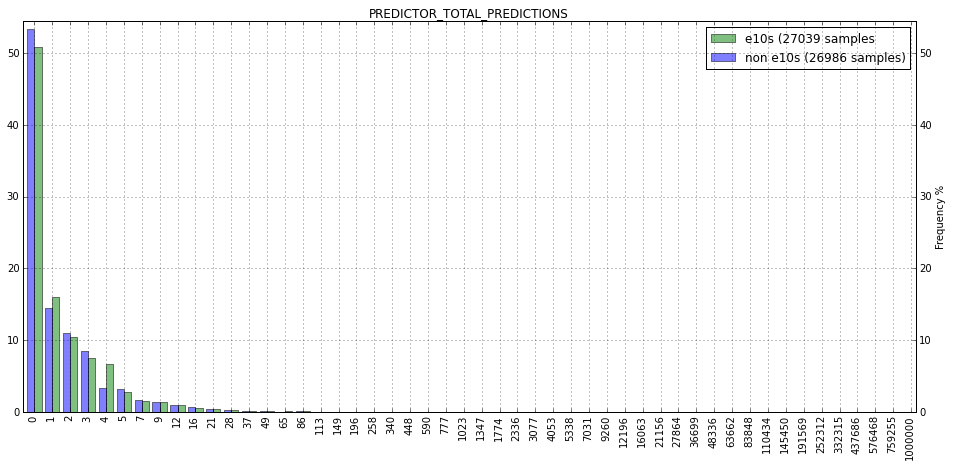

The chi2 distance for SIMPLE_MEASURES_STARTUPSESSIONRESTOREWRITEBYTES is 0.0062667128855


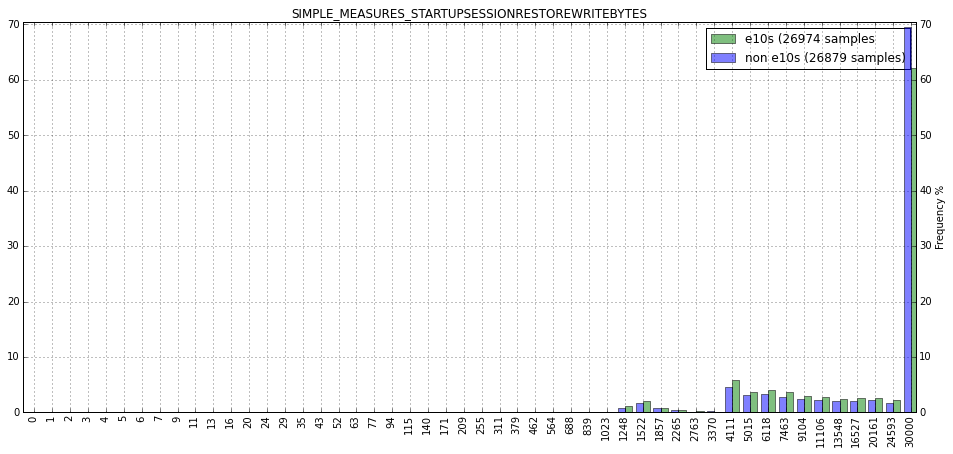

The chi2 distance for MOZ_SQLITE_OTHER_SYNC_MS is 0.00622682881546


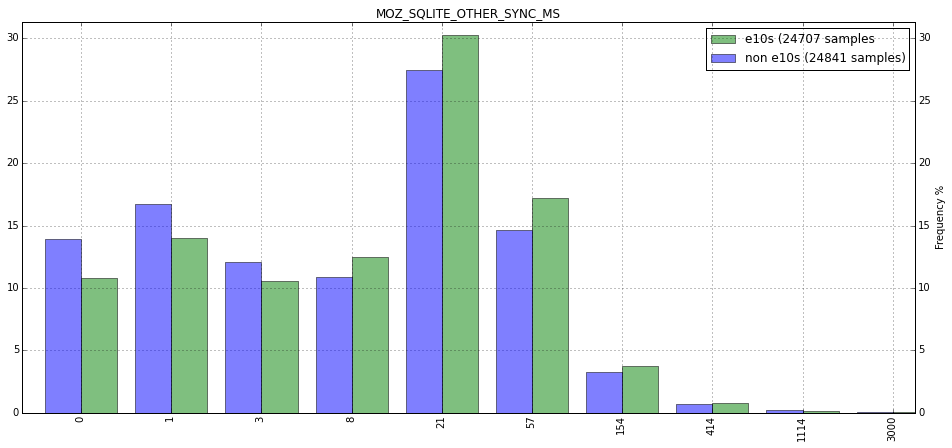

The chi2 distance for HTTP_CACHE_DISPOSITION_2_V2 is 0.00622304945585


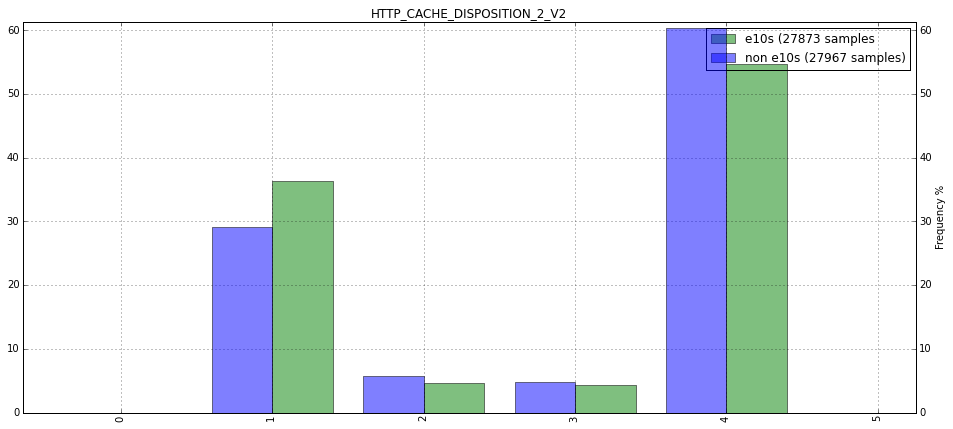

The chi2 distance for STS_POLL_AND_EVENT_THE_LAST_CYCLE is 0.00601373218202


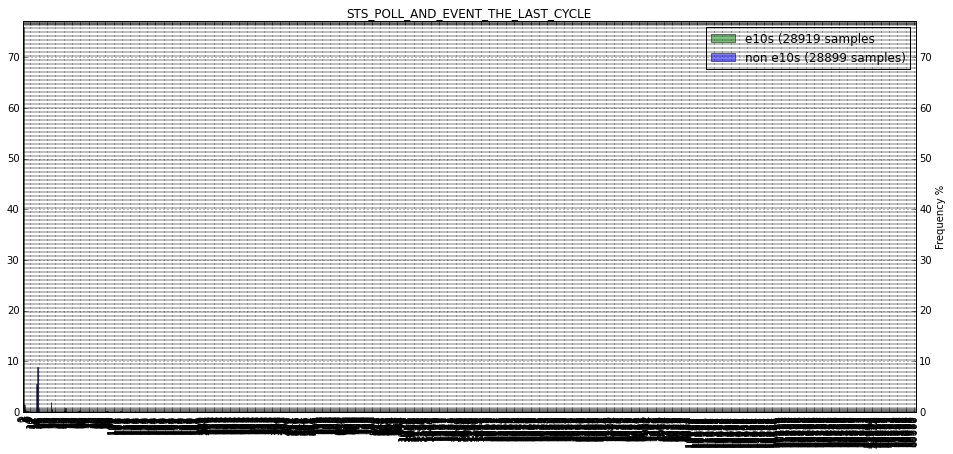

The chi2 distance for FX_TAB_ANIM_OPEN_PREVIEW_FRAME_INTERVAL_MS is 0.00592348582002


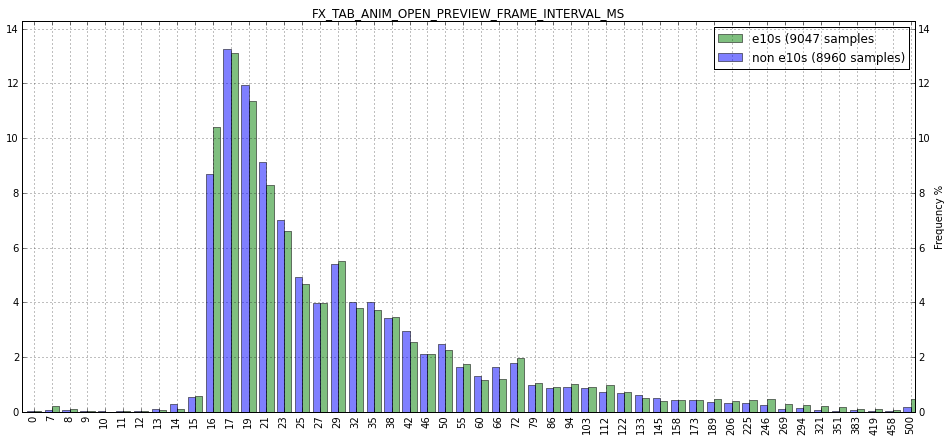

The chi2 distance for STARTUP_DNS_RENEWAL_TIME_FOR_TTL is 0.00574683872333


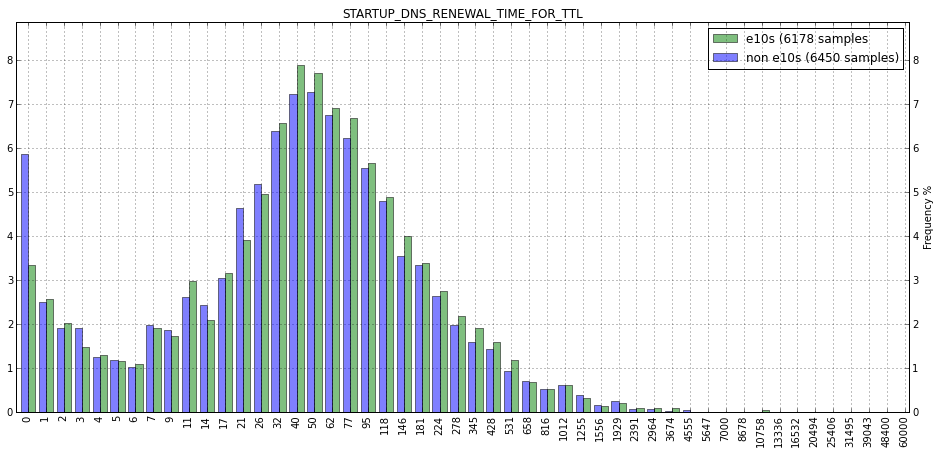

The chi2 distance for STARTUP_DNS_LOOKUP_METHOD2 is 0.00563293668171


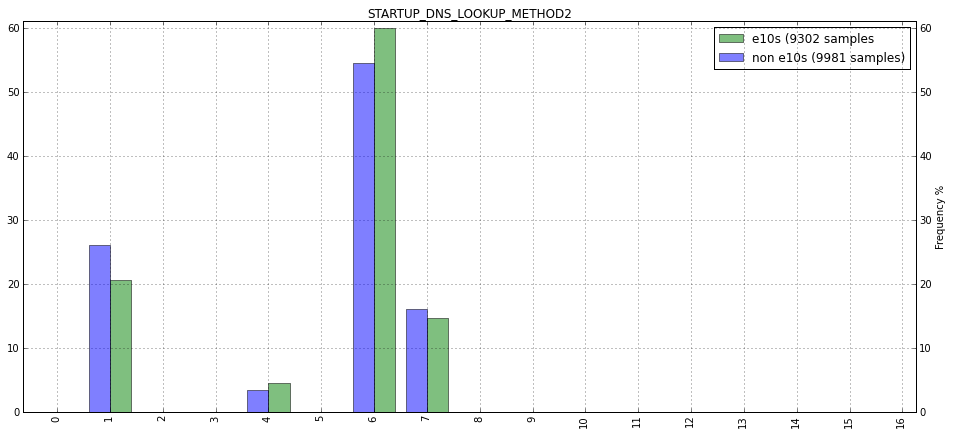

The chi2 distance for [[COUNT]]_PLUGIN_ACTIVATION_COUNT is 0.00556021460677


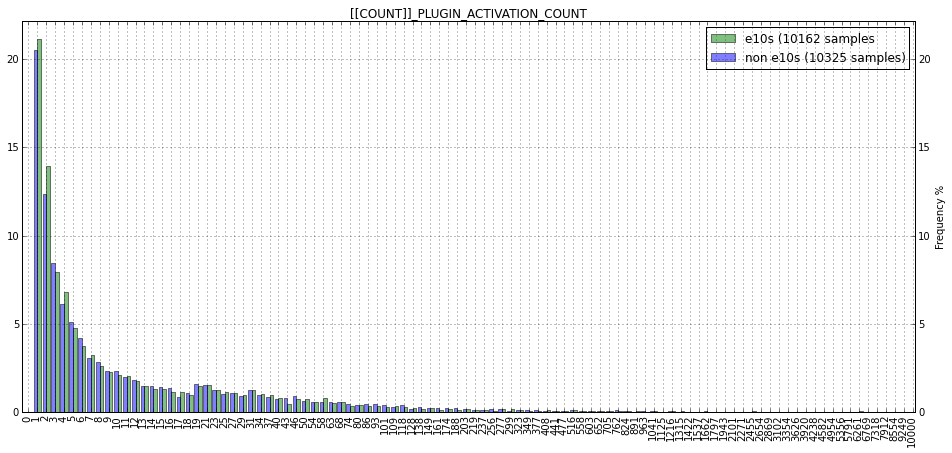

The chi2 distance for TELEMETRY_PENDING_PINGS_AGE is 0.00548740899604


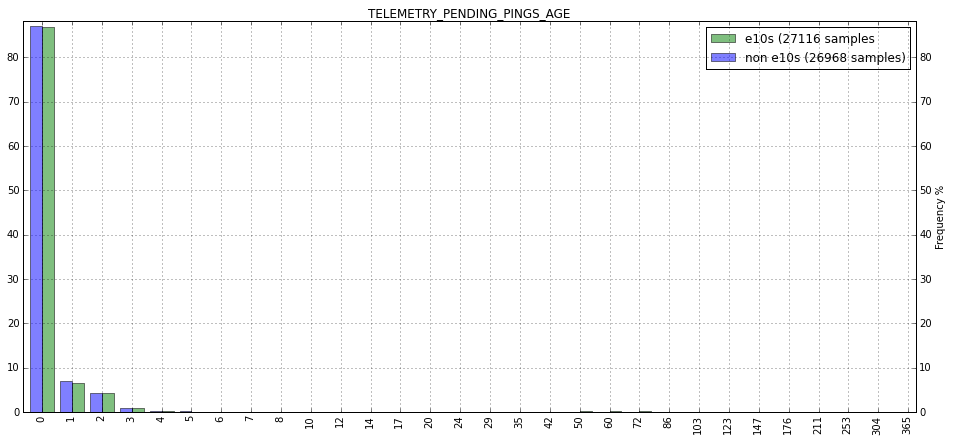

The chi2 distance for GRADIENT_DURATION is 0.00546897707985


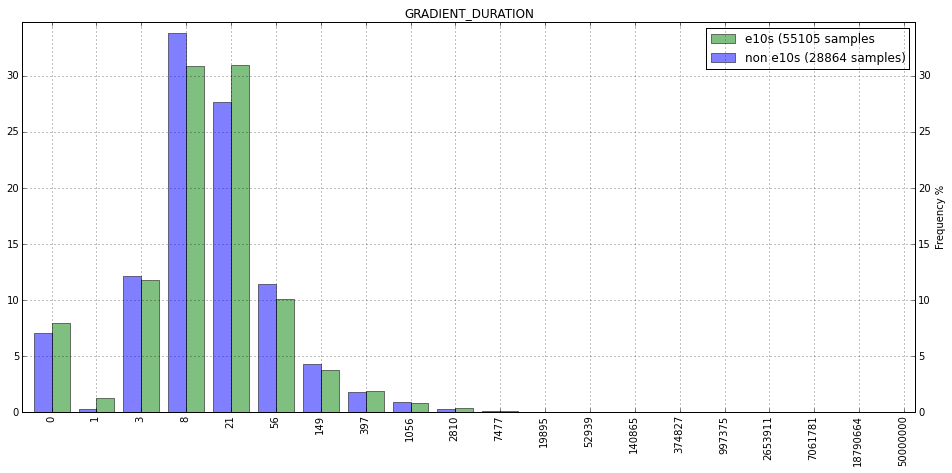

The chi2 distance for FLASH_PLUGIN_WIDTH is 0.00545140954137


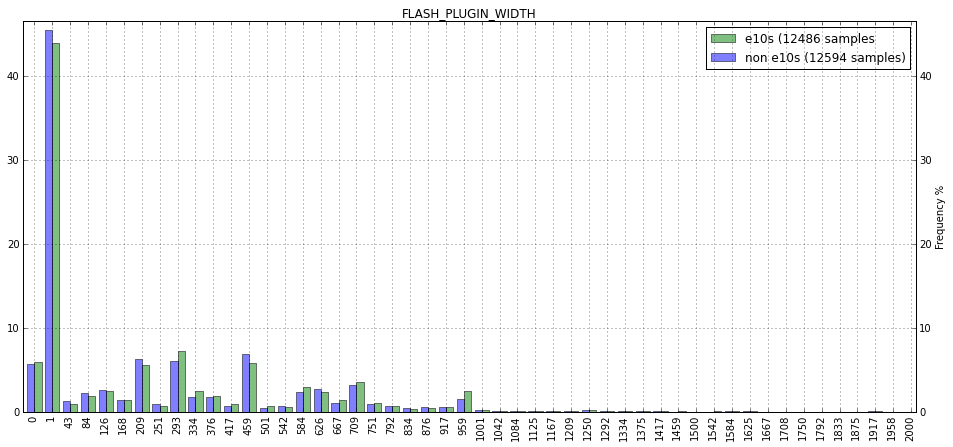

The chi2 distance for FLASH_PLUGIN_HEIGHT is 0.00534885718001


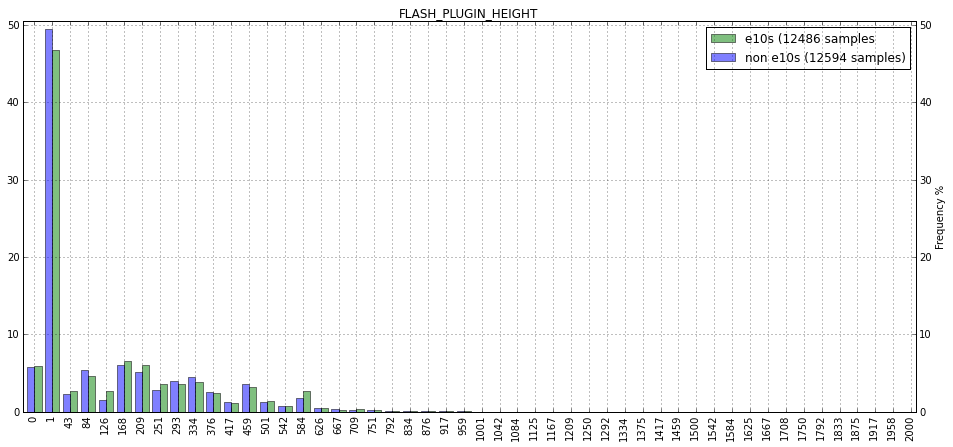

The chi2 distance for GC_NON_INCREMENTAL is 0.0052903154636


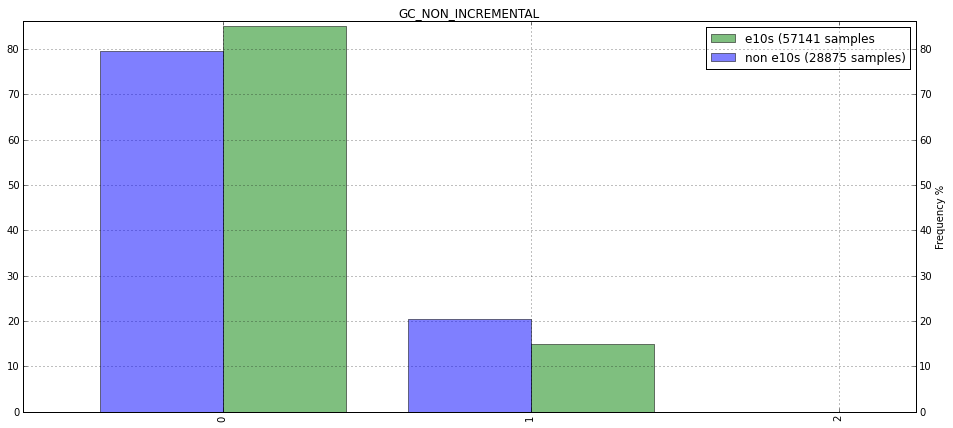

The chi2 distance for VIDEO_MSE_PLAY_TIME_MS is 0.00522248524568


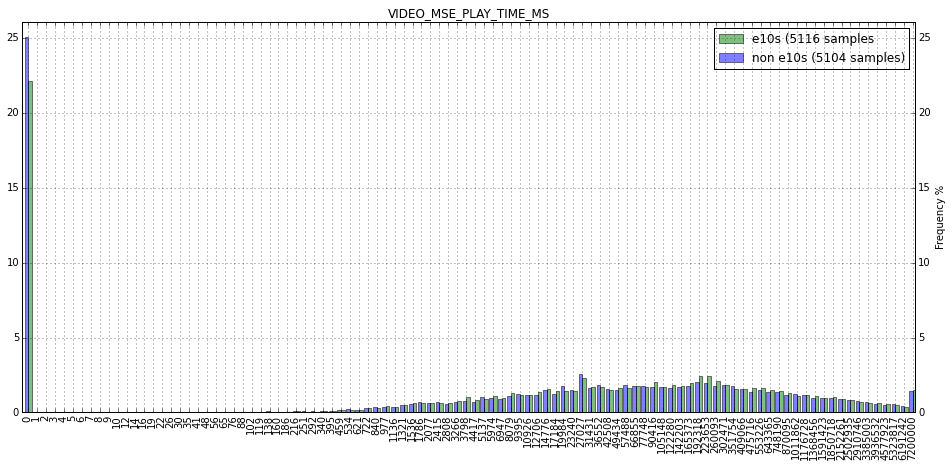

The chi2 distance for PREDICTOR_CONFIDENCE is 0.0050959886133


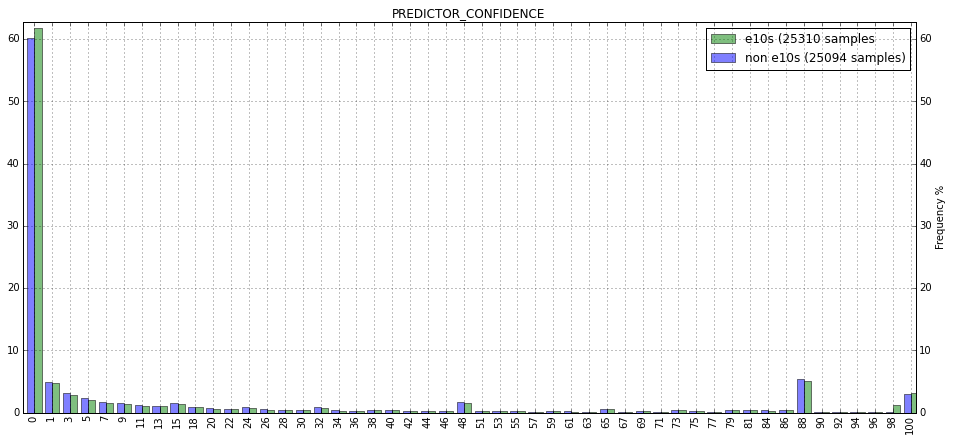

The chi2 distance for IMAGE_DECODE_SPEED_GIF is 0.00503906472676


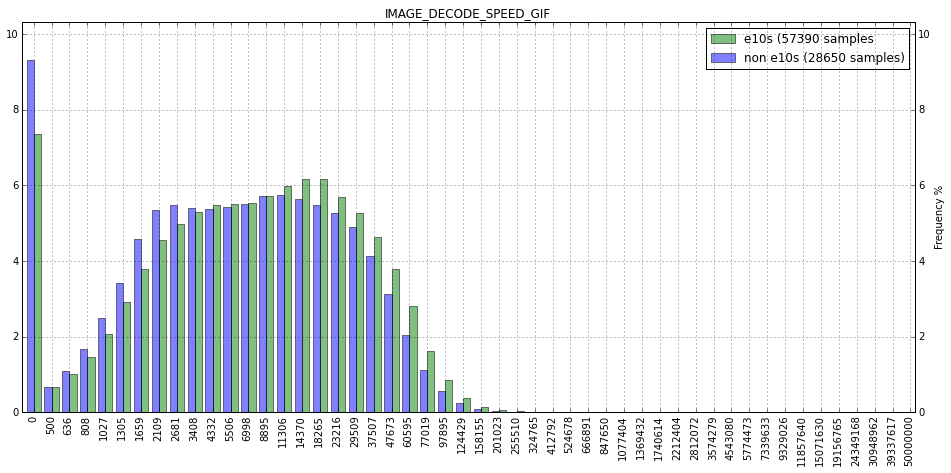

The chi2 distance for HTTP_CACHE_ENTRY_ALIVE_TIME is 0.00499444726988


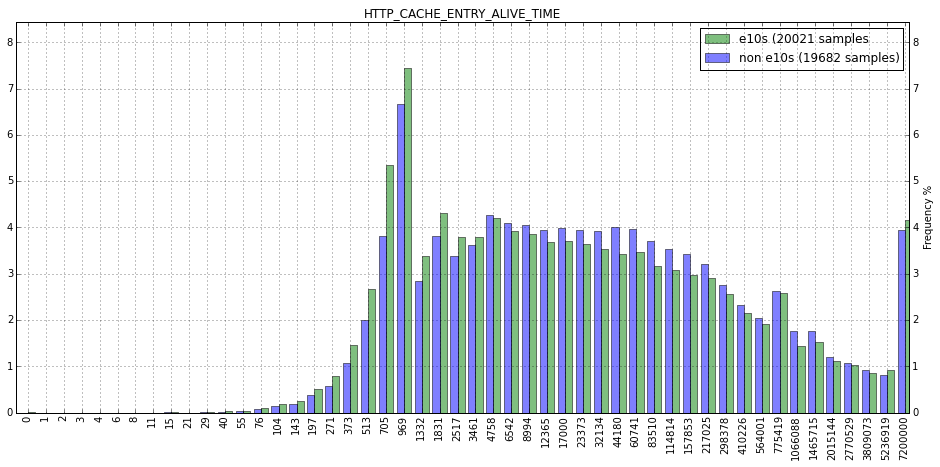

The chi2 distance for HTTP_PAGE_TCP_CONNECTION is 0.00497128344114


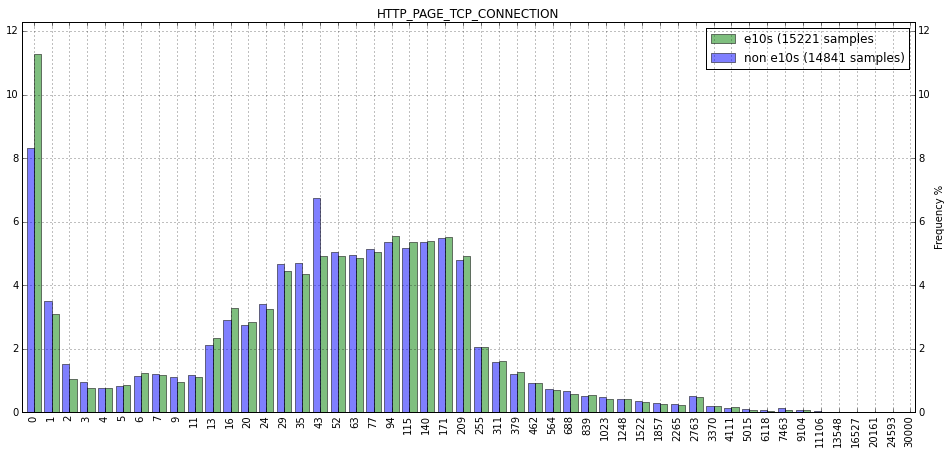

The chi2 distance for NETWORK_CACHE_METADATA_SECOND_READ_TIME_MS is 0.00495750517153


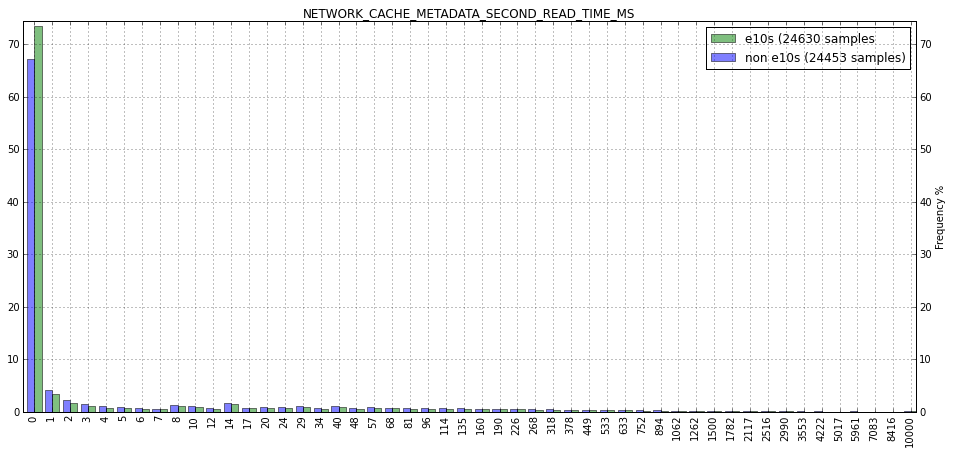

The chi2 distance for STS_NUMBER_OF_PENDING_EVENTS is 0.00491558811947


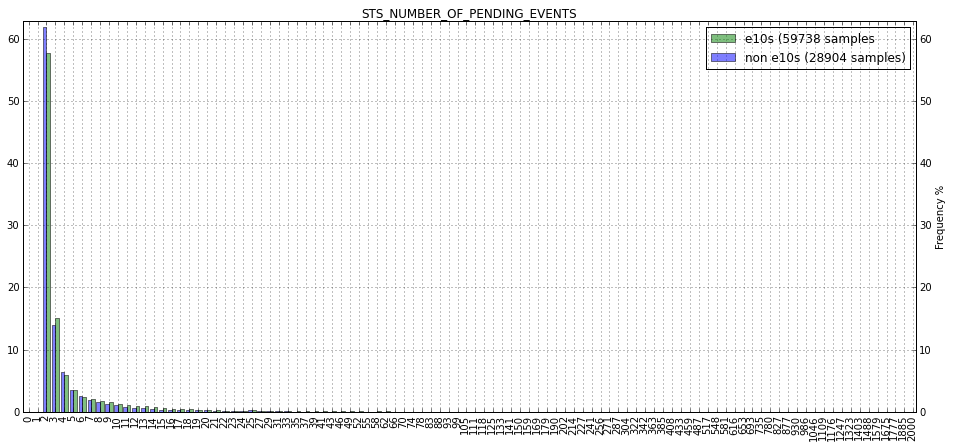

The chi2 distance for TELEMETRY_COMPRESS is 0.00481769868401


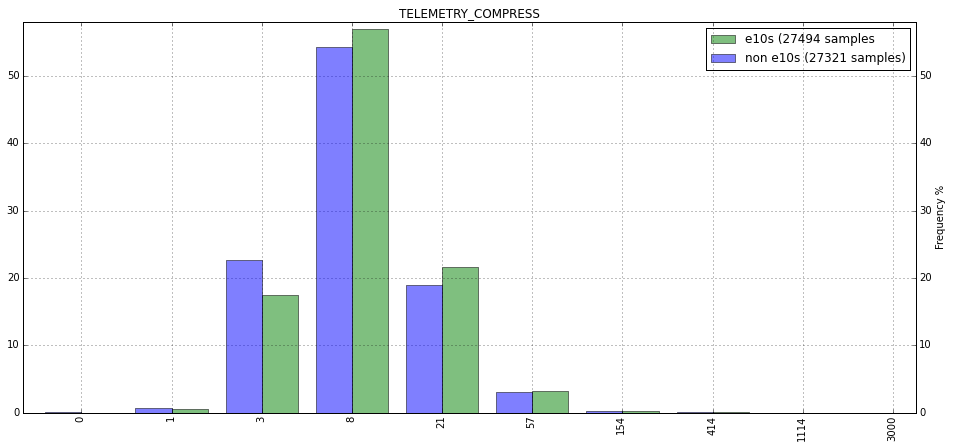

The chi2 distance for BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS is 0.00460392759604


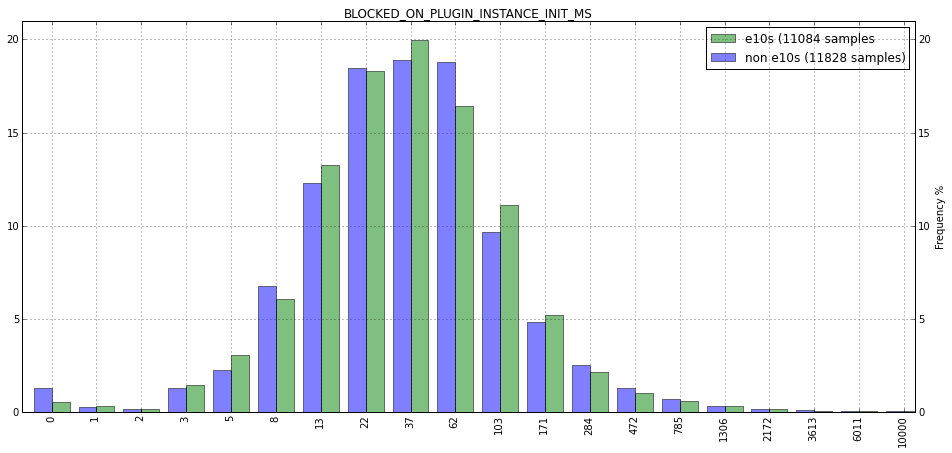

The chi2 distance for VIDEO_MSE_JOIN_LATENCY_MS is 0.00459329052645


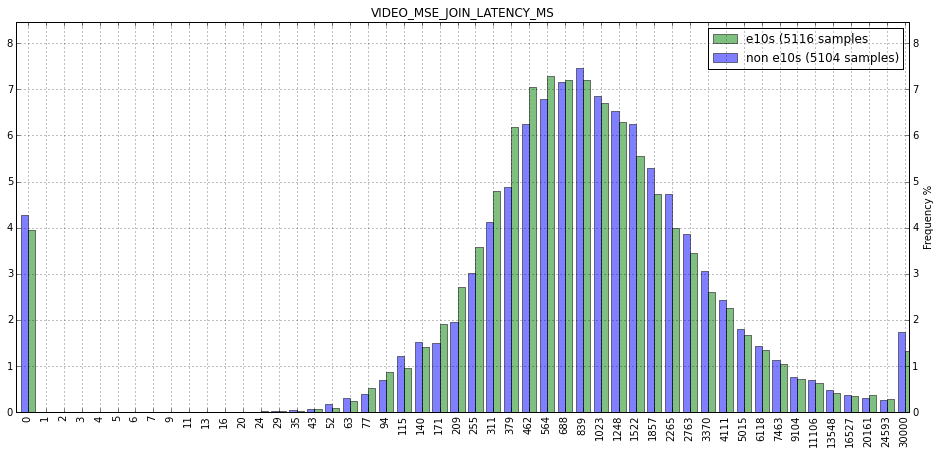

The chi2 distance for NETWORK_CACHE_METADATA_SIZE is 0.00450926350639


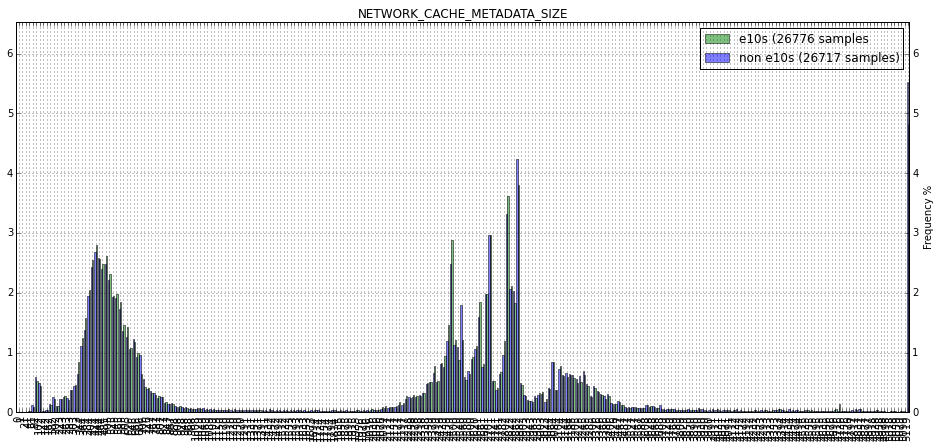

The chi2 distance for CYCLE_COLLECTOR_WORKER_VISITED_GCED is 0.00449276650548


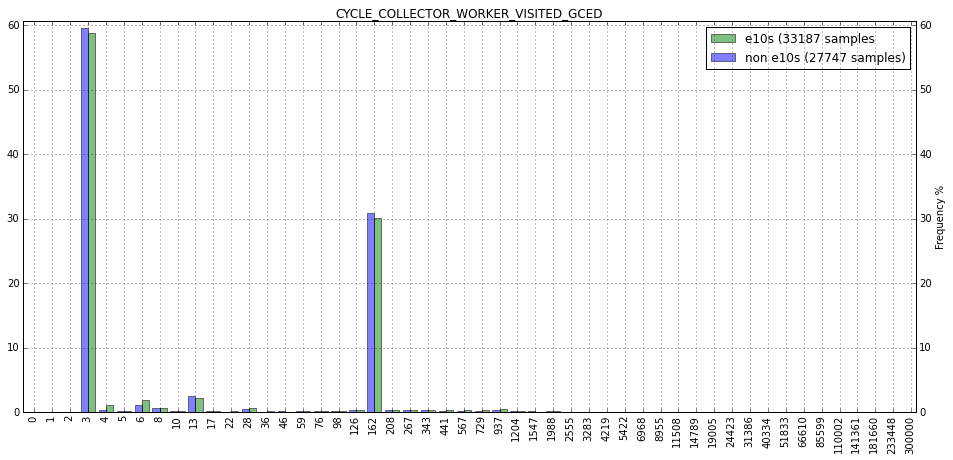

The chi2 distance for PLUGIN_SHUTDOWN_MS is 0.00442809616914


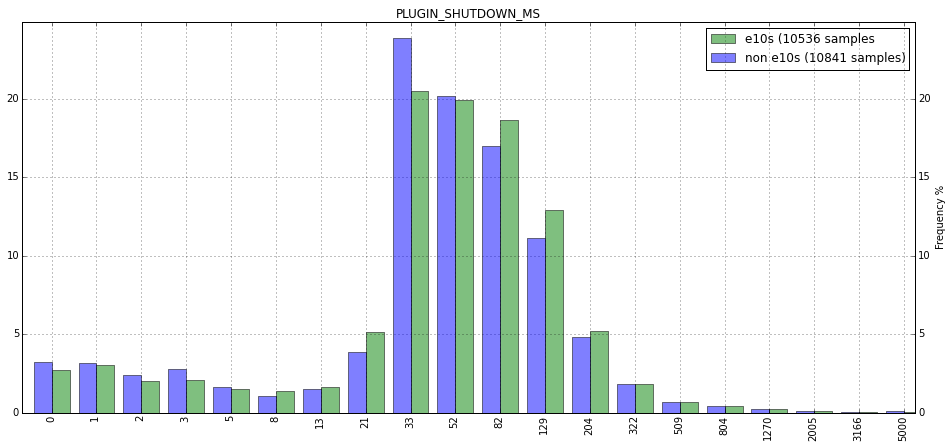

The chi2 distance for STS_POLL_AND_EVENTS_CYCLE is 0.00418751343864


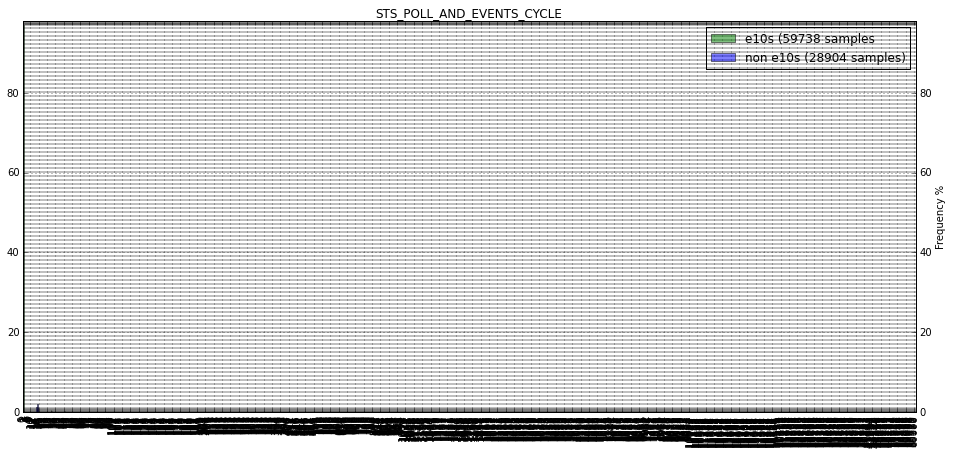

The chi2 distance for STS_POLL_BLOCK_TIME is 0.00413345278108


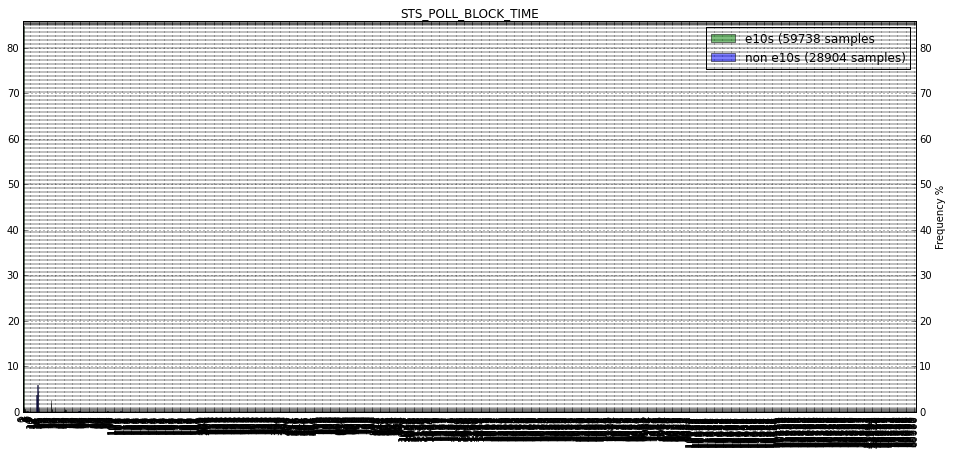

The chi2 distance for HTTP_SUB_TCP_CONNECTION is 0.00412102484025


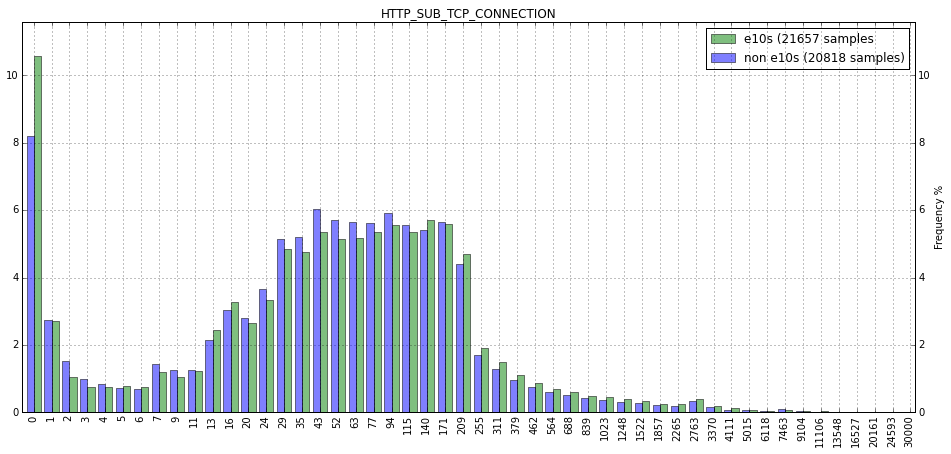

The chi2 distance for HEALTHREPORT_COLLECT_DAILY_MS is 0.00411267575789


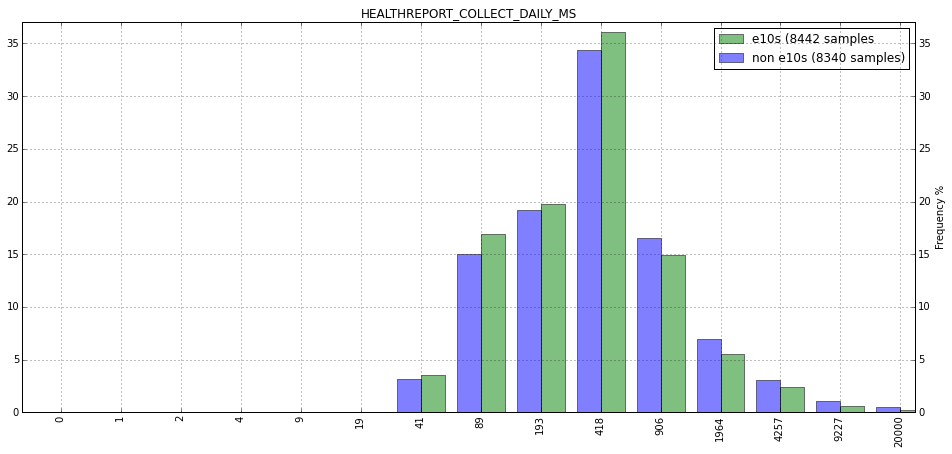

The chi2 distance for STS_NUMBER_OF_PENDING_EVENTS_IN_THE_LAST_CYCLE is 0.00400512113953


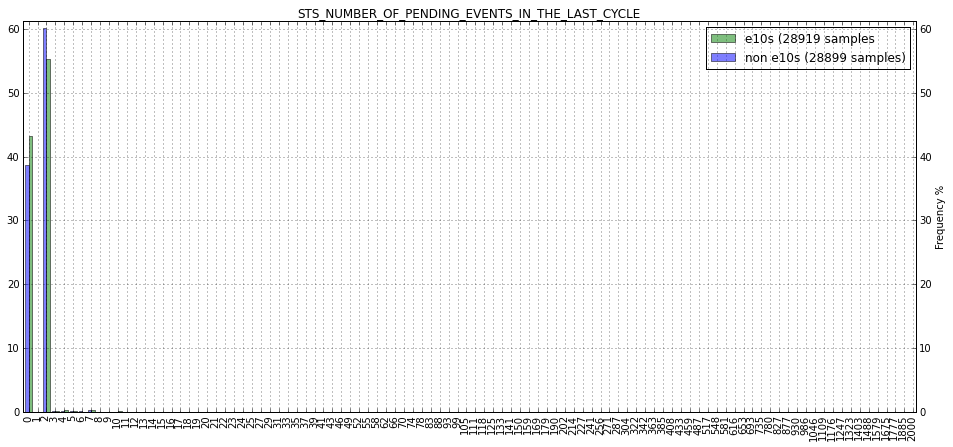

The chi2 distance for EVENTLOOP_UI_LAG_EXP_MS is 0.00380069075661


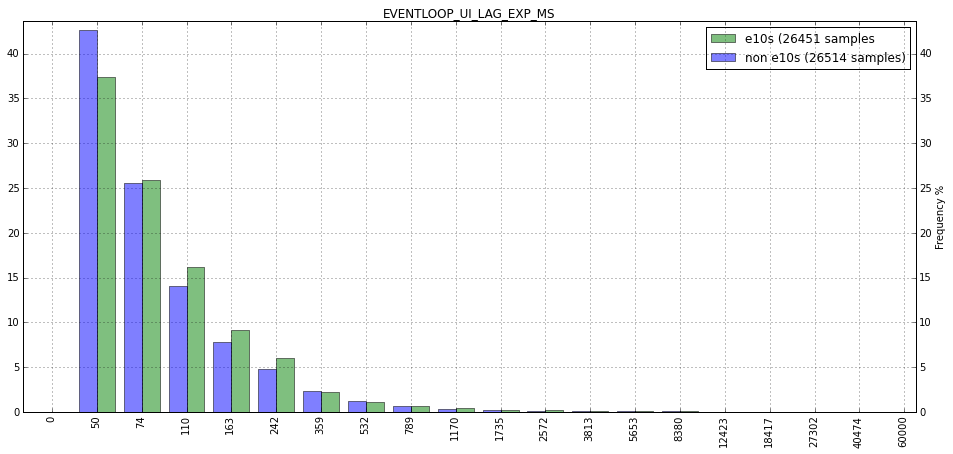

The chi2 distance for FX_SESSION_RESTORE_STARTUP_ONLOAD_INITIAL_WINDOW_MS is 0.00378155208605


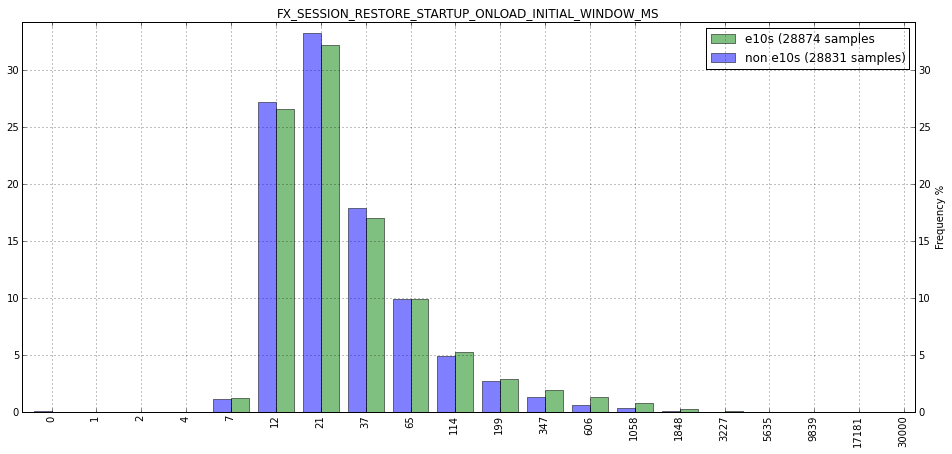

The chi2 distance for FLASH_PLUGIN_STATES is 0.0037464416269


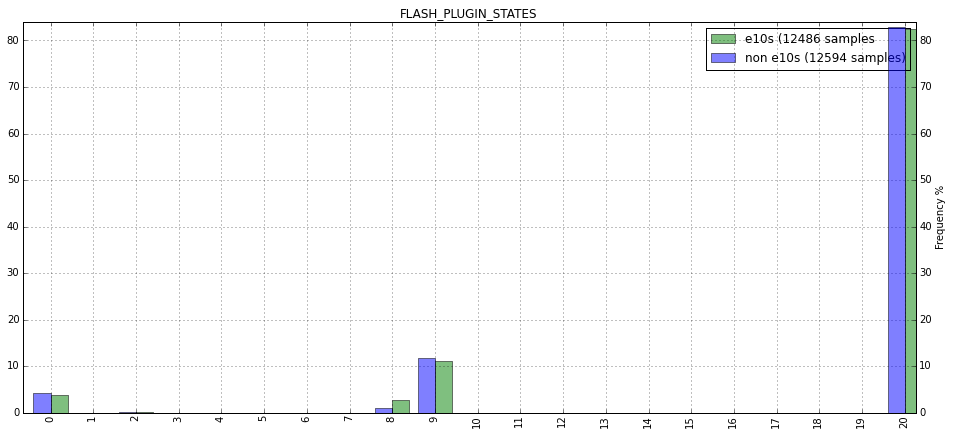

The chi2 distance for IMAGE_DECODE_COUNT is 0.00372890636526


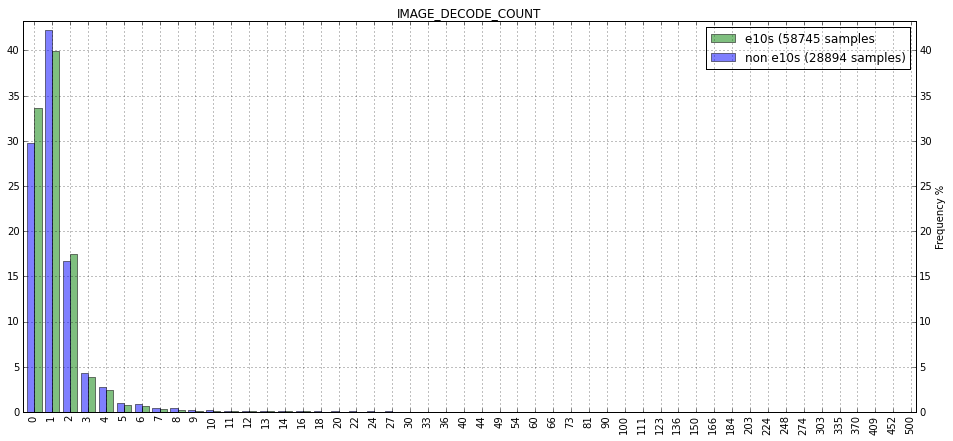

The chi2 distance for IMAGE_DECODE_SPEED_JPEG is 0.0037113692668


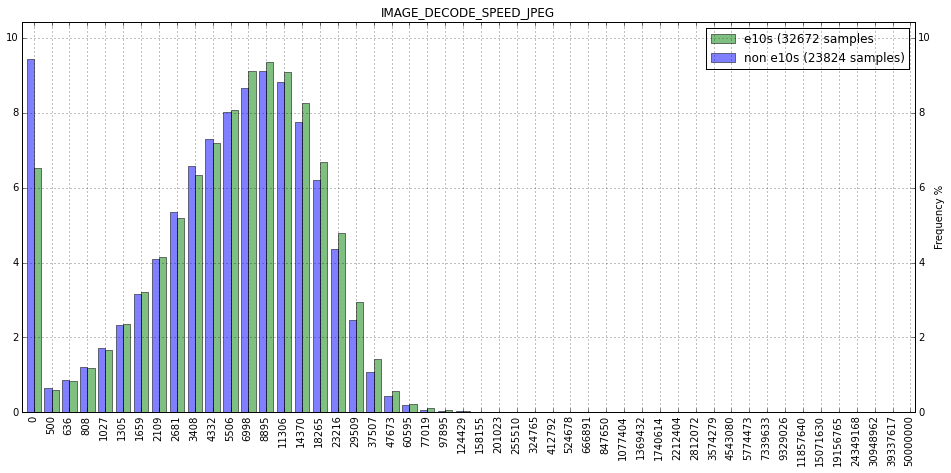

The chi2 distance for PWMGR_NUM_SAVED_PASSWORDS is 0.00369625989527


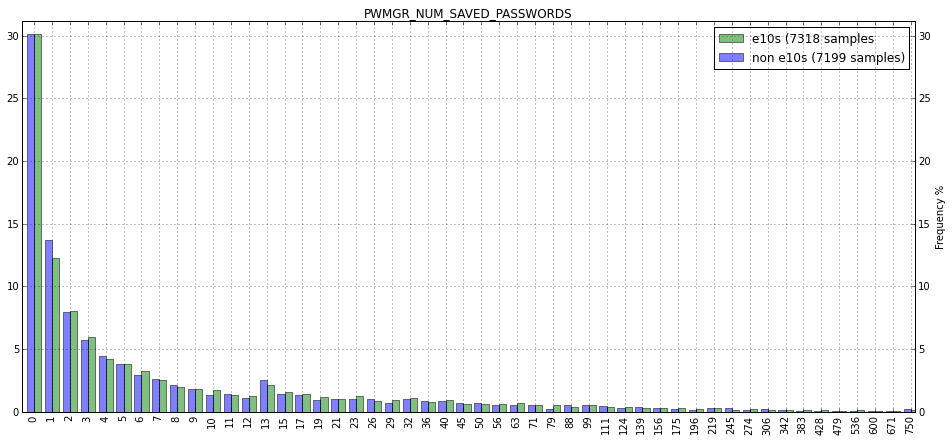

The chi2 distance for [[COUNT]]_TOP_LEVEL_CONTENT_DOCUMENTS_DESTROYED is 0.00366229704338


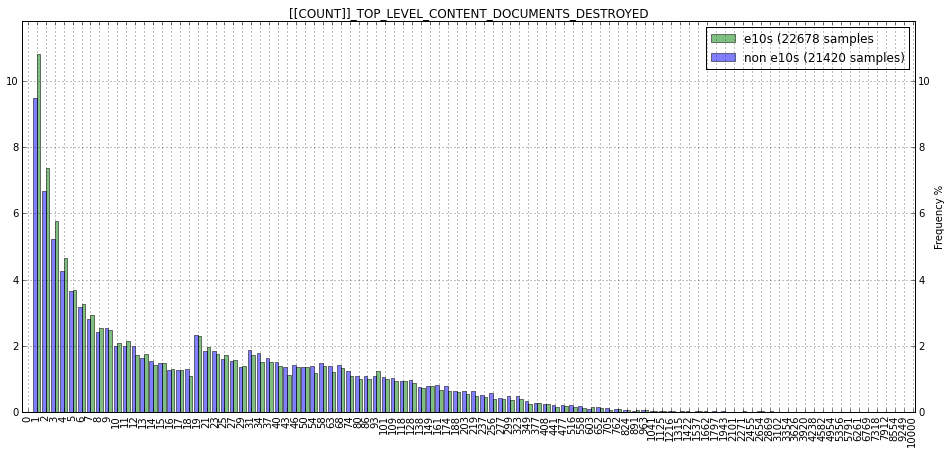

The chi2 distance for BLOCKED_ON_PLUGIN_STREAM_INIT_MS is 0.0036612299267


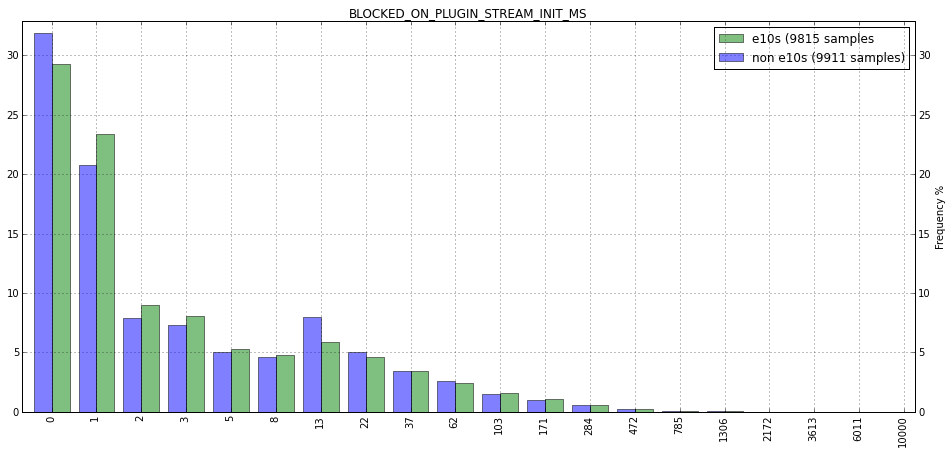

The chi2 distance for PLACES_BACKUPS_TOJSON_MS is 0.00365379279051


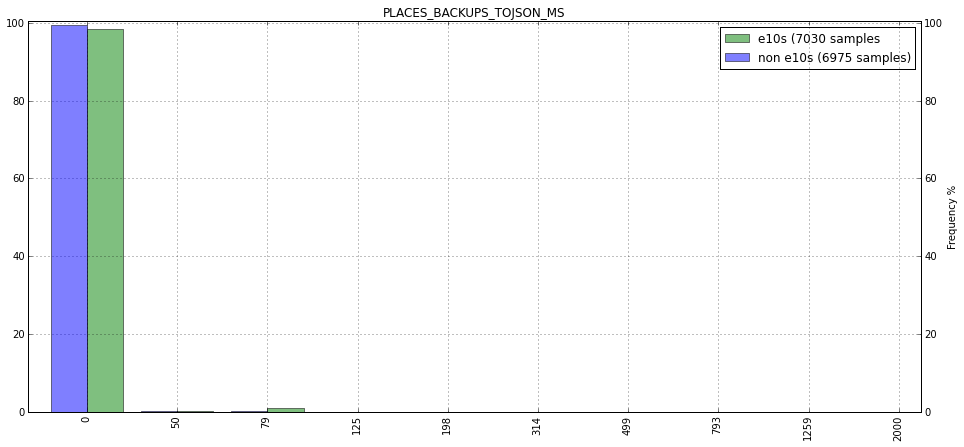

The chi2 distance for COMPONENTS_SHIM_ACCESSED_BY_CONTENT is 0.00354879492649


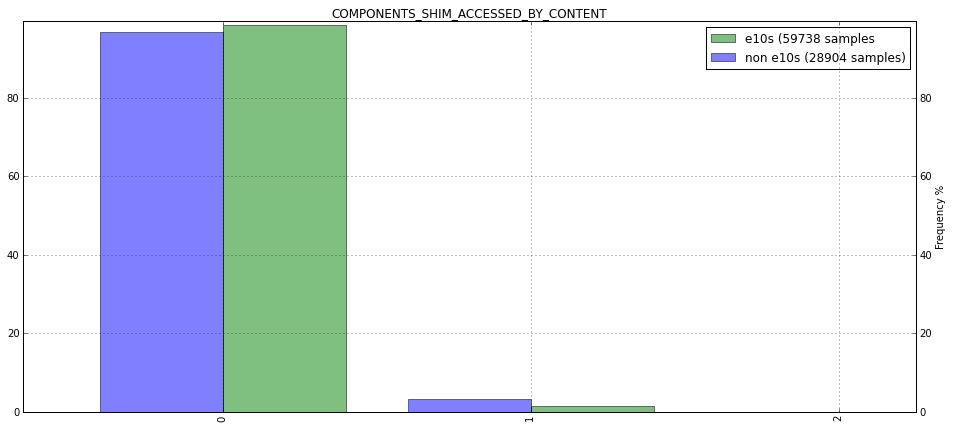

The chi2 distance for FLASH_PLUGIN_INSTANCES_ON_PAGE is 0.00338928777722


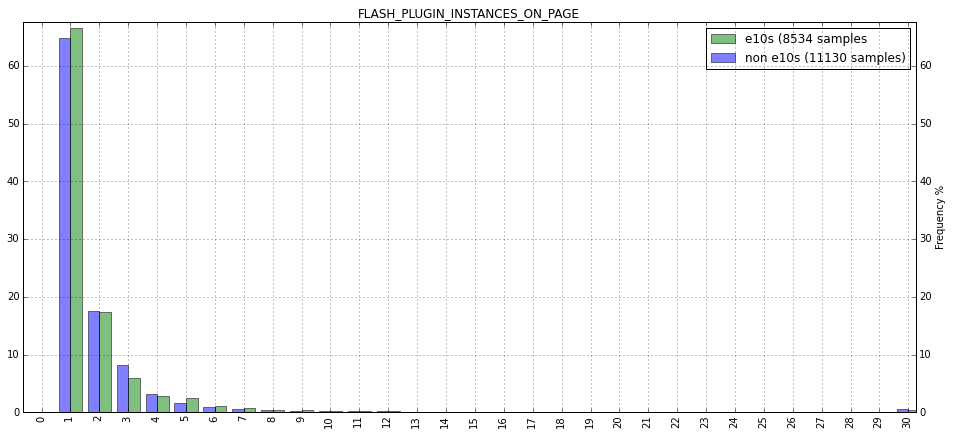

The chi2 distance for PREDICTOR_WAIT_TIME is 0.00333925156658


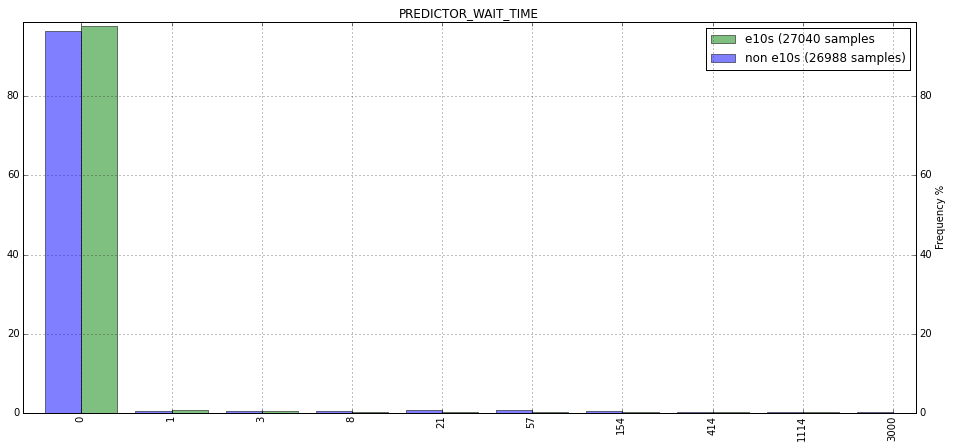

The chi2 distance for BLOCKED_ON_PLUGIN_INSTANCE_DESTROY_MS is 0.00330638676164


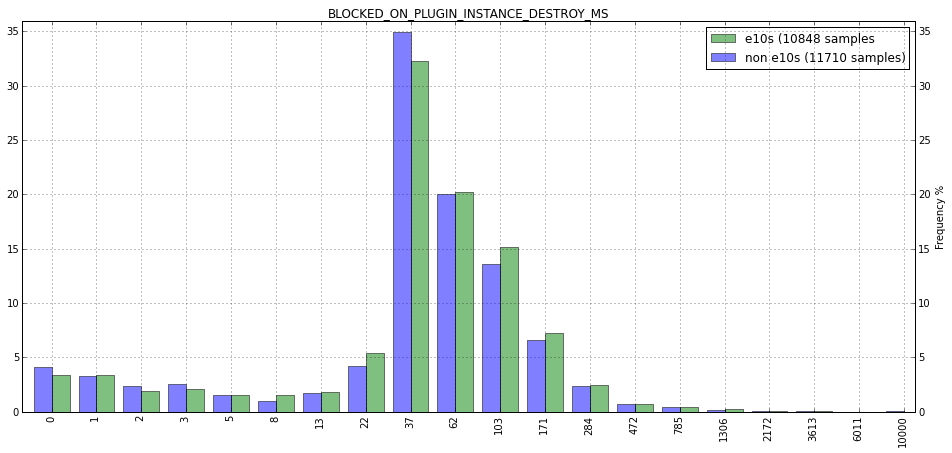

The chi2 distance for STARTUP_DNS_LOOKUP_TIME is 0.00324487808027


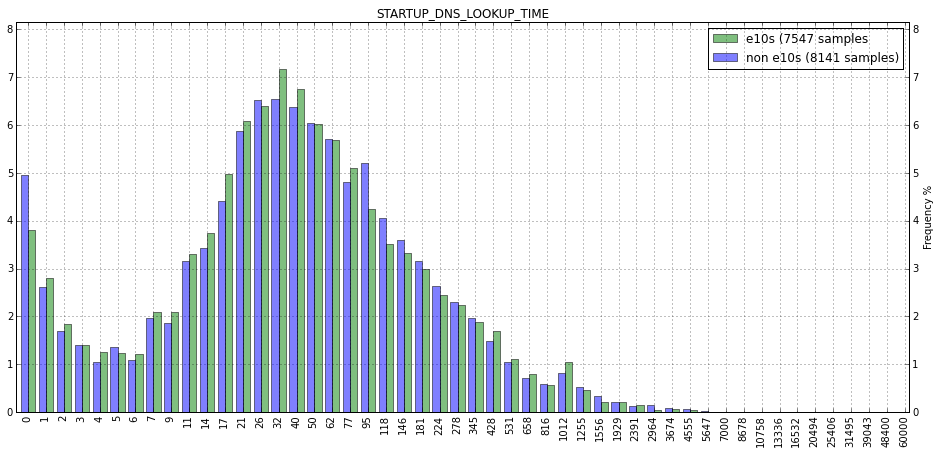

The chi2 distance for HTTP_SUBITEM_FIRST_BYTE_LATENCY_TIME is 0.00314590105882


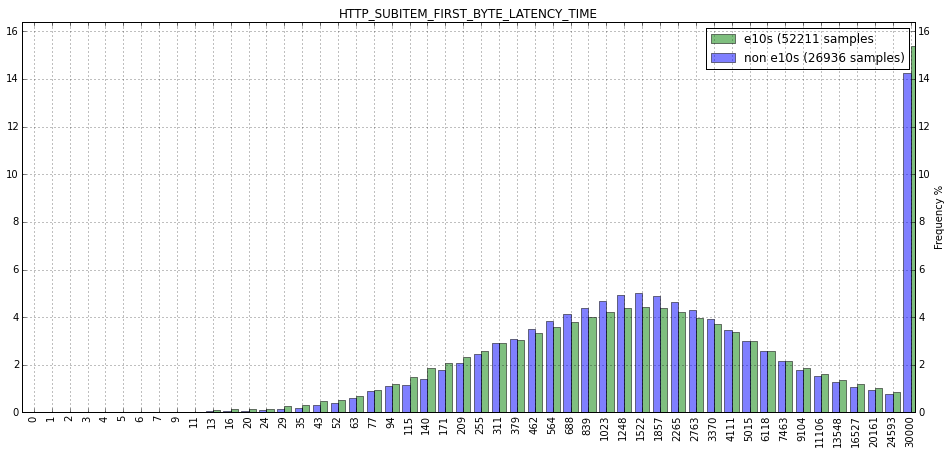

The chi2 distance for WORD_CACHE_HITS_CHROME is 0.00312390447621


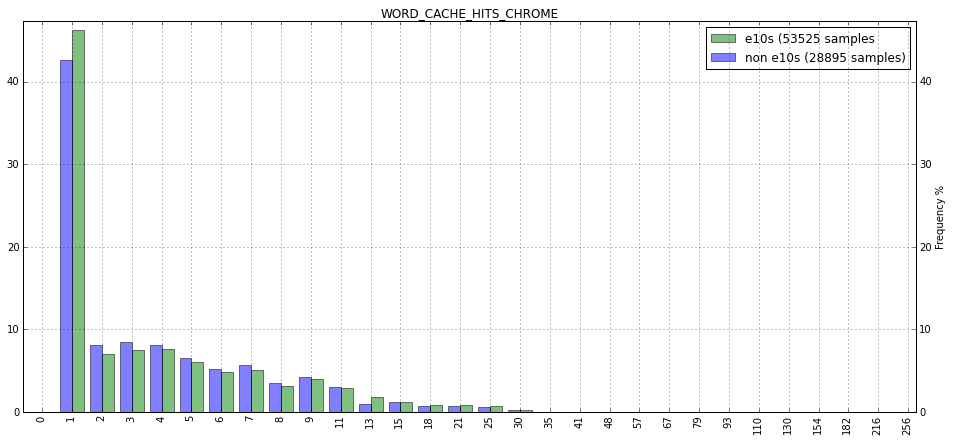

The chi2 distance for TELEMETRY_ARCHIVE_CHECKING_OVER_QUOTA_MS is 0.00309303578934


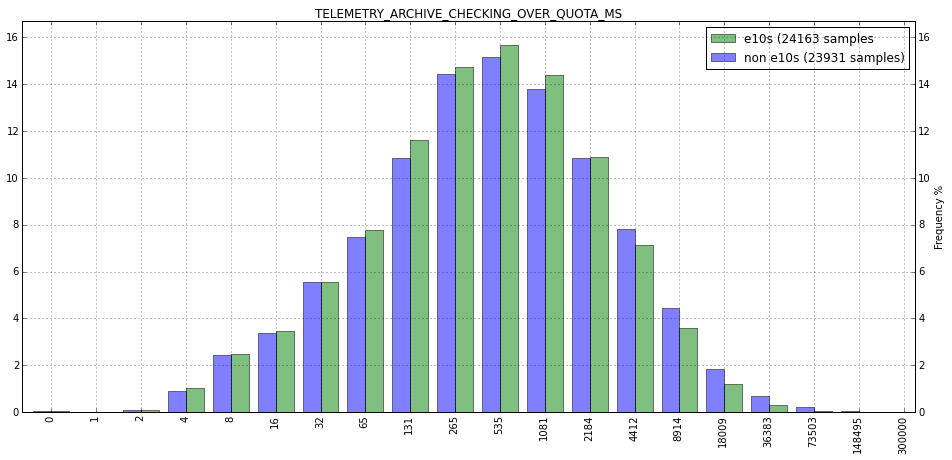

The chi2 distance for FX_SESSION_RESTORE_COLLECT_ALL_WINDOWS_DATA_MS is 0.00305166979777


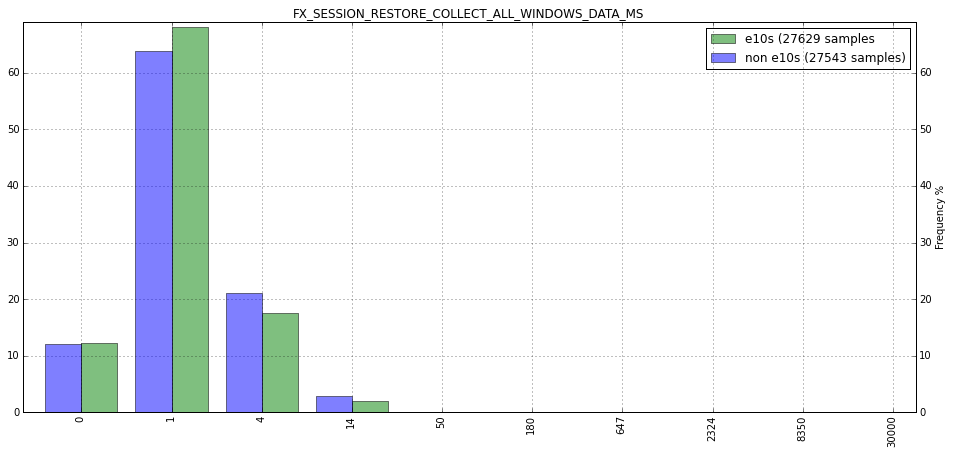

The chi2 distance for GHOST_WINDOWS is 0.00298885487374


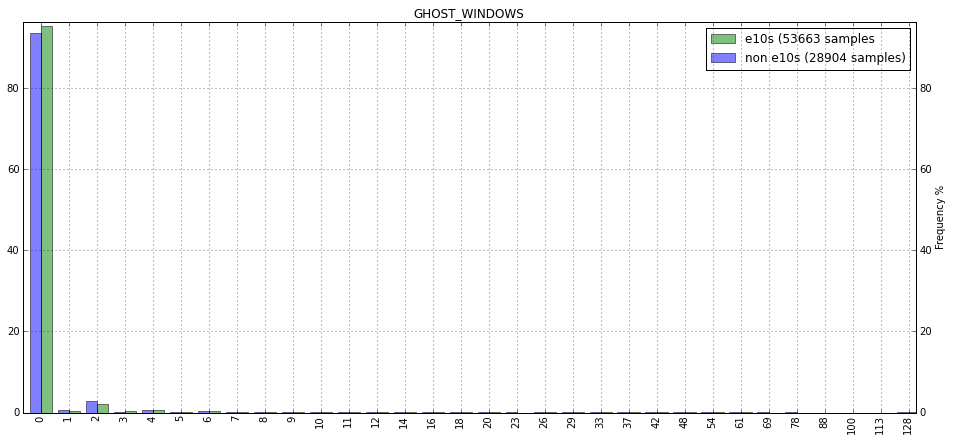

The chi2 distance for HTTP_PAGE_FIRST_SENT_TO_LAST_RECEIVED is 0.00295116658232


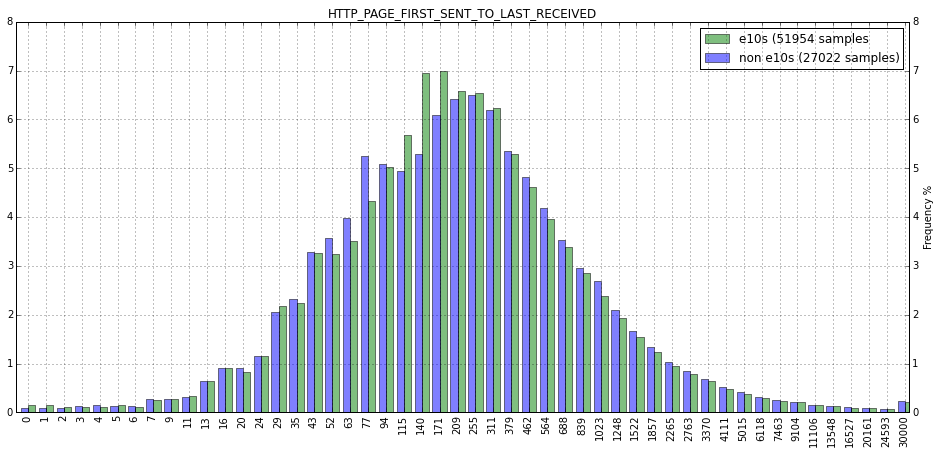

The chi2 distance for CERT_VALIDATION_HTTP_REQUEST_RESULT is 0.00278106406298


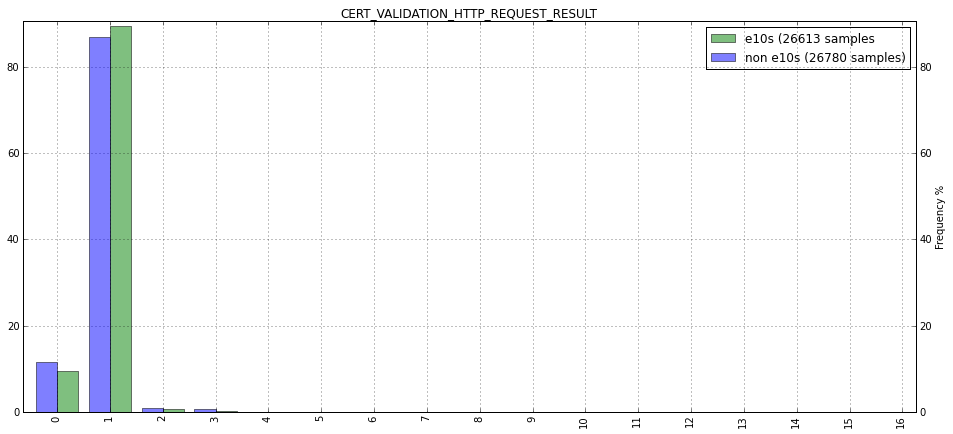

The chi2 distance for SYSTEM_FONT_FALLBACK_FIRST is 0.00274886284707


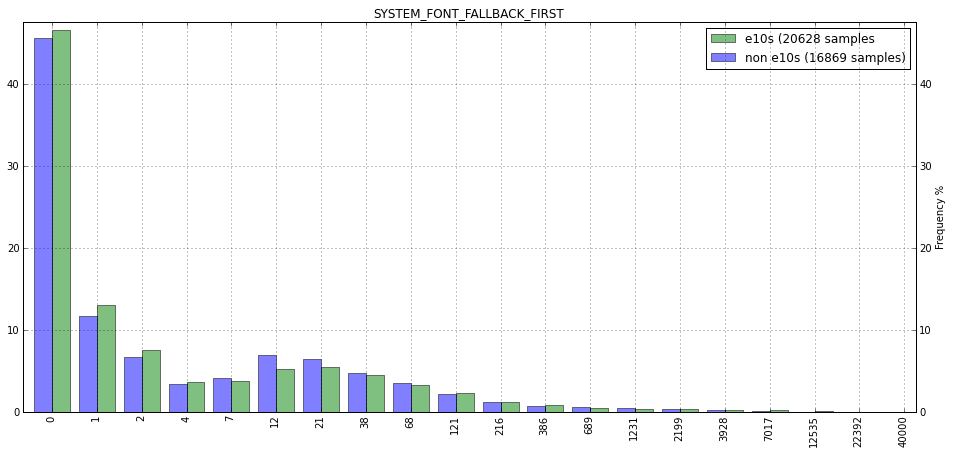

The chi2 distance for PWMGR_NUM_HTTPAUTH_PASSWORDS is 0.00269050356944


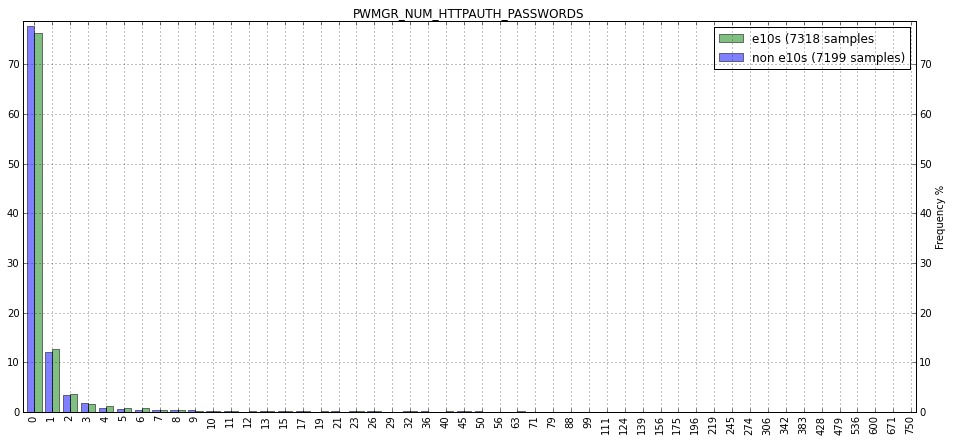

The chi2 distance for SSL_SUCCESFUL_CERT_VALIDATION_TIME_MOZILLAPKIX is 0.00260160804907


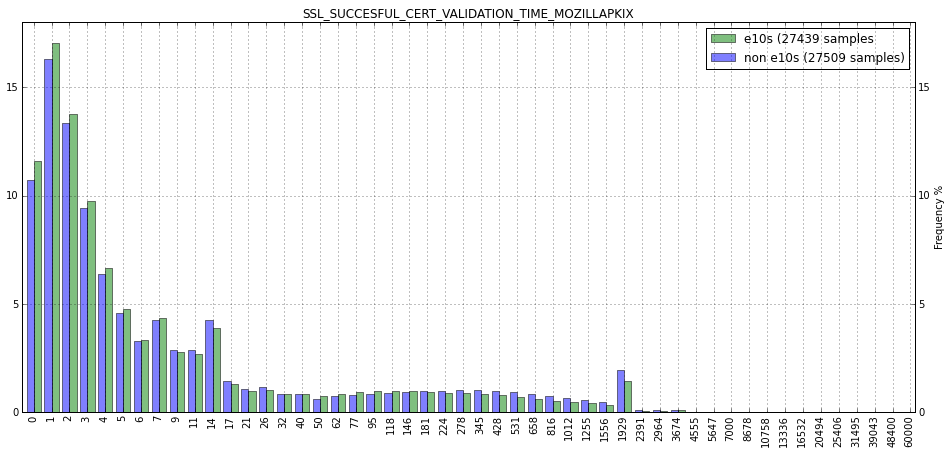

The chi2 distance for [[COUNT]]_TELEMETRY_ARCHIVE_SESSION_PING_COUNT is 0.00252675856153


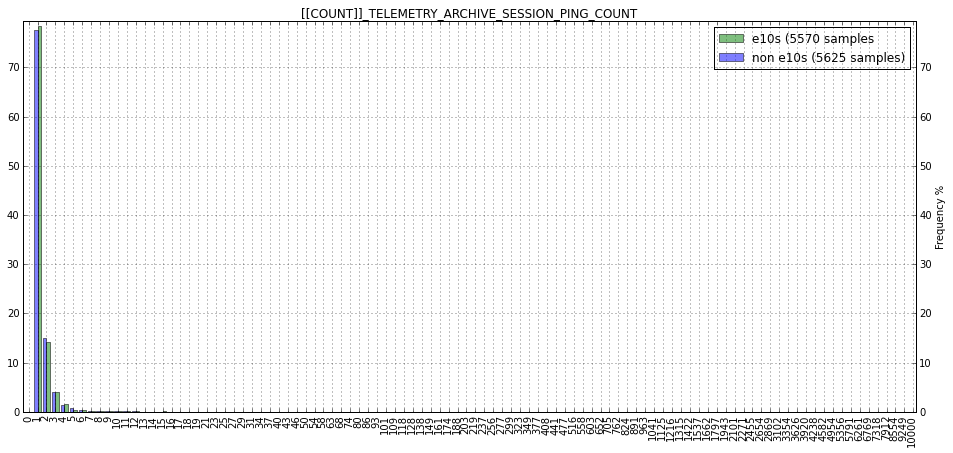

The chi2 distance for MIXED_CONTENT_HSTS is 0.00245740601788


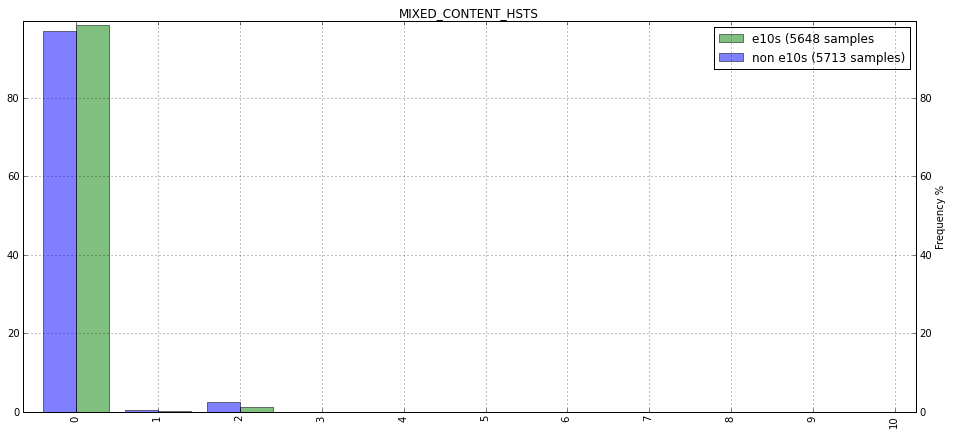

The chi2 distance for PREDICTOR_LEARN_WORK_TIME is 0.00243529253642


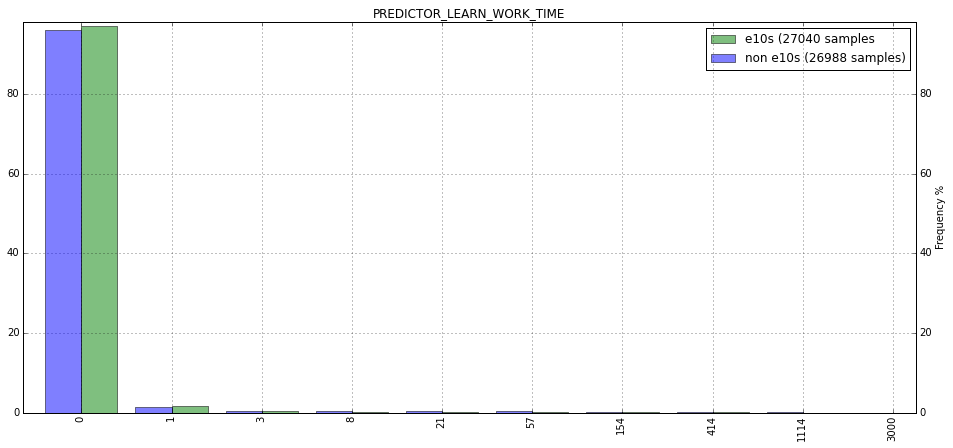

The chi2 distance for PWMGR_LOGIN_PAGE_SAFETY is 0.00240370089559


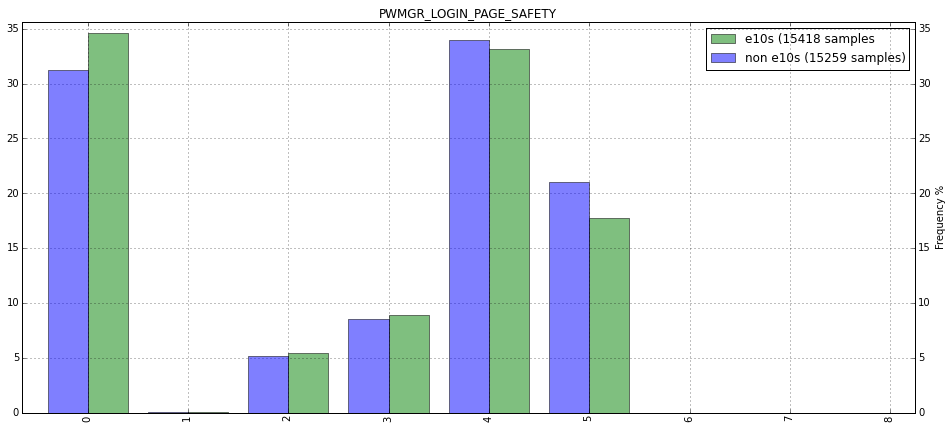

The chi2 distance for VIDEO_H264_SPS_MAX_NUM_REF_FRAMES is 0.00238168387346


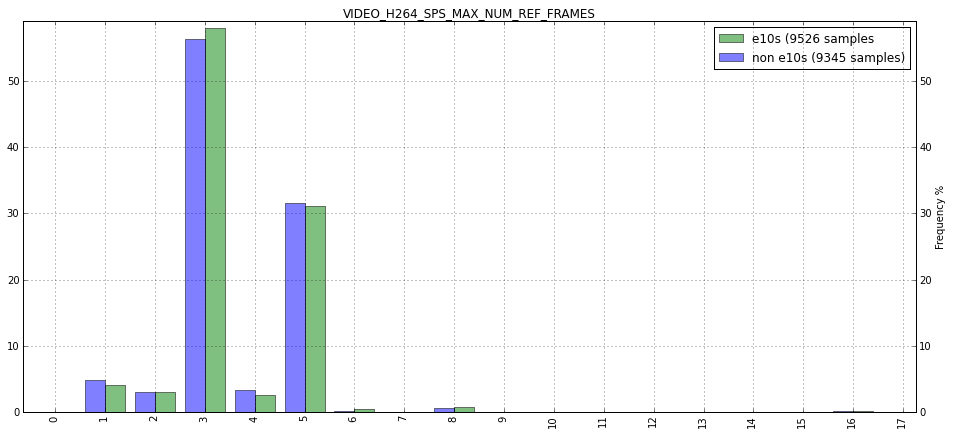

The chi2 distance for DWRITEFONT_DELAYEDINITFONTLIST_COLLECT is 0.00235999613236


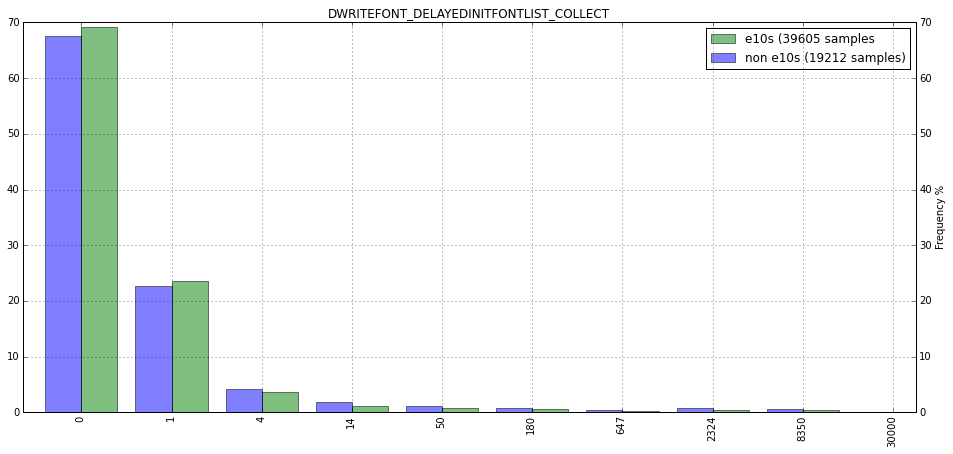

The chi2 distance for HTTP_SUB_FIRST_SENT_TO_LAST_RECEIVED is 0.00229328411426


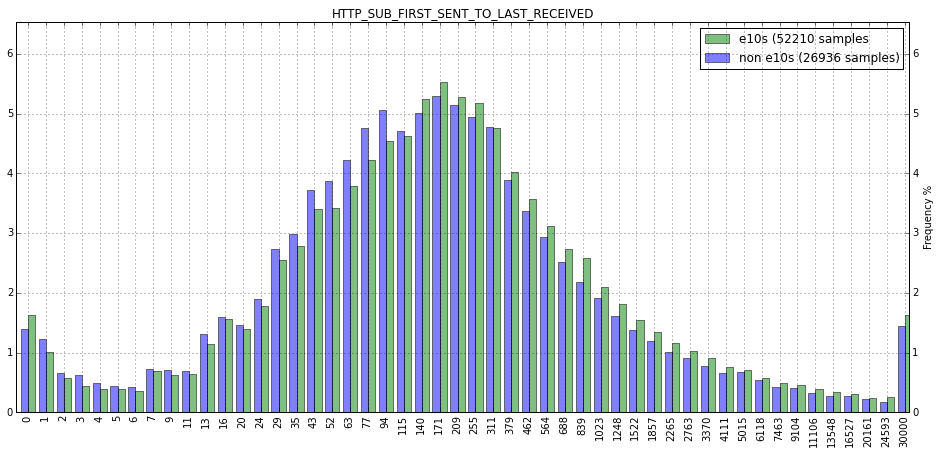

The chi2 distance for YOUTUBE_EMBED_SEEN is 0.00229227788133


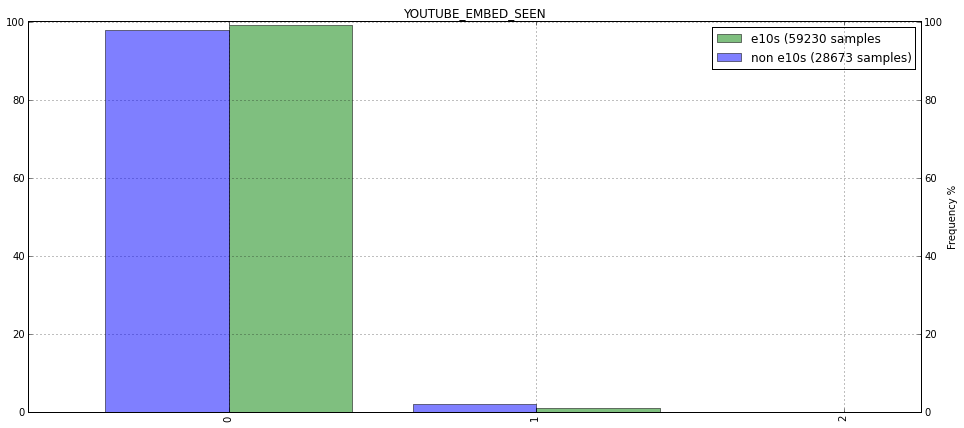

The chi2 distance for STARTUP_MOZ_SQLITE_COOKIES_OPEN_READAHEAD_MS is 0.00227751895712


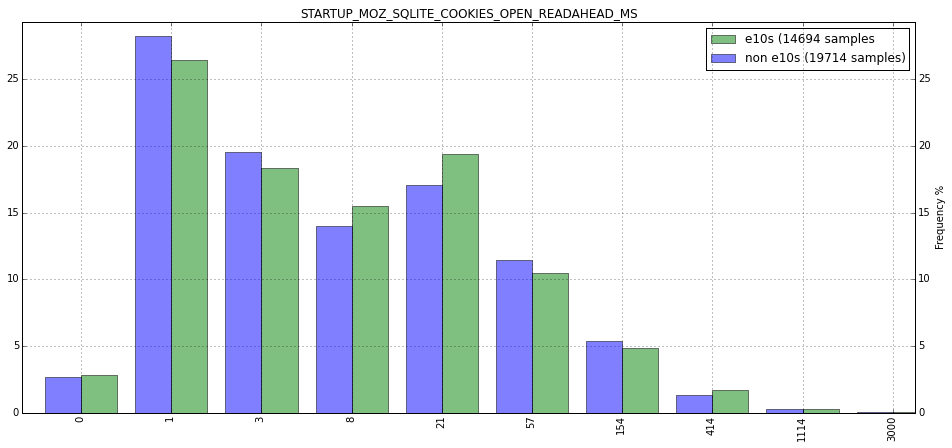

The chi2 distance for CACHE_SERVICE_LOCK_WAIT_2 is 0.00220616915931


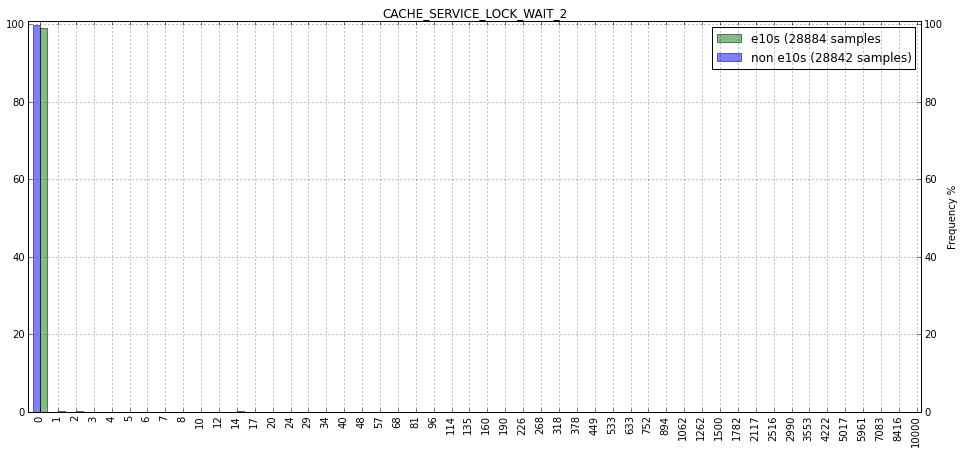

The chi2 distance for PRCLOSE_TCP_BLOCKING_TIME_LINK_CHANGE is 0.00215919727337


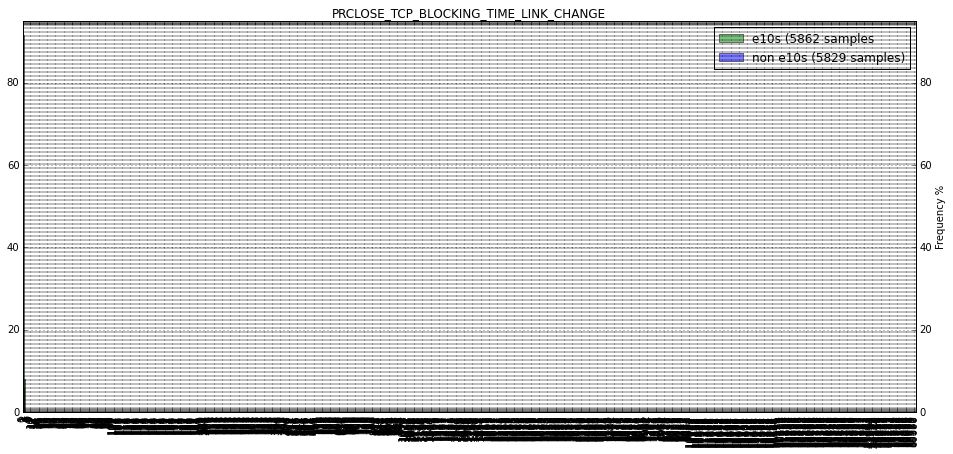

The chi2 distance for OSFILE_WRITEATOMIC_JANK_MS is 0.00212909375976


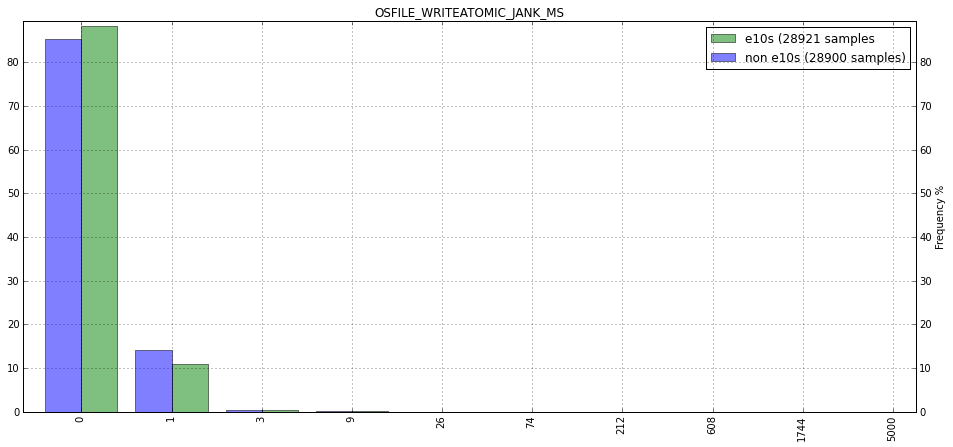

The chi2 distance for SEARCH_SERVICE_INIT_SYNC is 0.00202364378603


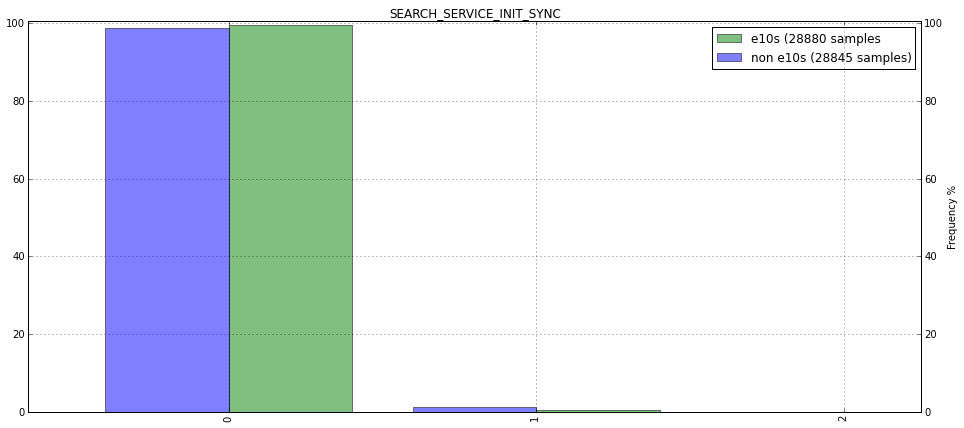

The chi2 distance for TELEMETRY_PENDING_CHECKING_OVER_QUOTA_MS is 0.00199486020544


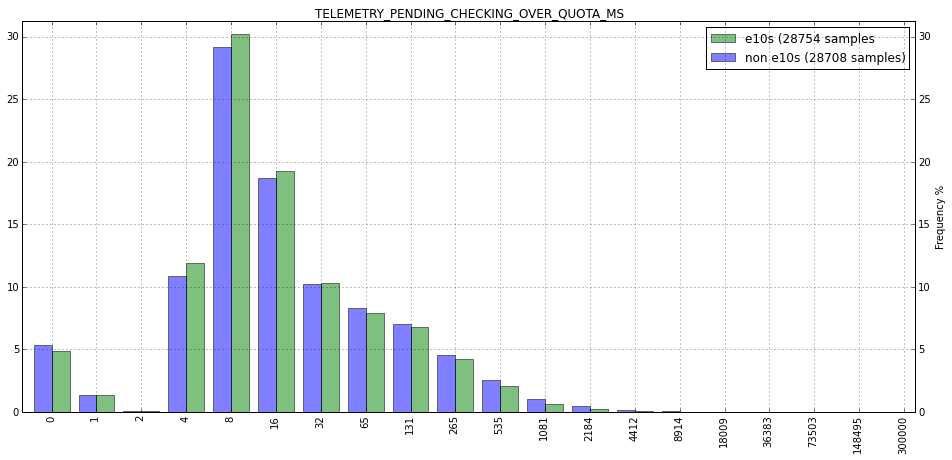

The chi2 distance for CYCLE_COLLECTOR_WORKER_VISITED_REF_COUNTED is 0.00199386445003


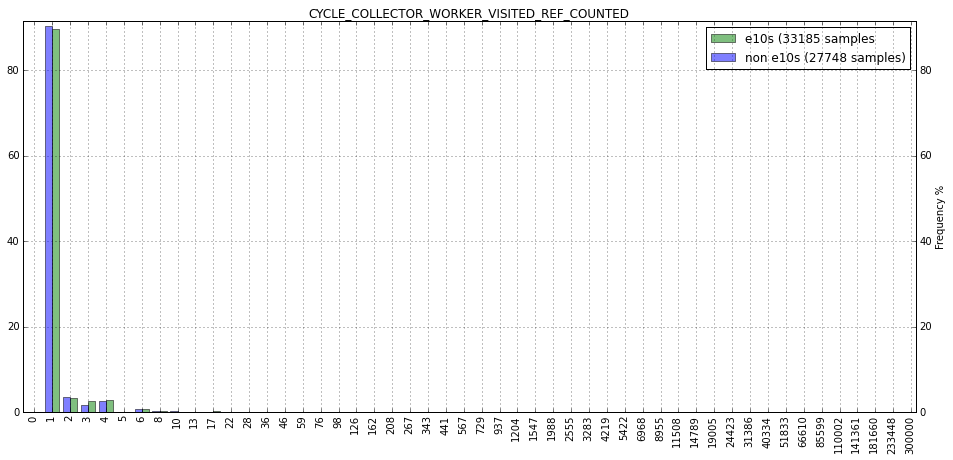

The chi2 distance for SSL_KEA_DHE_KEY_SIZE_FULL is 0.00198389130738


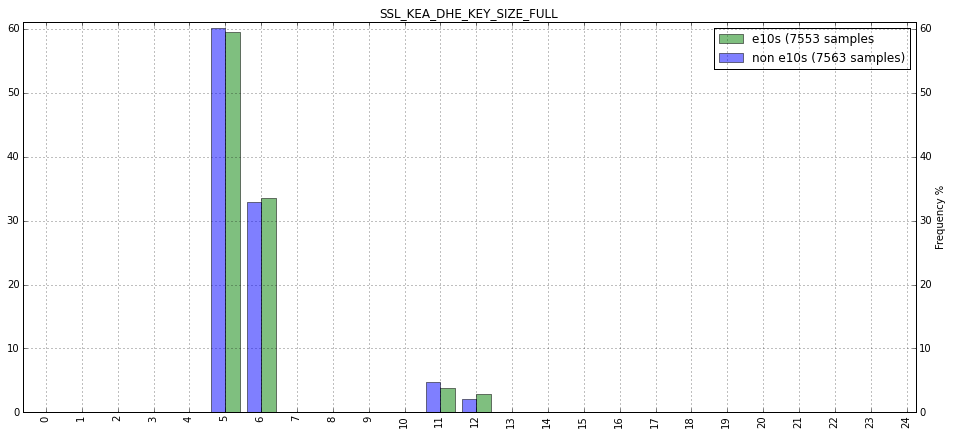

The chi2 distance for PREDICTOR_SUBRESOURCE_DEGRADATION is 0.00195373056397


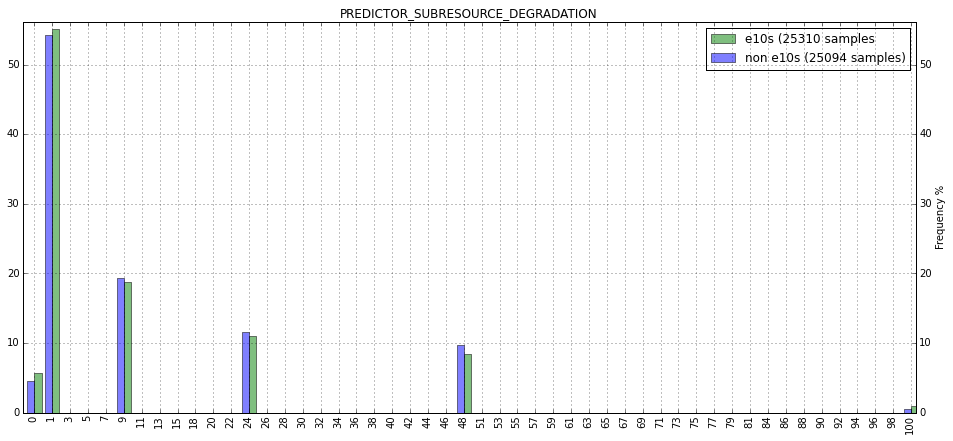

The chi2 distance for MOZ_SQLITE_OPEN_MS is 0.00195117026213


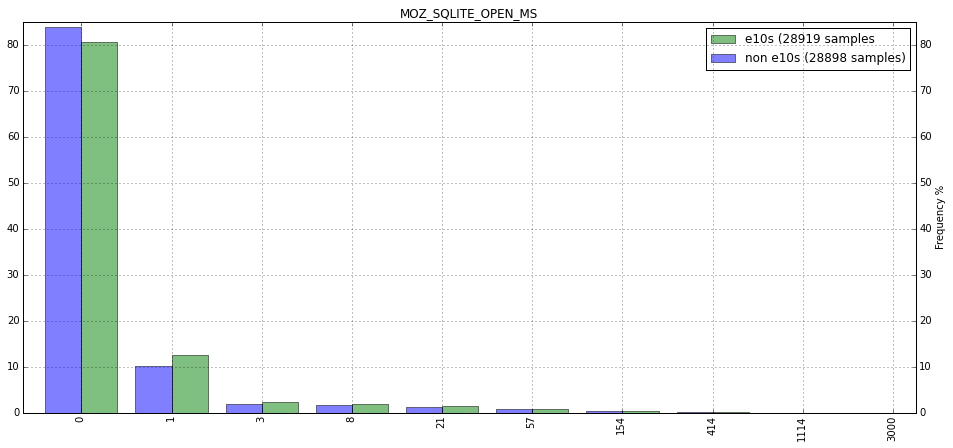

The chi2 distance for PREDICTOR_BASE_CONFIDENCE is 0.00194672629819


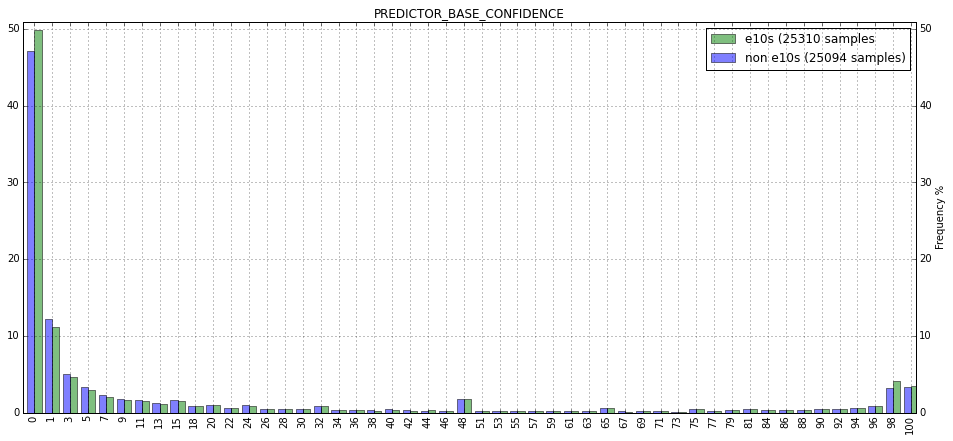

The chi2 distance for HTTP_CACHE_ENTRY_RELOAD_TIME is 0.00193805234301


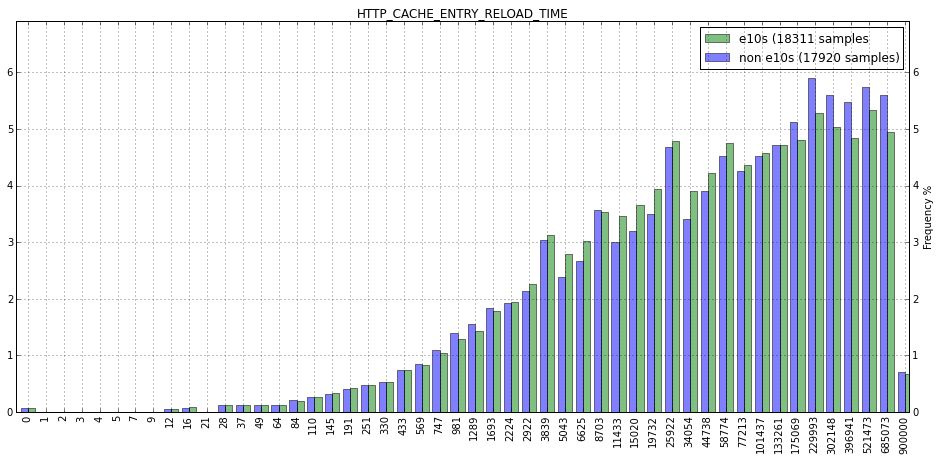

The chi2 distance for UPDATE_CHECK_CODE_NOTIFY is 0.00191780914068


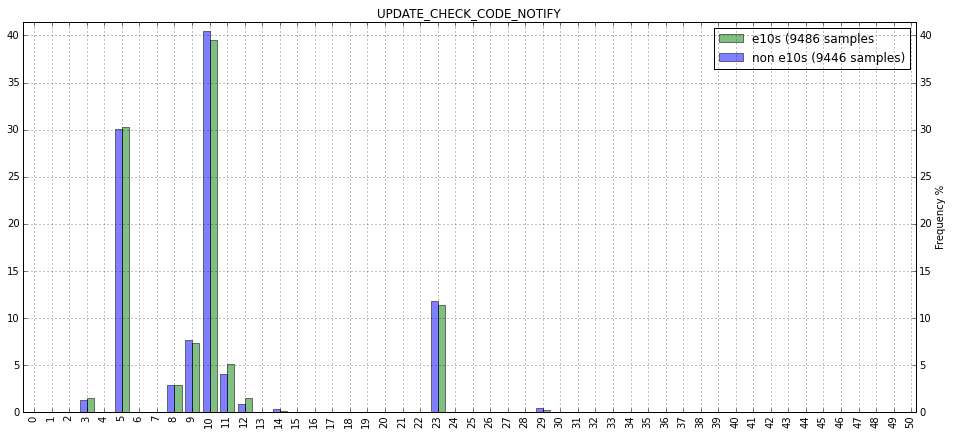

The chi2 distance for CYCLE_COLLECTOR_WORKER is 0.00189402420424


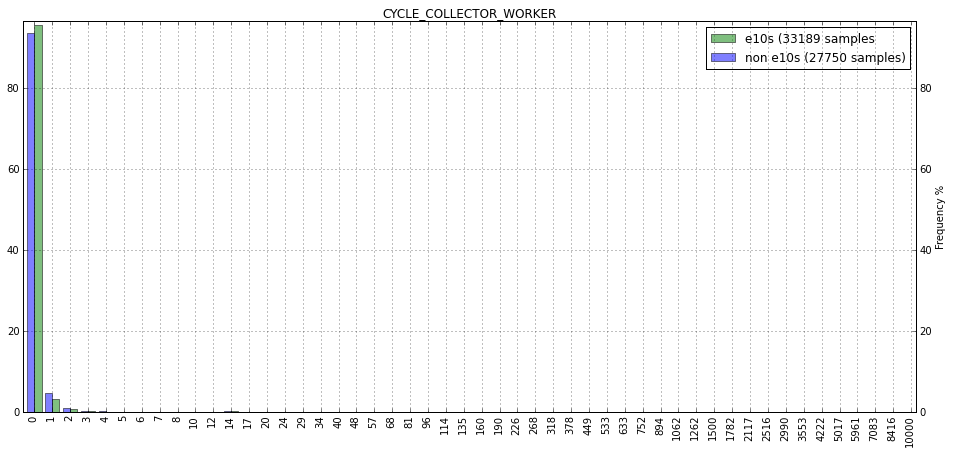

The chi2 distance for LOCALDOMSTORAGE_PRELOAD_PENDING_ON_FIRST_ACCESS is 0.00178732413165


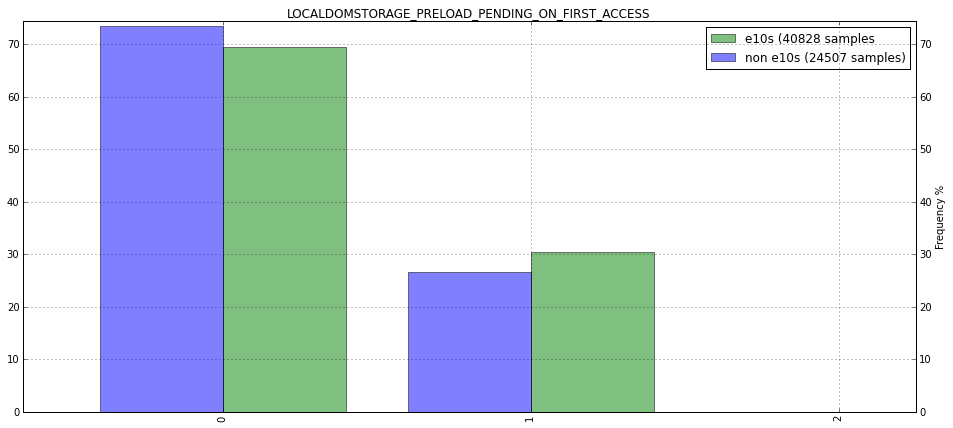

The chi2 distance for SSL_TIME_UNTIL_HANDSHAKE_FINISHED is 0.00177889759969


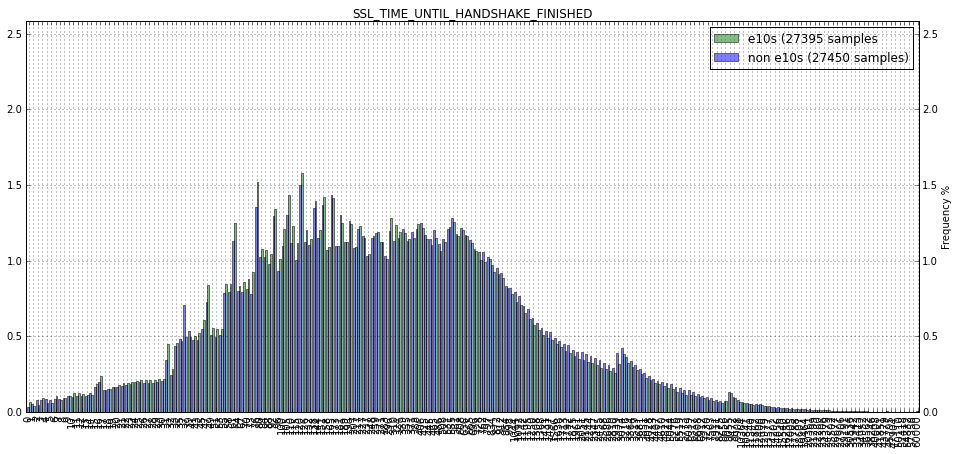

The chi2 distance for SSL_TIME_UNTIL_READY is 0.00175154771712


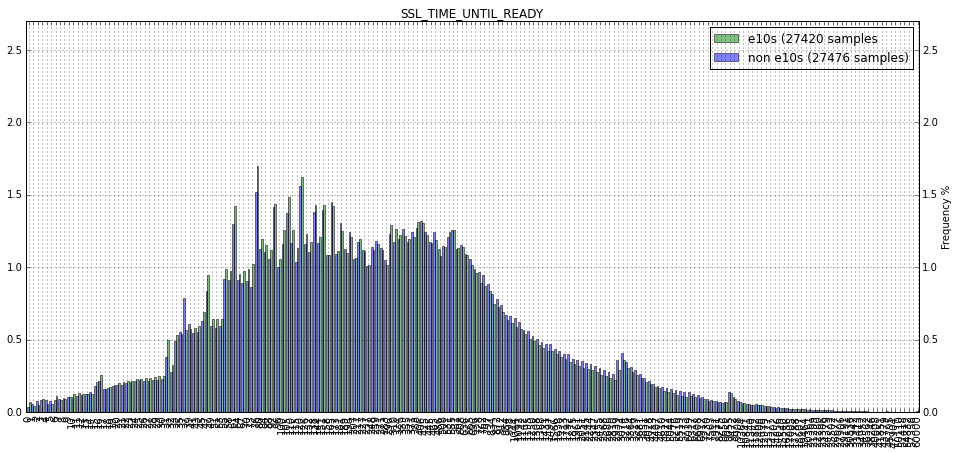

The chi2 distance for TELEMETRY_ARCHIVE_EVICTING_DIRS_MS is 0.00173868126957


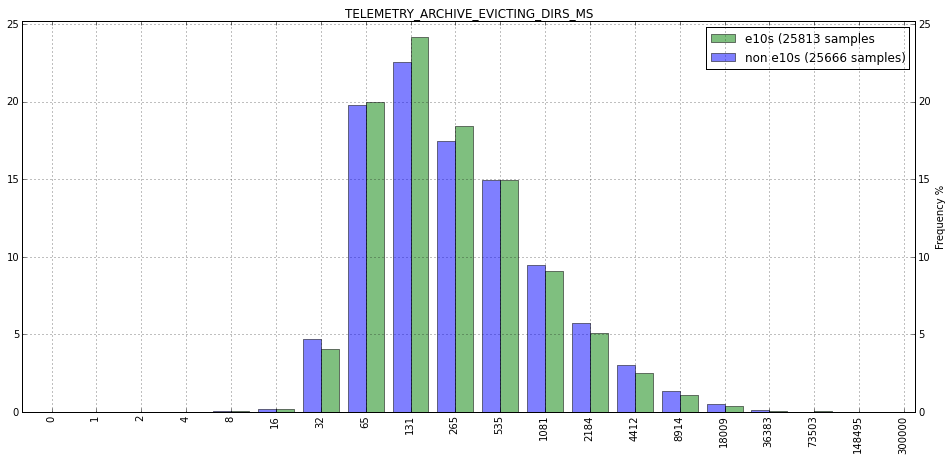

The chi2 distance for DEVTOOLS_TABS_OPEN_PEAK_LINEAR is 0.00173507850237


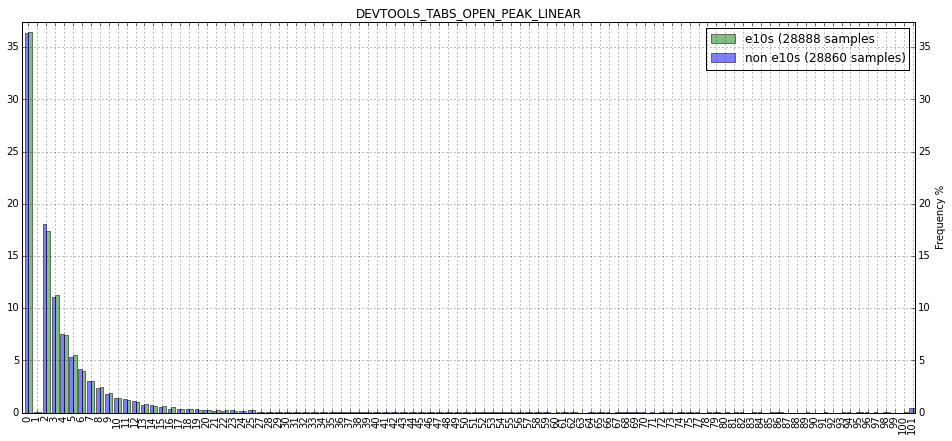

The chi2 distance for DEVTOOLS_TABS_OPEN_AVERAGE_LINEAR is 0.00173376518337


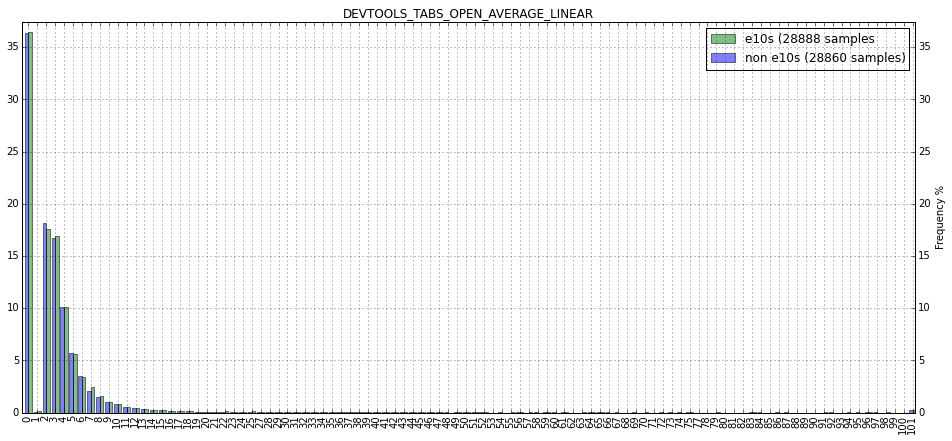

The chi2 distance for UPDATE_DOWNLOAD_CODE_COMPLETE is 0.00173109626559


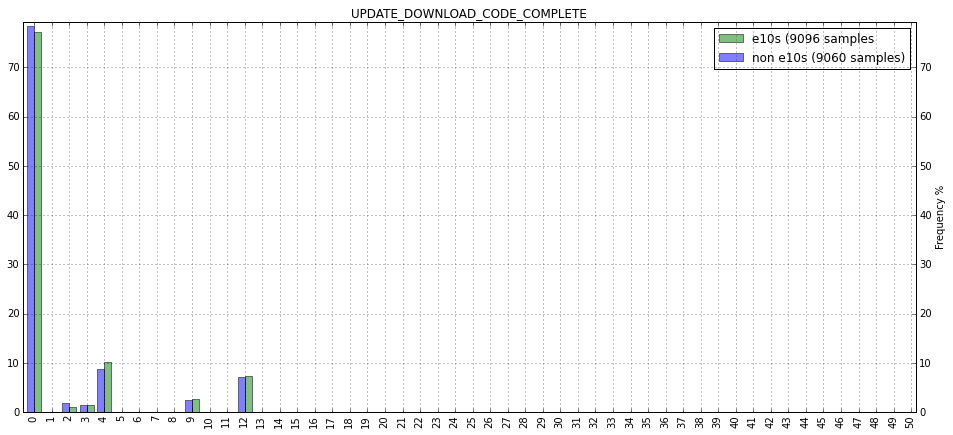

The chi2 distance for HTTP_SCHEME_UPGRADE is 0.00168033420122


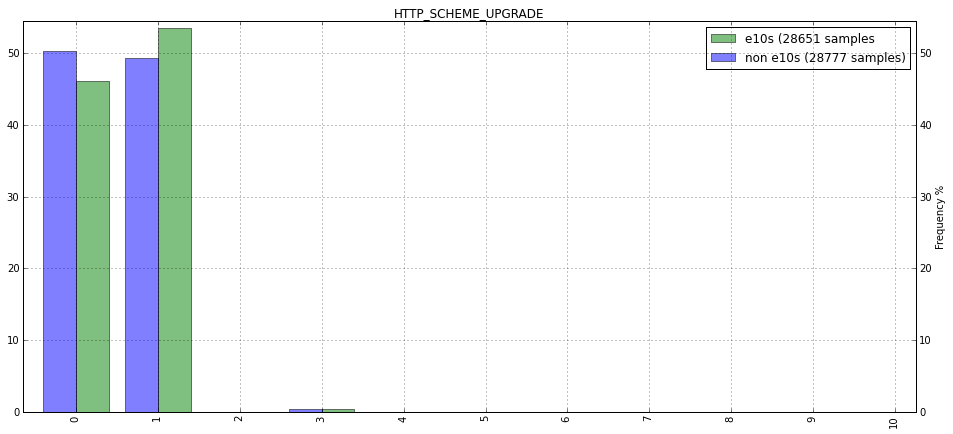

The chi2 distance for DWRITEFONT_DELAYEDINITFONTLIST_COUNT is 0.00167916414548


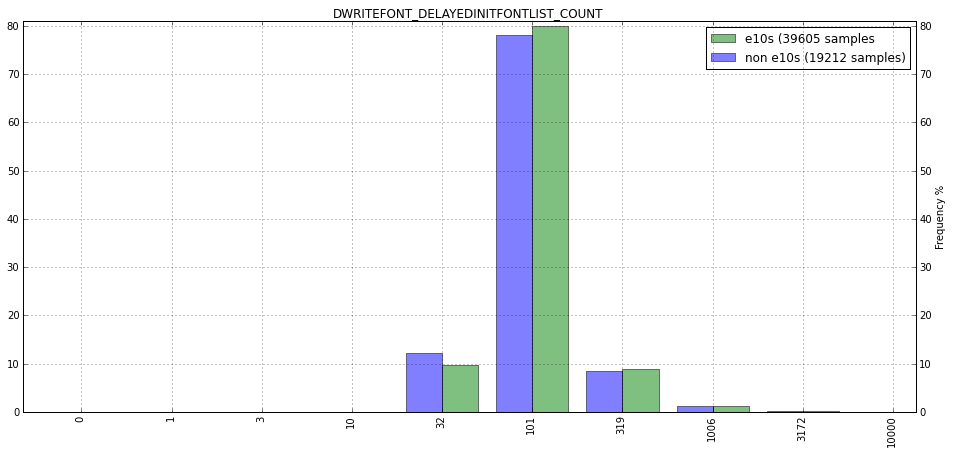

The chi2 distance for FX_SESSION_RESTORE_CONTENT_COLLECT_DATA_LONGEST_OP_MS is 0.00167131742909


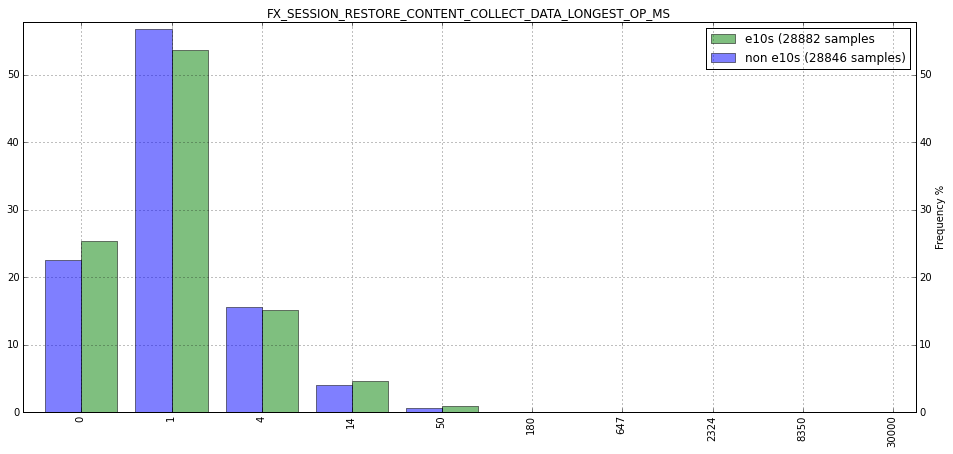

The chi2 distance for PLACES_AUTOCOMPLETE_6_FIRST_RESULTS_TIME_MS is 0.00166027384235


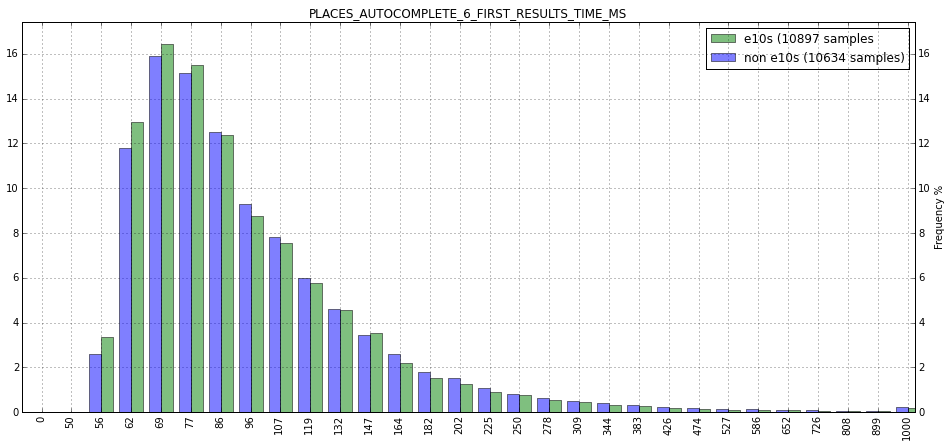

The chi2 distance for NEWTAB_PAGE_PINNED_SITES_COUNT is 0.00165752850081


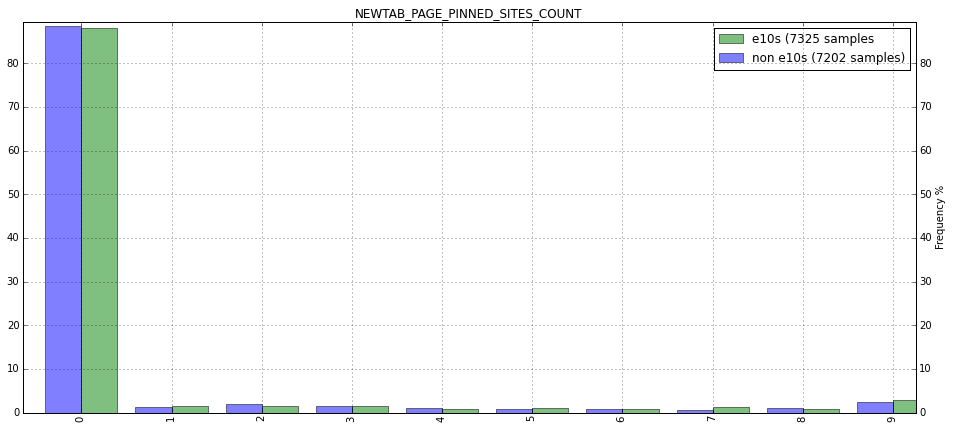

The chi2 distance for SPDY_CHUNK_RECVD is 0.00155323013958


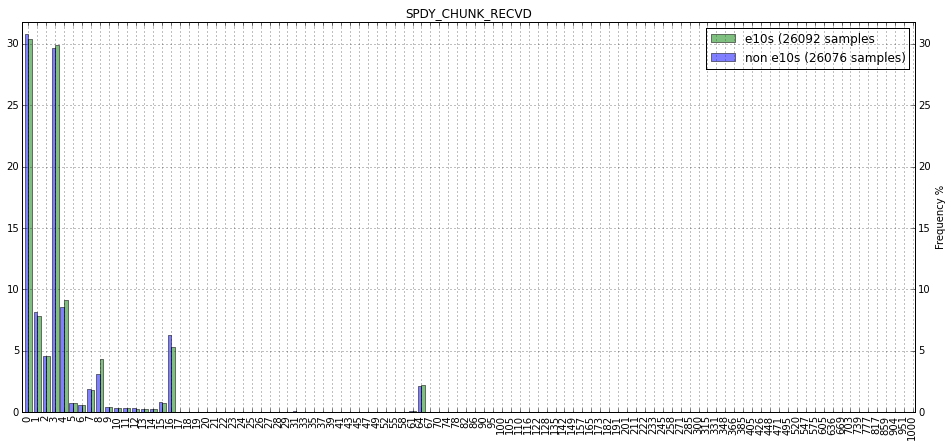

The chi2 distance for IMAGE_DECODE_TIME is 0.00153650238902


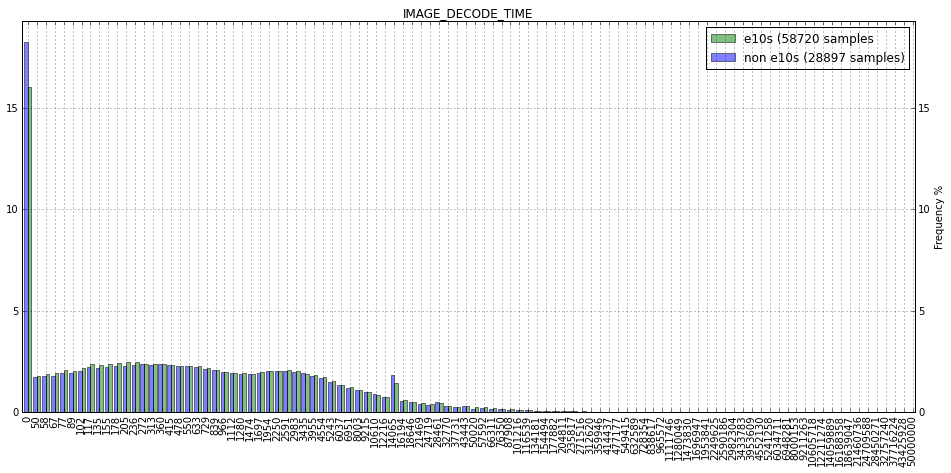

The chi2 distance for IMAGE_DECODE_SPEED_PNG is 0.00148522735237


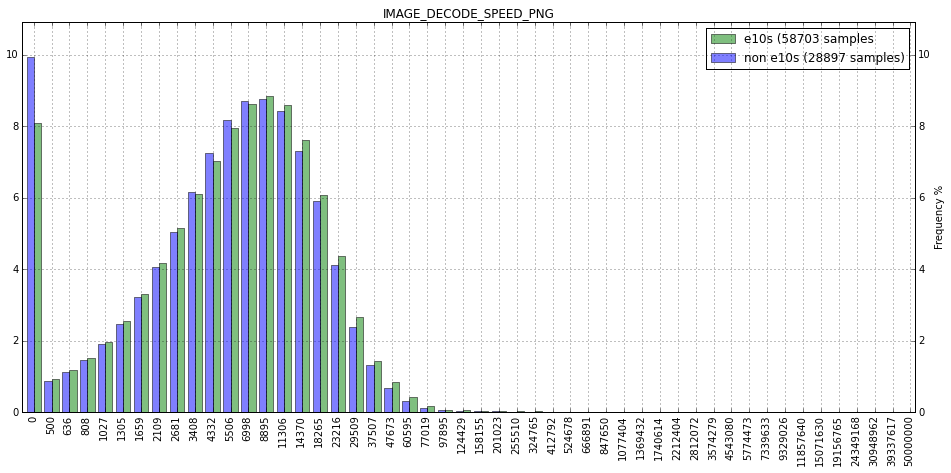

The chi2 distance for A11Y_ISIMPLEDOM_USAGE_FLAG is 0.00148487108377


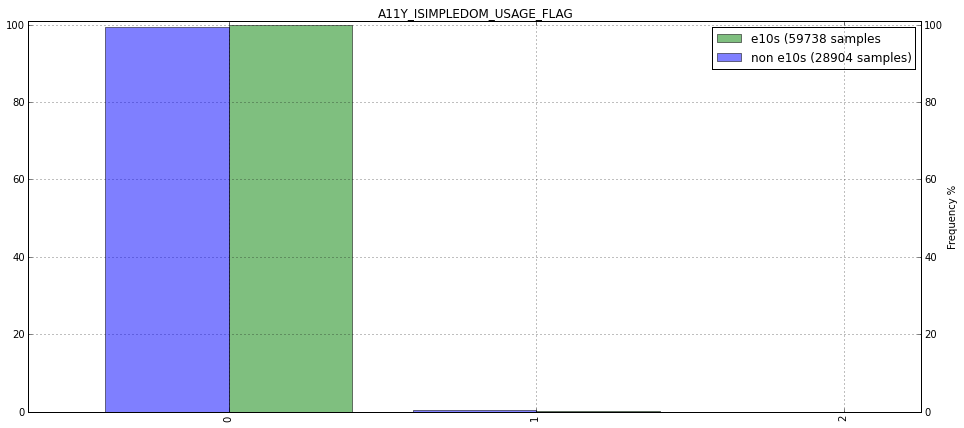

The chi2 distance for STARTUP_WORD_CACHE_HITS_CHROME is 0.00143502623229


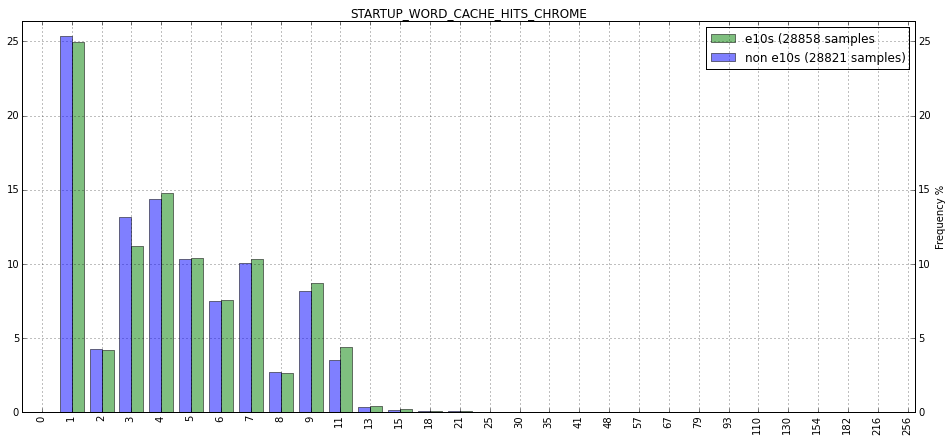

The chi2 distance for FX_SESSION_RESTORE_FILE_SIZE_BYTES is 0.00141828707992


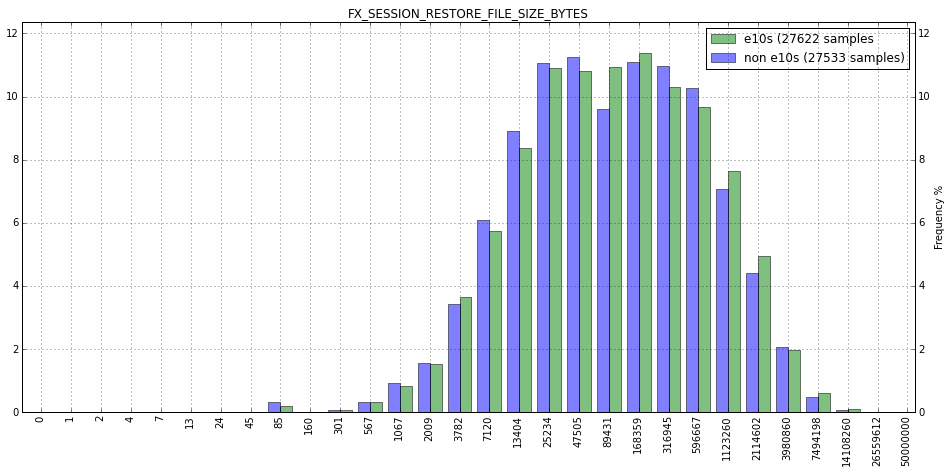

The chi2 distance for SSL_OBSERVED_END_ENTITY_CERTIFICATE_LIFETIME is 0.00139308106467


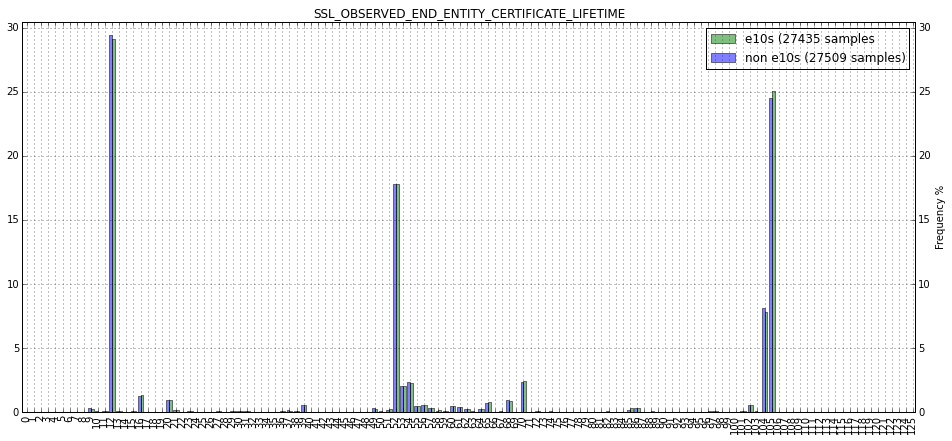

The chi2 distance for PREDICTOR_TOTAL_PRERESOLVES is 0.00135655147053


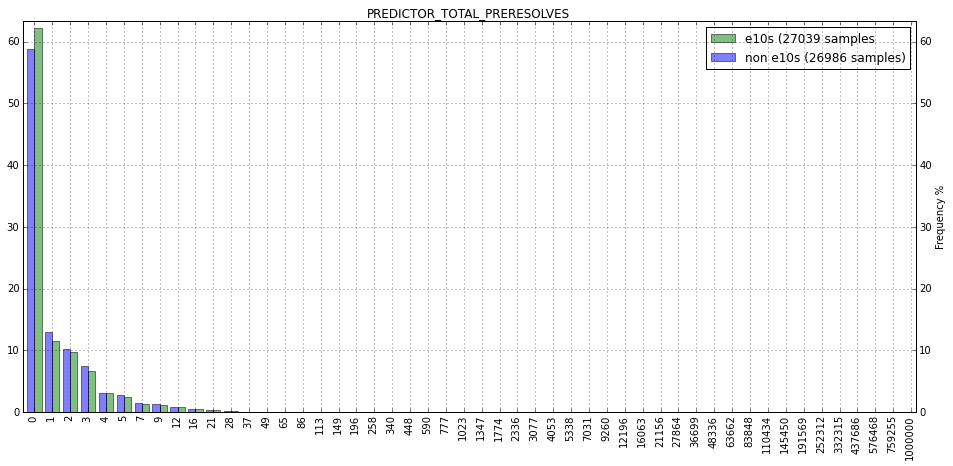

The chi2 distance for [[COUNT]]_SEARCH_COUNTS is 0.00134001949218


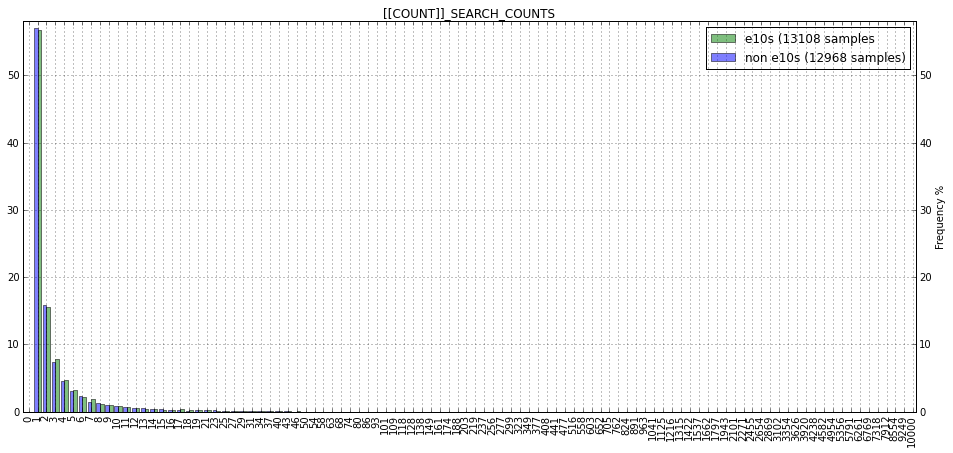

The chi2 distance for PWMGR_FORM_ACTION_EFFECT is 0.001328604012


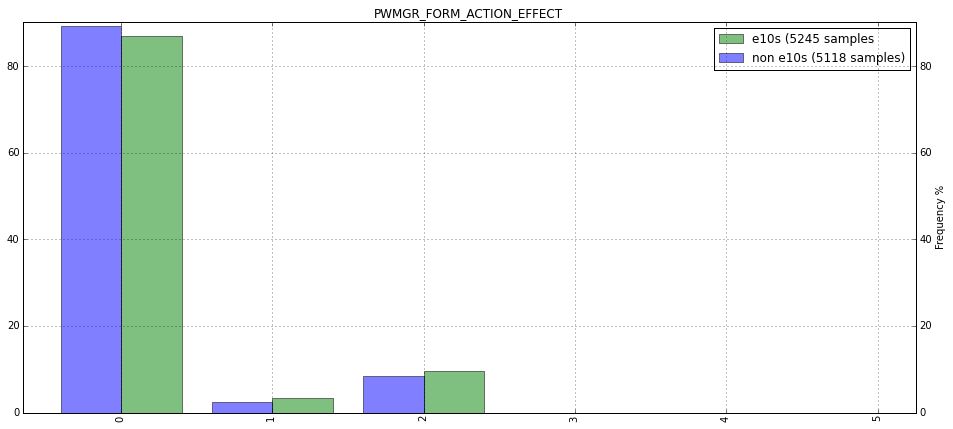

The chi2 distance for VIDEO_DECODED_H264_SPS_LEVEL is 0.00132071853662


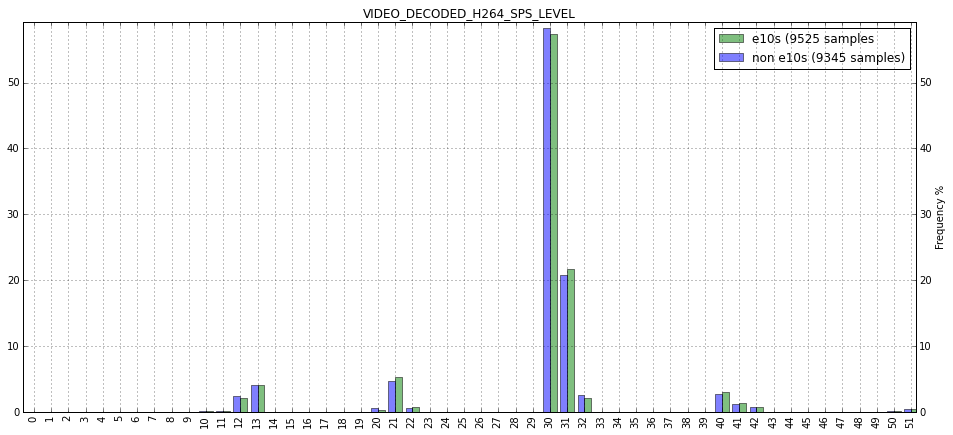

The chi2 distance for STARTUP_CRASH_DETECTED is 0.00131404581188


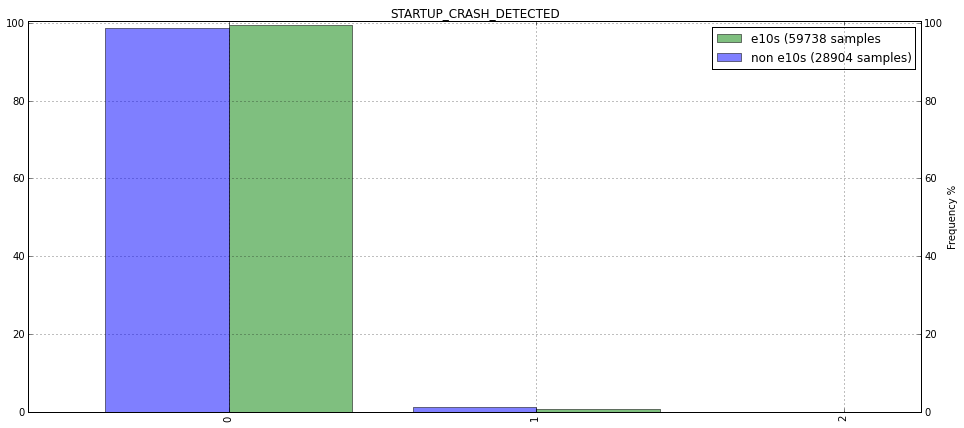

The chi2 distance for SSL_KEA_RSA_KEY_SIZE_FULL is 0.00129307429147


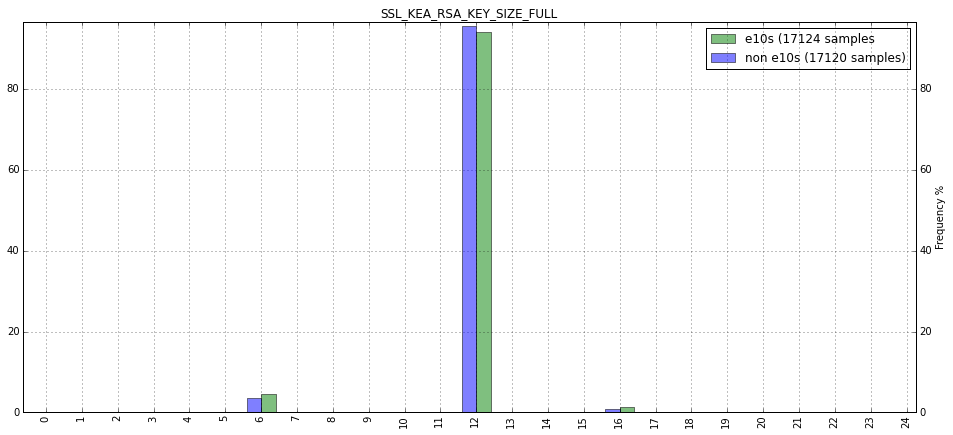

The chi2 distance for IDLE_NOTIFY_IDLE_MS is 0.00129057952976


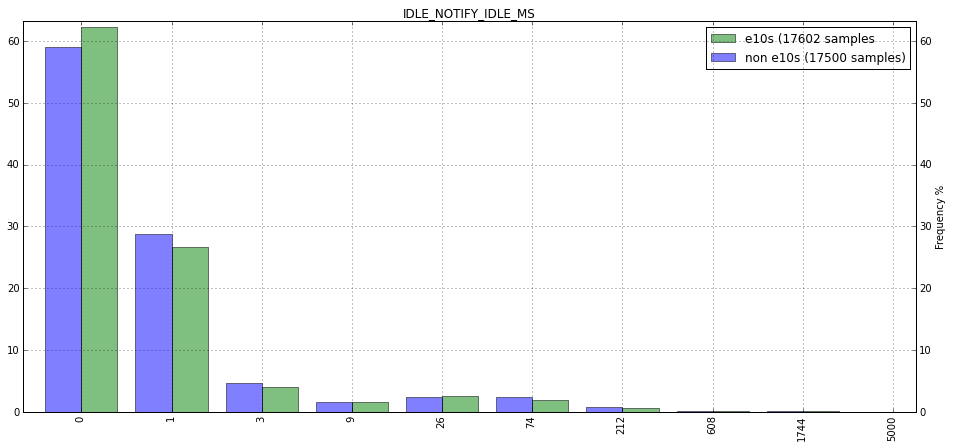

The chi2 distance for CHECK_JAVA_ENABLED is 0.00122580770765


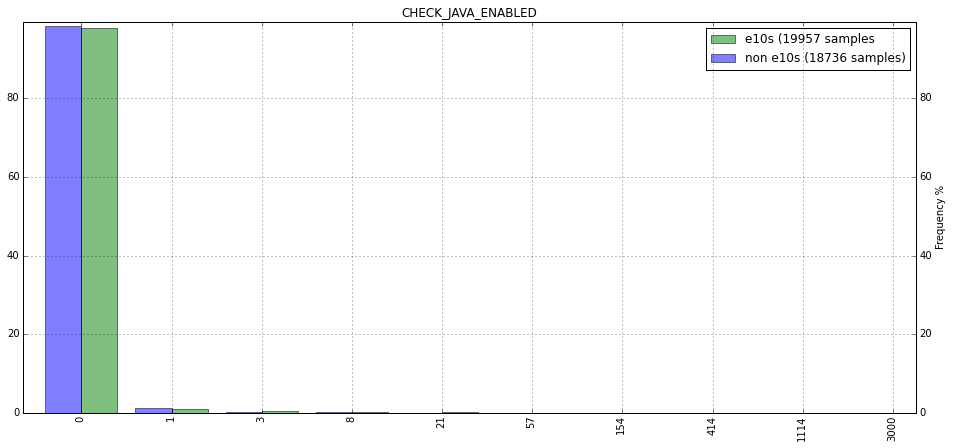

The chi2 distance for PLACES_DATABASE_SIZE_PER_PAGE_B is 0.00121261435471


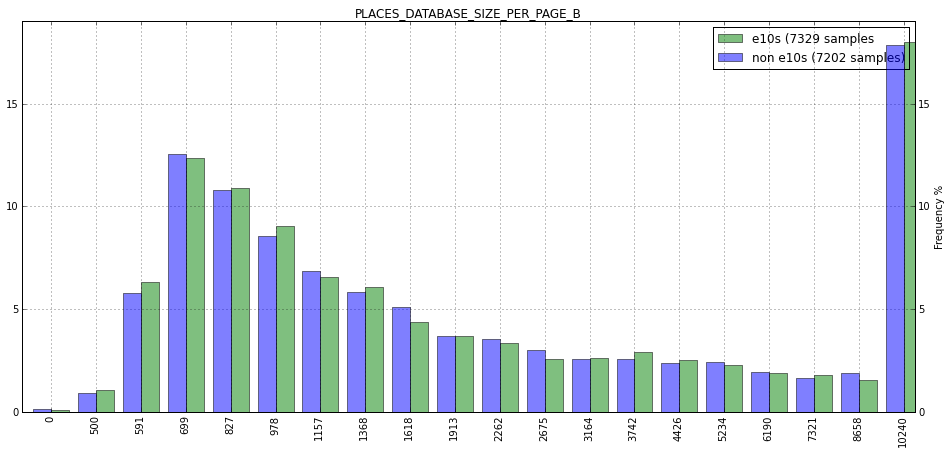

The chi2 distance for HTML_FOREGROUND_REFLOW_MS_2 is 0.0012087402808


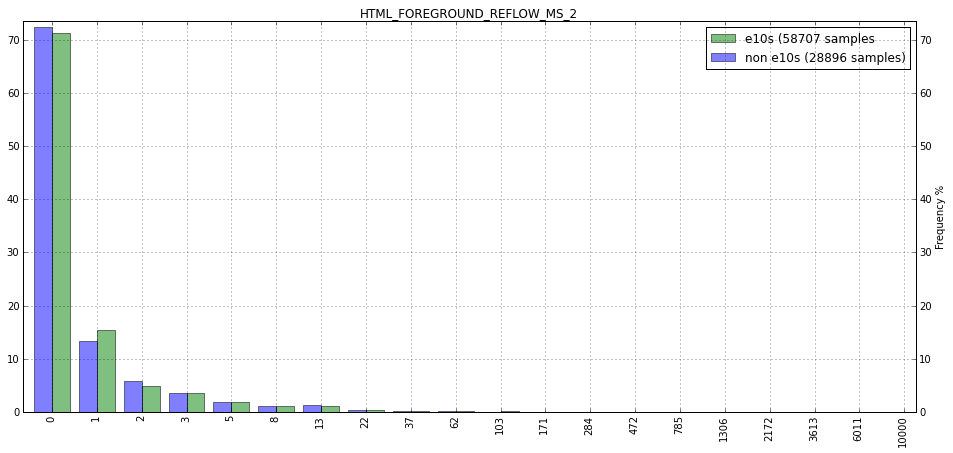

The chi2 distance for TRANSACTION_WAIT_TIME_HTTP is 0.00119880580731


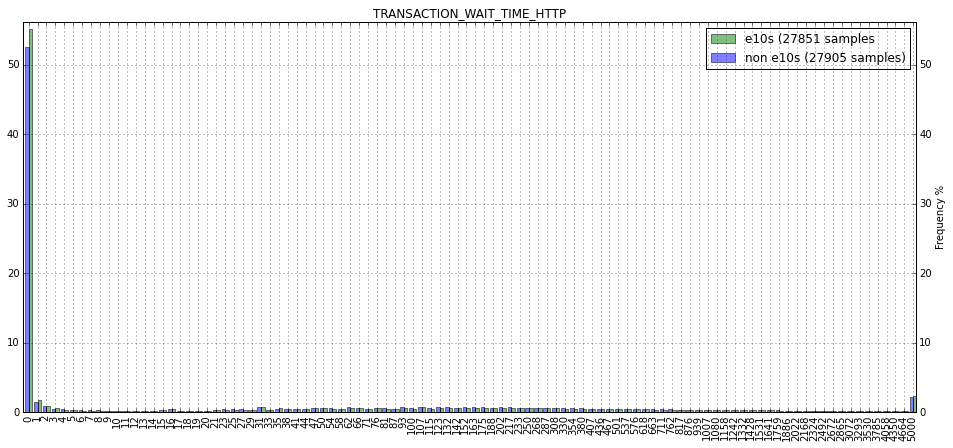

The chi2 distance for SIMPLE_MEASURES_ADDONMANAGER_XPIDB_SYNCREAD_MS is 0.00117302410644


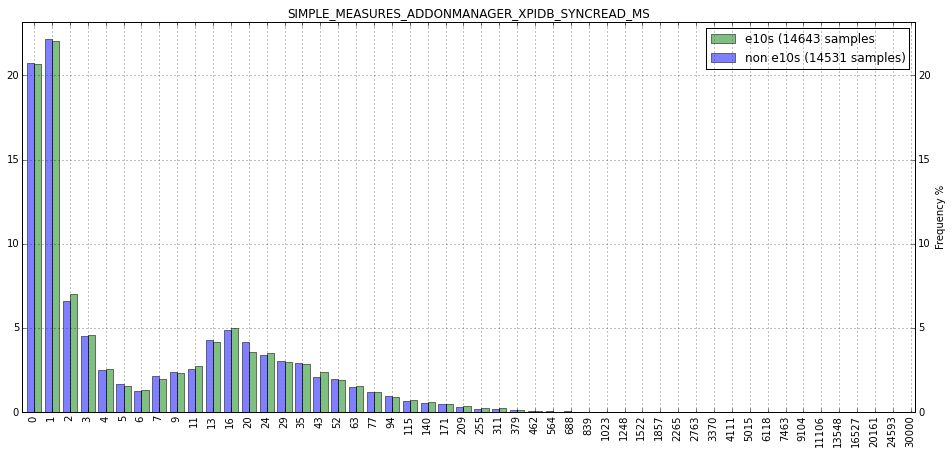

The chi2 distance for PLACES_PAGES_COUNT is 0.00116667491897


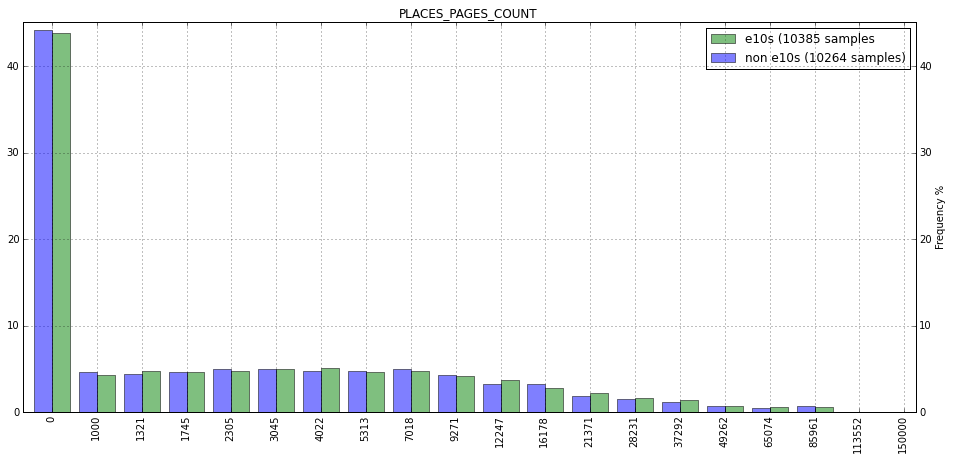

The chi2 distance for SPDY_SYN_SIZE is 0.00115995954301


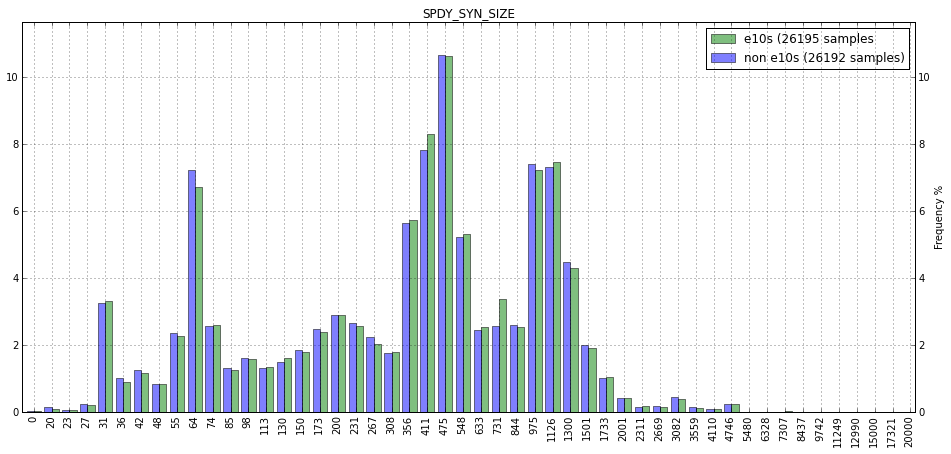

The chi2 distance for SIMPLE_MEASURES_START is 0.00113699637256


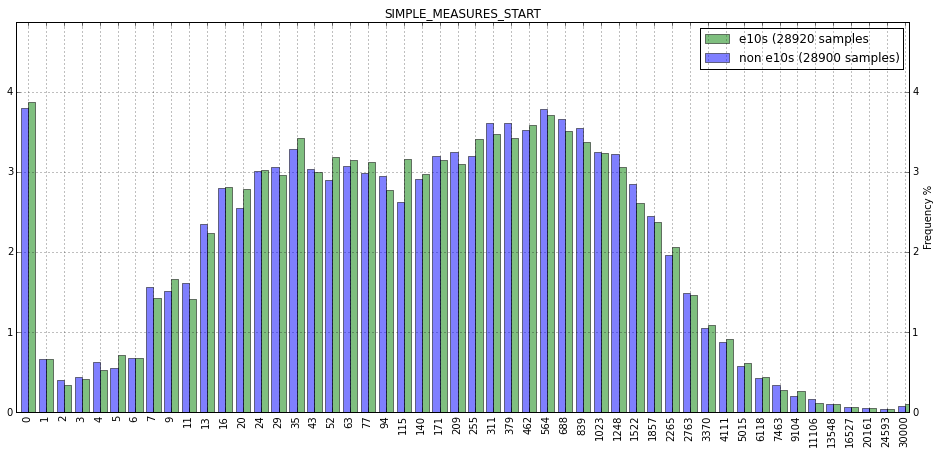

The chi2 distance for CERT_PINNING_MOZ_RESULTS is 0.0011166947517


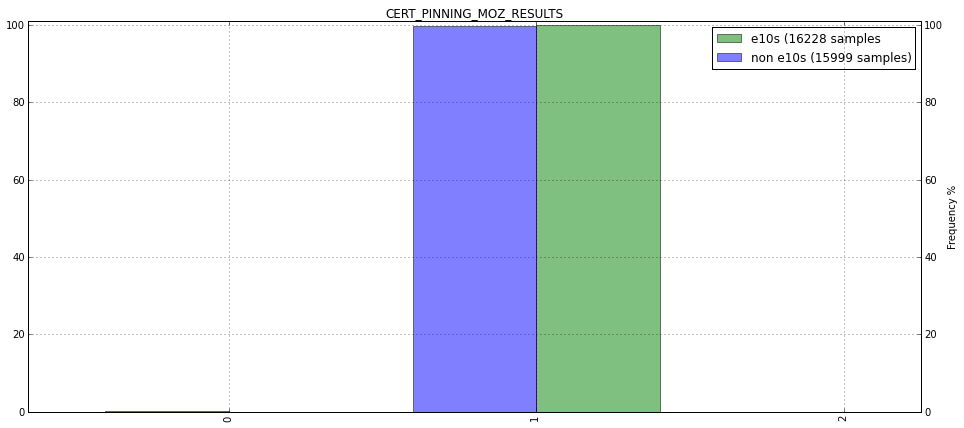

The chi2 distance for HTTP_CACHE_MISS_HALFLIFE_EXPERIMENT_2 is 0.00111035106368


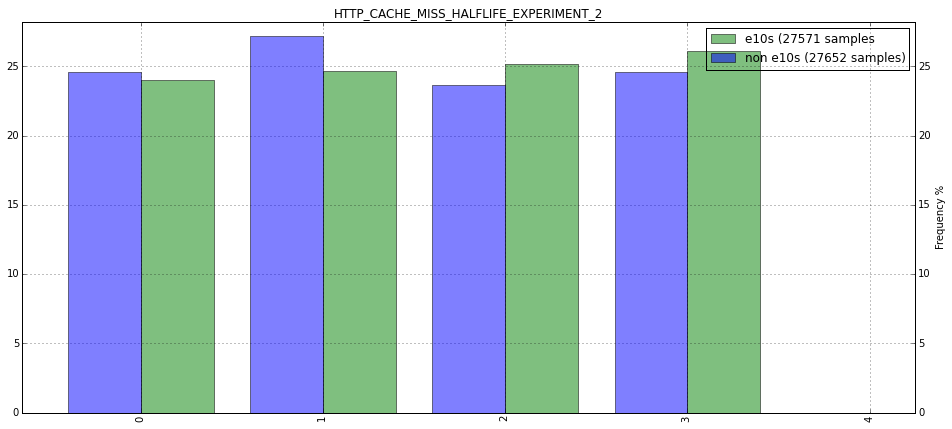

The chi2 distance for PLACES_BACKUPS_BOOKMARKSTREE_MS is 0.00108655148439


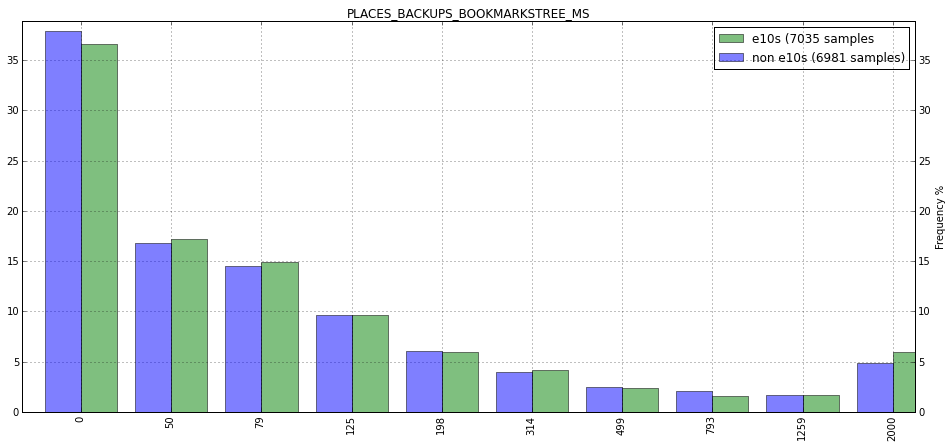

The chi2 distance for HEALTHREPORT_PAYLOAD_UNCOMPRESSED_BYTES is 0.00107668604904


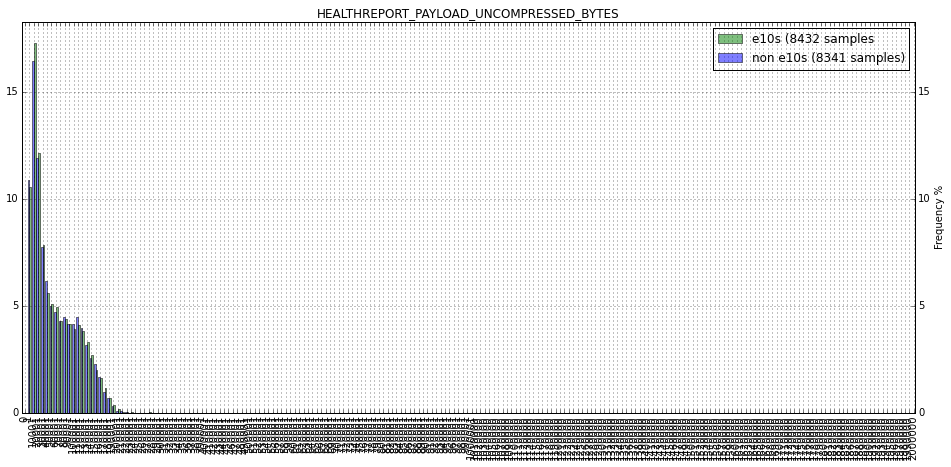

The chi2 distance for DECODER_INSTANTIATED_KOI8R is 0.00105628039972


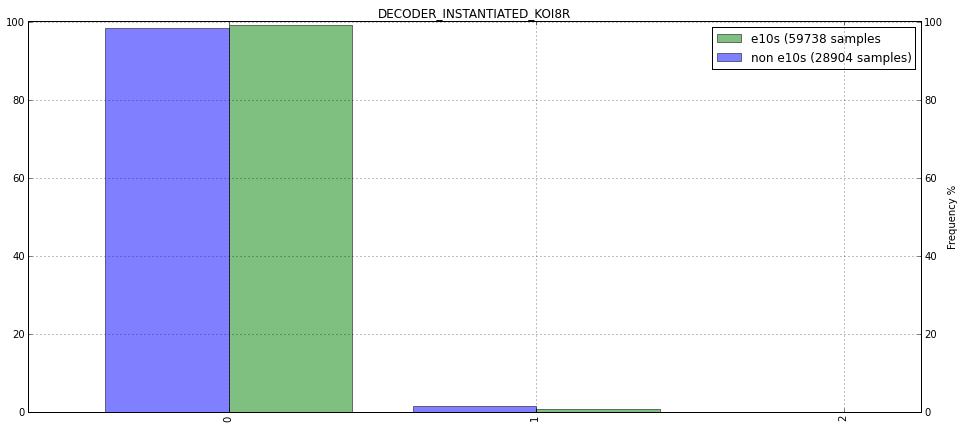

The chi2 distance for PLACES_AUTOCOMPLETE_1ST_RESULT_TIME_MS is 0.00104822001478


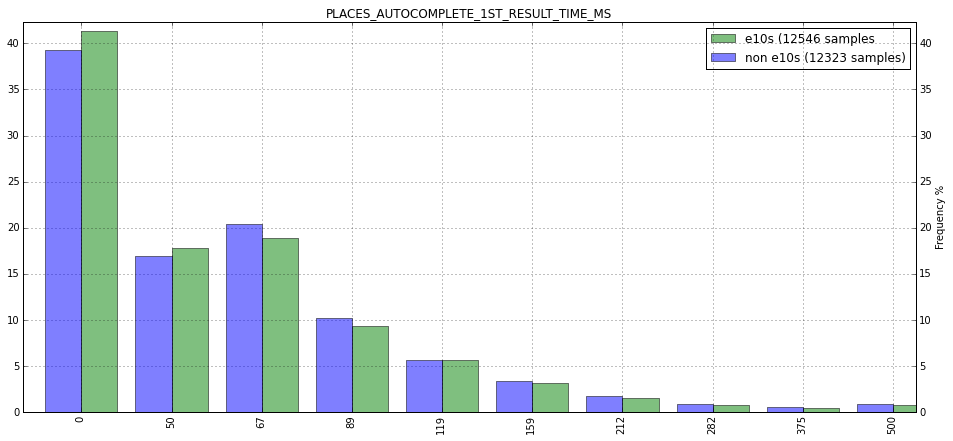

The chi2 distance for SIMPLE_MEASURES_SHUTDOWNDURATION is 0.00103357656222


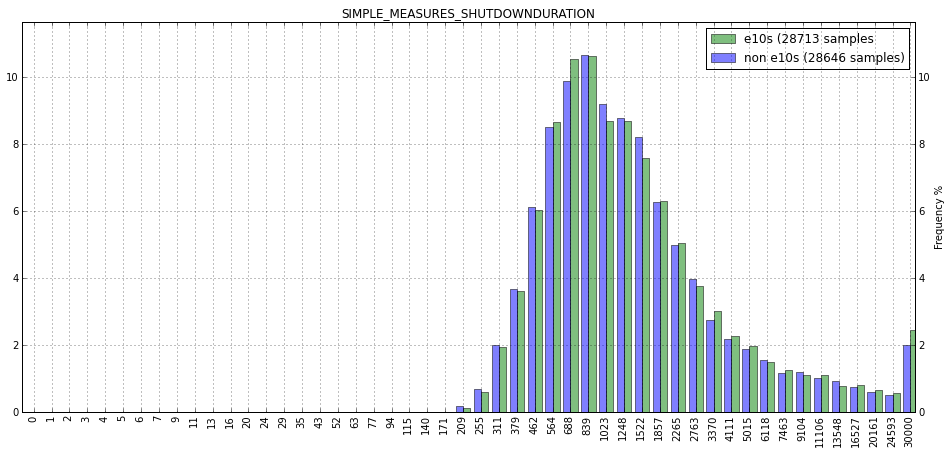

The chi2 distance for DNS_RENEWAL_TIME_FOR_TTL is 0.00100262895023


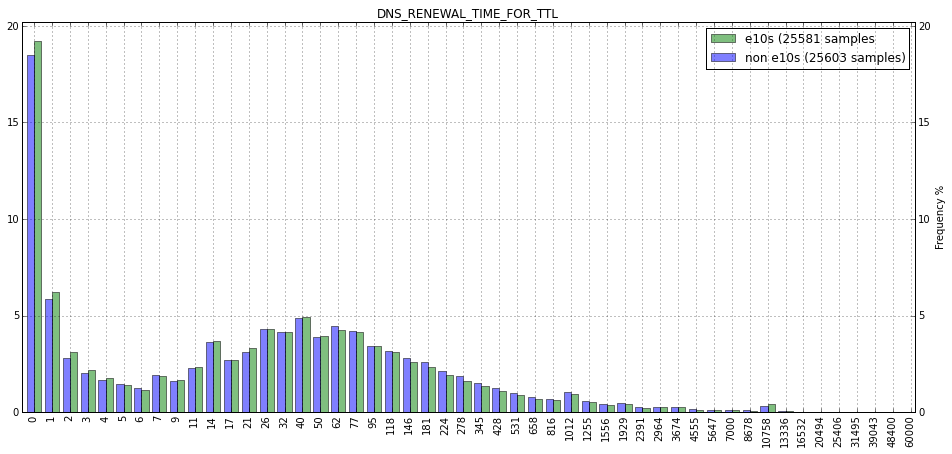

The chi2 distance for TELEMETRY_ARCHIVE_SCAN_PING_COUNT is 0.00100092322863


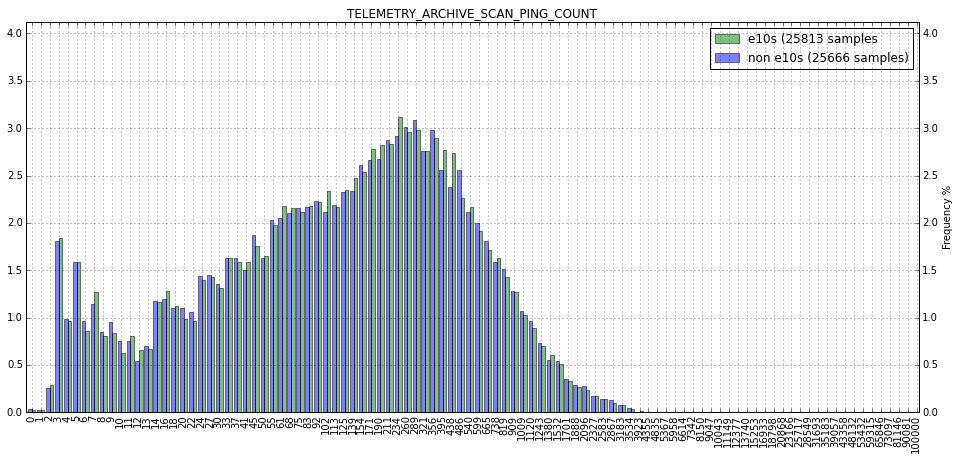

In [10]:
keys.sort(key=lambda key: chi2_distance(aggregates[0][key]["histogram"], aggregates[1][key]["histogram"]), reverse=True)

for key in keys:
    compare_histogram(key, aggregates[1][key], aggregates[0][key])    